# Aluguel de Casas no Brasil
### CRISP-DM Ciclo 1
---

## Preparação

### Imports e configurações

In [313]:
import sqlite3
import pickle
import h2o

import numpy                as np
import pandas               as pd
import seaborn              as sns
import matplotlib.pyplot    as plt

import umap.umap_           as umap

from scipy                  import stats
from IPython.core.display   import HTML
from yellowbrick.cluster    import KElbowVisualizer, SilhouetteVisualizer

from h2o.automl             import H2OAutoML
from scipy.cluster          import hierarchy
from sklearn.tree           import DecisionTreeRegressor
from sklearn.cluster        import KMeans
from sklearn.mixture        import GaussianMixture
from sklearn.metrics        import silhouette_score
from sklearn.manifold       import TSNE
from sklearn.ensemble       import RandomForestRegressor
from sklearn.decomposition  import PCA

# Configurando o estilo dos gráficos
sns.set(style = 'whitegrid', palette = 'tab10', color_codes = True)

cor1 = sns.color_palette('tab10')[0]
cor2 = sns.color_palette('tab10')[1]
cor3 = sns.color_palette('tab10')[2]
cor4 = sns.color_palette('tab10')[3]
cor5 = sns.color_palette('tab10')[4]
cor6 = sns.color_palette('tab10')[5]

# Caminho para o diretório do projeto
homepath = '/Users/guttofranca/Repos/brazilian_houses_for_rent/'

# Connect to sqlite database
conn = sqlite3.connect(homepath + 'data/processed/brazilian_houses.db')
data = pd.read_sql_query("SELECT * FROM rentals", conn)

seed = 42


### Funções

In [284]:
def jupyter_settings():
    
    """
    Plots pre settings.
    """


    %matplotlib inline
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()
    
jupyter_settings()

sns.set_style('white')

def overview(data):
    """
    Retorna uma visão geral dos dados fornecidos.

    Parâmetros:
    - data: DataFrame contendo os dados a serem analisados.

    Retorna:
    Um dicionário contendo as seguintes informações:
    - 'Número de Linhas': número de linhas do DataFrame.
    - 'Número de Colunas': número de colunas do DataFrame.
    - 'Tipos de Dados': dicionário com os tipos de dados de cada coluna.
    - 'Valores Nulos': dicionário com a contagem de valores nulos em cada coluna.
    - 'Valores Únicos': dicionário com a contagem de valores únicos em cada coluna.
    - 'Valores Duplicados': número de linhas duplicadas no DataFrame.
    """
    
    return {
        'Número de Linhas': data.shape[0],
        'Número de Colunas': data.shape[1],
        'Tipos de Dados': data.dtypes.to_dict(),
        'Valores Nulos': data.isnull().sum().to_dict(),
        'Valores Únicos': data.nunique().to_dict(),
        'Valores Duplicados': data.duplicated().sum()
    }


def describe_extended(data):
    """
    Retorna um DataFrame contendo estatísticas básicas e estendidas de um conjunto de dados.

    Parâmetros:
    data: (pandas.Series) - O conjunto de dados a ser analisado.

    Retorno:
    DataFrame - Um DataFrame contendo as estatísticas básicas (describe) e estendidas (var, skewness, kurtosis) do conjunto de dados.
    """
    # Use o método describe() para obter as estatísticas básicas
    desc = data.describe()
    
    # Calcule a skewness e a kurtosis para cada coluna
    var = data.var()
    skewness = data.apply(stats.skew)
    kurt = data.apply(stats.kurtosis)

    
    # Crie um novo DataFrame para armazenar as estatísticas estendidas
    extended_stats = pd.DataFrame({'var': var, 'skew': skewness, 'kurtosis': kurt})
    
    # Concatene o DataFrame de descrição básica com o DataFrame de estatísticas estendidas
    return pd.concat([desc, extended_stats.transpose()]).apply(lambda s: s.apply('{0:.3f}'.format))


def identify_outliers(dataframe, variables):
    """
    Identifica os 5 outliers mais extremos para cada variável especificada em um dataframe.

    dataframe(pandas.Series): DataFrame para análise.
    variables(List): Lista de variáveis (colunas) para identificar outliers.
    
    Retorna:  Dicionário de DataFrames, cada um contendo os 5 outliers mais extremos para cada variável.
    """
    outlier_dataframes = {}

    # Calcula os limiares de outliers para cada variável
    for var in variables:
        Q1 = dataframe[var].quantile(0.25)
        Q3 = dataframe[var].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filtra os outliers
        outliers = dataframe[(dataframe[var] < lower_bound) | (dataframe[var] > upper_bound)]

        # Cria um dataframe com os 5 outliers mais extremos
        outlier_dataframes[var] = pd.DataFrame(outliers.nlargest(5, var), columns=['id', var])

    return outlier_dataframes


def plot_label(title, xlabel, ylabel, fontsize):
    plt.title(title, fontsize = 18)
    plt.xlabel(xlabel, fontsize = fontsize)
    plt.ylabel(ylabel, fontsize = fontsize)
    sns.set_context('notebook')


def silhouette_score_result(clusters, model_list, color):
    """Generates a silhouette score of one model
    Args:
        clusters: [A list with clusters]
        model_list: [A list of the model labels info]
        color: [Color of the line]
    Returns:
        [Image]: [Silhouette Score]
    """

    ax = plt.plot(clusters, model_list, linestyle = '--', marker = 'o', color = color)
    plt.xlabel('Cluster')
    plt.xticks(clusters)
    plt.ylabel('Silhouette Score')
    plt.title('Comparação de Resultados')

    return ax

## Regras
 
Vocês, obrigatoriamente, terão que responder às 18 perguntas a seguir durante a Análise Exploratória. E com respostas que agreguem valor ao negócio! Uma dica: responda a pergunta e, caso necessário, proponha uma solução :D 
1. Correlação entre área e valor do aluguel: Existe uma correlação significativa entre a área do imóvel (area) e o valor do aluguel (rent amount)? 
2. Impacto da aceitação de animais: Como a aceitação de animais (animal) afeta o valor do aluguel (rent amount)? 
3. Distribuição de imóveis mobiliados: Qual é a proporção de imóveis mobiliados (furniture) e não mobiliados? Existe diferença no valor do aluguel entre eles? 
4. Análise de outliers no valor do IPTU (property tax): Existem outliers significativos no valor do IPTU? Como eles impactam o valor total (total)? 
5. Influência do número de vagas de estacionamento: Como o número de vagas de estacionamento (parking spaces) influencia o valor do aluguel (rent amount)? 
6. Relação entre andar (floor) e valor do aluguel: Existe alguma tendência no valor do aluguel com base no andar do imóvel? 
7. Variação das taxas de condomínio (HOA) por cidade: Como as taxas de condomínio variam entre diferentes cidades?
8. Correlação entre número de banheiros e valor do aluguel: Qual é a relação entre o número de banheiros (bathroom) e o valor do aluguel (rent amount)? 
9. Variação do valor do aluguel por cidade: Como o valor do aluguel (rent amount) varia entre diferentes cidades? 
10. Distribuição do custo total (total): Como é a distribuição do custo total dos aluguéis? 
11. Previsão de valor de aluguel baseado em características **DESAFIO!!!**: Quais características são os melhores preditores para o valor do aluguel? 
12. Proporção do seguro incêndio no custo total: Qual é a proporção do seguro incêndio (fire insurance) no custo total (total)? 
13. Variação do valor do aluguel com base no número de quartos: Como o número de quartos (rooms) afeta o valor do aluguel (rent amount)? 
14. Análise de agrupamento de imóveis **DESAFIO!!!**: É possível identificar grupos de imóveis com características semelhantes? 
15. Influência da localização na taxa de HOA: A localização (cidade) tem impacto significativo na taxa de HOA? 
16. Relação entre área e número de quartos/banheiros: Existe uma relação entre a área do imóvel (area) e o número de quartos (rooms) e banheiros (bathroom)? 
17. Diferenças no valor do aluguel por tipo de mobília: Como a presença ou ausência de mobília (furniture) afeta o valor do aluguel (rent amount)? 
18. Análise de densidade de imóveis por cidade: Qual cidade possui mais imóveis listados para aluguel? 
19. Perfil dos imóveis mais caros e mais baratos: Quais características são comuns nos imóveis com os valores de aluguel mais altos e mais baixos? 
20. Relação entre quantidade de banheiros e quartos: Existe uma correlação entre o número de quartos (rooms) e o número de banheiros (bathroom)?

## Descrição dos dados

---
- **id**: Identificador único dos imóveis.
- **city**: Código da cidade onde o imóvel está localizado.
- **area**: Área do imóvel em metros quadrados.
- **rooms**: Número de quartos.
- **bathroom**: Número de banheiros.
- **parking spaces**: Número de vagas de estacionamento.
- **floor**: Andar do imóvel.
- **animal**: Permissão para animais de estimação (1 para sim, 0 para não).
- **furniture**: Mobiliado (1 para sim, 0 para não).
- **hoa**: Valor do condomínio.
- **rent amount**: Valor do aluguel.
- **property tax**: Valor do IPTU (Imposto Predial e Territorial Urbano).
- **fire insurance**: Valor do seguro contra incêndio.
- **total**: Valor total do aluguel, incluindo todas as taxas.

---


In [133]:
overview(data)

{'Número de Linhas': 6080,
 'Número de Colunas': 14,
 'Tipos de Dados': {'id': dtype('int64'),
  'city': dtype('int64'),
  'area': dtype('int64'),
  'rooms': dtype('int64'),
  'bathroom': dtype('int64'),
  'parking spaces': dtype('int64'),
  'floor': dtype('int64'),
  'animal': dtype('int64'),
  'furniture': dtype('int64'),
  'hoa': dtype('int64'),
  'rent amount': dtype('int64'),
  'property tax': dtype('int64'),
  'fire insurance': dtype('int64'),
  'total': dtype('int64')},
 'Valores Nulos': {'id': 0,
  'city': 0,
  'area': 0,
  'rooms': 0,
  'bathroom': 0,
  'parking spaces': 0,
  'floor': 0,
  'animal': 0,
  'furniture': 0,
  'hoa': 0,
  'rent amount': 0,
  'property tax': 0,
  'fire insurance': 0,
  'total': 0},
 'Valores Únicos': {'id': 6080,
  'city': 2,
  'area': 435,
  'rooms': 9,
  'bathroom': 10,
  'parking spaces': 10,
  'floor': 37,
  'animal': 2,
  'furniture': 2,
  'hoa': 1290,
  'rent amount': 1032,
  'property tax': 1035,
  'fire insurance': 190,
  'total': 4069},
 'V

In [134]:
# Análise estatística
describe_extended(data).T

,count,mean,std,min,25%,50%,75%,max,var,skew,kurtosis
id,6080.000,3039.500,1755.289,0.000,1519.750,3039.500,4559.250,6079.000,3081040.000,0.000,-1.200
city,6080.000,0.863,0.344,0.000,1.000,1.000,1.000,1.000,0.118,-2.115,2.475
area,6080.000,151.144,375.559,10.000,58.000,100.000,200.000,24606.000,141044.927,51.693,3162.252
rooms,6080.000,2.493,1.130,1.000,2.000,3.000,3.000,10.000,1.276,0.528,0.761
bathroom,6080.000,2.342,1.439,1.000,1.000,2.000,3.000,10.000,2.070,1.070,0.772
parking spaces,6080.000,1.756,1.612,0.000,1.000,1.000,2.000,12.000,2.598,1.434,2.682
floor,6080.000,5.672,6.169,0.000,0.000,4.000,9.000,99.000,38.056,2.117,15.488
animal,6080.000,0.767,0.423,0.000,1.000,1.000,1.000,1.000,0.179,-1.266,-0.397
furniture,6080.000,0.260,0.439,0.000,0.000,0.000,1.000,1.000,0.193,1.093,-0.805
hoa,6080.000,1088.426,3981.358,0.000,24.500,650.000,1436.000,220000.000,15851208.553,47.922,2525.963


## Análise Exploratória de Dados (EDA)

### Visão Geral dos Dados:
- Número de Linhas: 6080
- Número de Colunas: 14
- Tipos de Dados: Todos são inteiros
- Valores Nulos: Não há valores nulos em nenhuma coluna.
- Valores Únicos: Existem 2 cidades, 435 áreas de imóveis diferentes sendo nenhum duplicado
- Valores Duplicados: 0

### Análise Estatística Descritiva:
- Área: Varia de 10 a 24.606 m², com média de 151,14 m².
- Quartos: A maioria dos imóveis tem entre 1 e 3 quartos.
- Banheiros: Em média, os imóveis possuem 2,34 banheiros.
- Vagas de Estacionamento: Média de 1,76 vagas por imóvel.
- Andar: Varia de 0 (possivelmente térreo) a 99, com média de 5,67.
- Animais de Estimação: A maioria dos imóveis permite animais (76,74%).
- Mobília: 26,02% dos imóveis são mobiliados.
- Custos Financeiros: O valor do aluguel varia significativamente, com uma média de R$ 4.395,84.

### Outliers

In [135]:
variables = ['rent amount', 'area', 'hoa', 'property tax']
outliers_df = identify_outliers(data, variables)


In [136]:
outliers_df['area']

,id,area
4178,4178,24606
5494,5494,12732
3983,3983,1600
5178,5178,1000
1533,1533,999


In [137]:
outliers_df['hoa']

,id,hoa
1269,1269,220000
3303,3303,200000
4438,4438,14130
832,832,10000
5752,5752,9900


In [138]:
outliers_df['property tax']

,id,property tax
5627,5627,366300
2611,2611,313700
5025,5025,10830
3694,3694,9500
4356,4356,9500


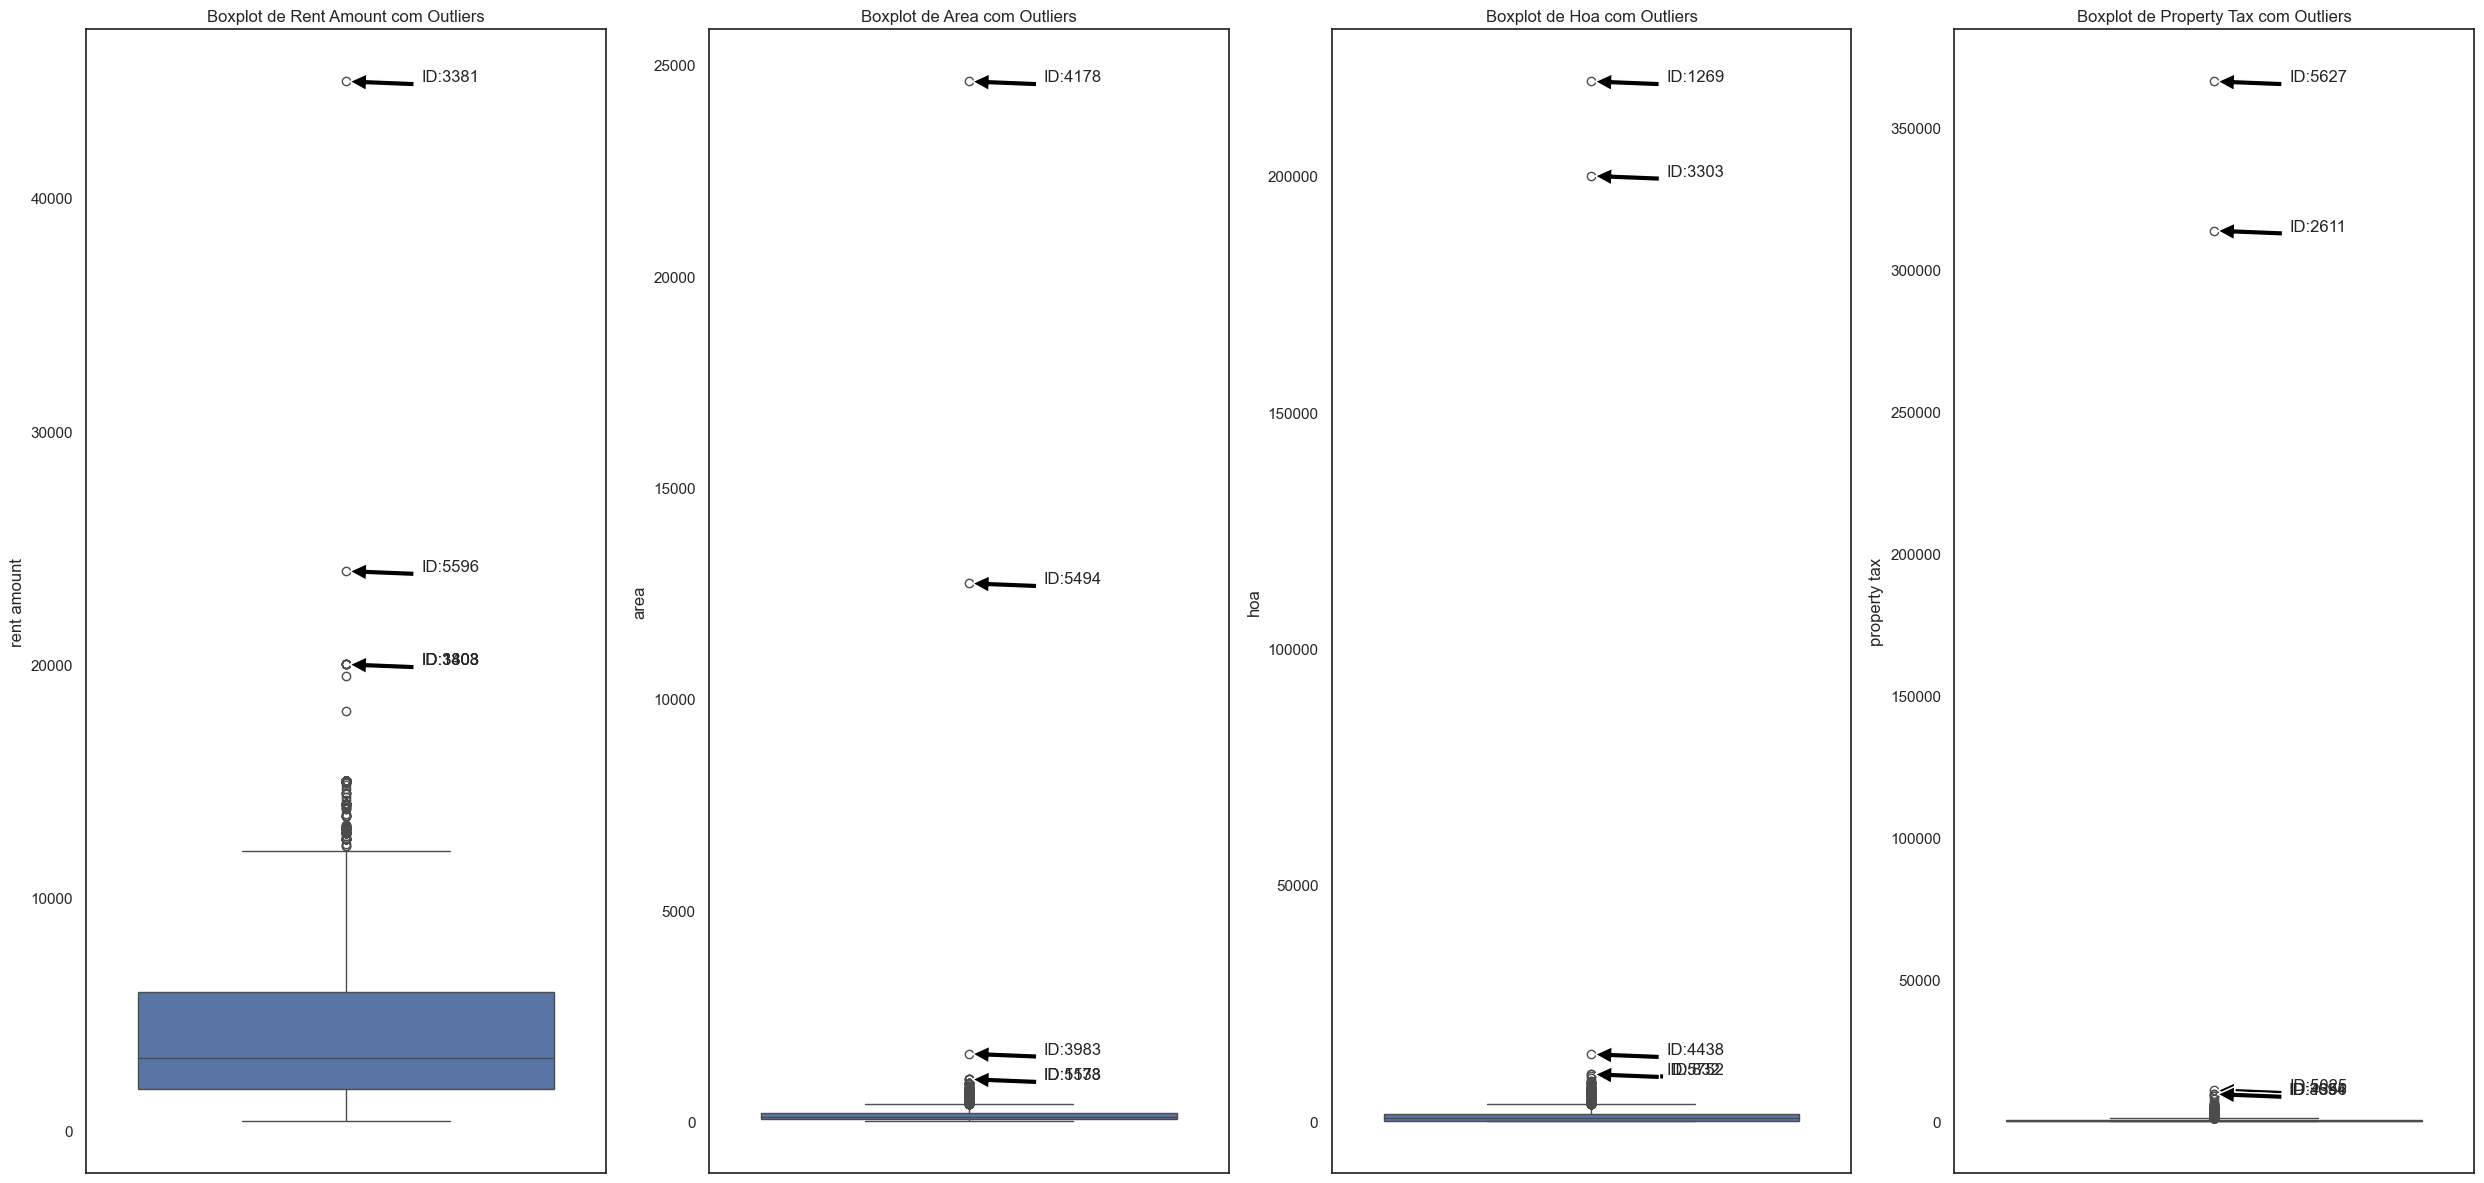

In [139]:
# Configurando o tamanho dos gráficos
plt.figure()

# Criando boxplots e anotando os top 5 outliers para cada variável
for i, var in enumerate(variables, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(y = data[var])
    plt.title(f'Boxplot de {var.title()} com Outliers')

    # Anotando os top 5 outliers
    for index, row in outliers_df[var].iterrows():
        plt.annotate(f'ID:{row["id"]}', xy=(0, row[var]), xytext=(0.2, row[var]),
                     arrowprops=dict(facecolor='black', shrink=0.05), ha='center')

plt.tight_layout()
plt.savefig(homepath + 'reports/figures/boxplot_outliers.png')
plt.show()

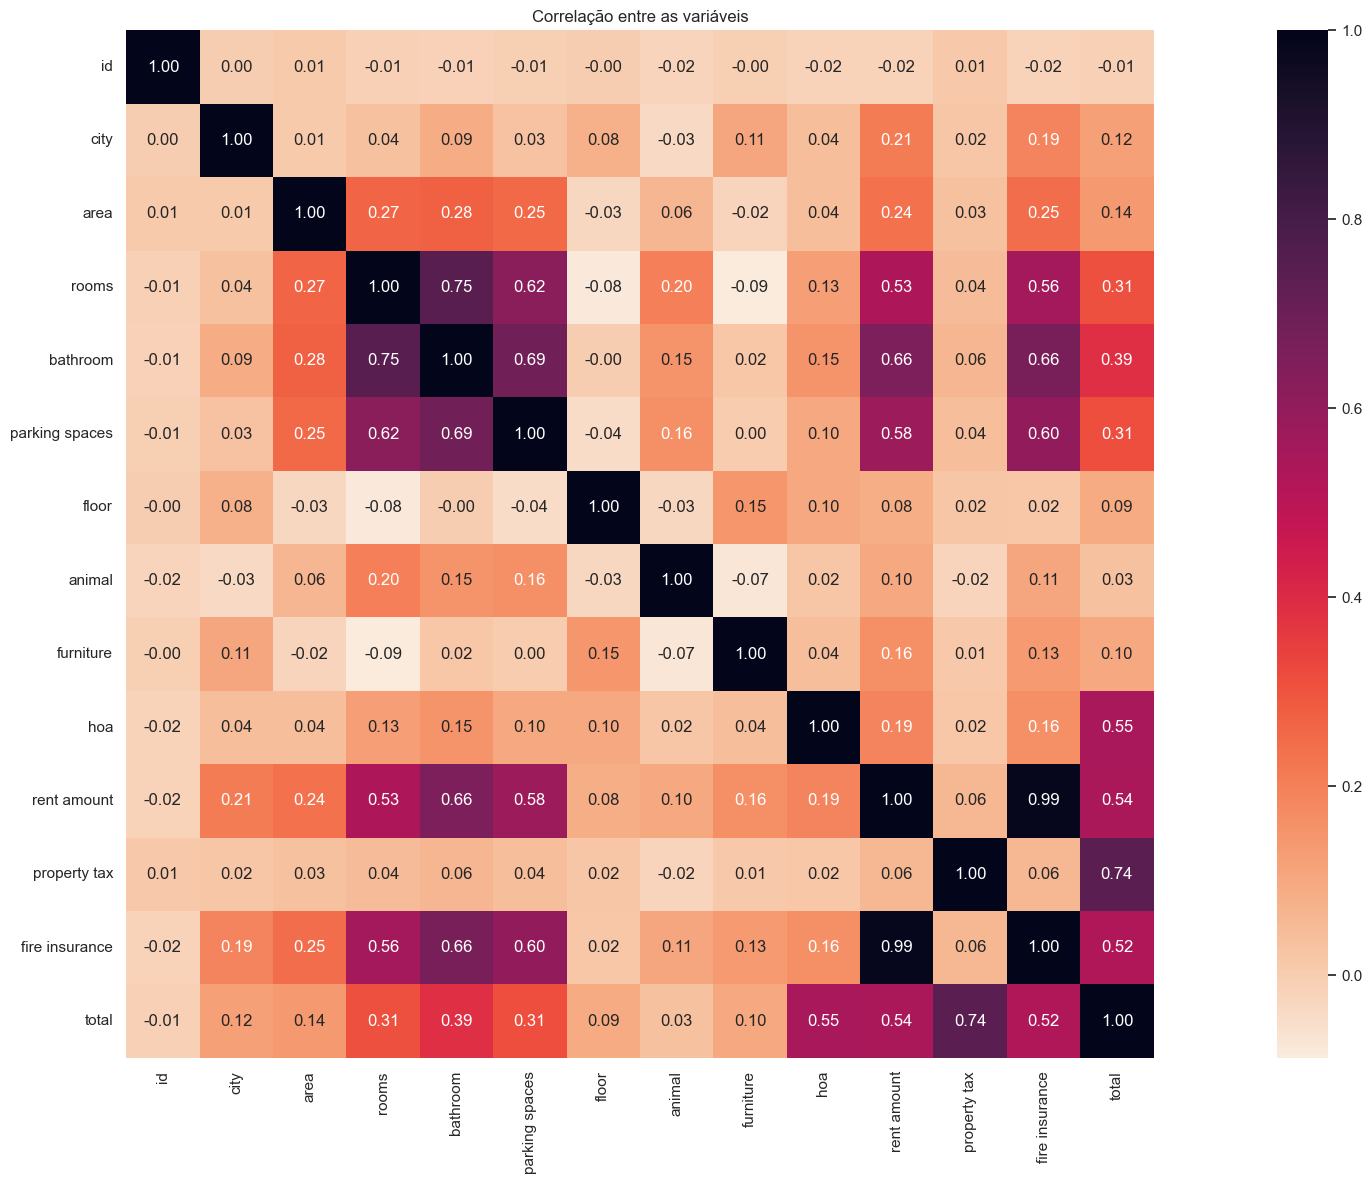

In [140]:
# Criando um heatmap para verificar a correlação entre as variáveis
corr = data.corr()
sns.heatmap(corr, cmap = 'rocket_r', fmt = '.2f', square = True, linecolor = 'white', annot = True)

plt.title('Correlação entre as variáveis')
plt.tight_layout();
plt.savefig(homepath + 'reports/figures/correlation.png')



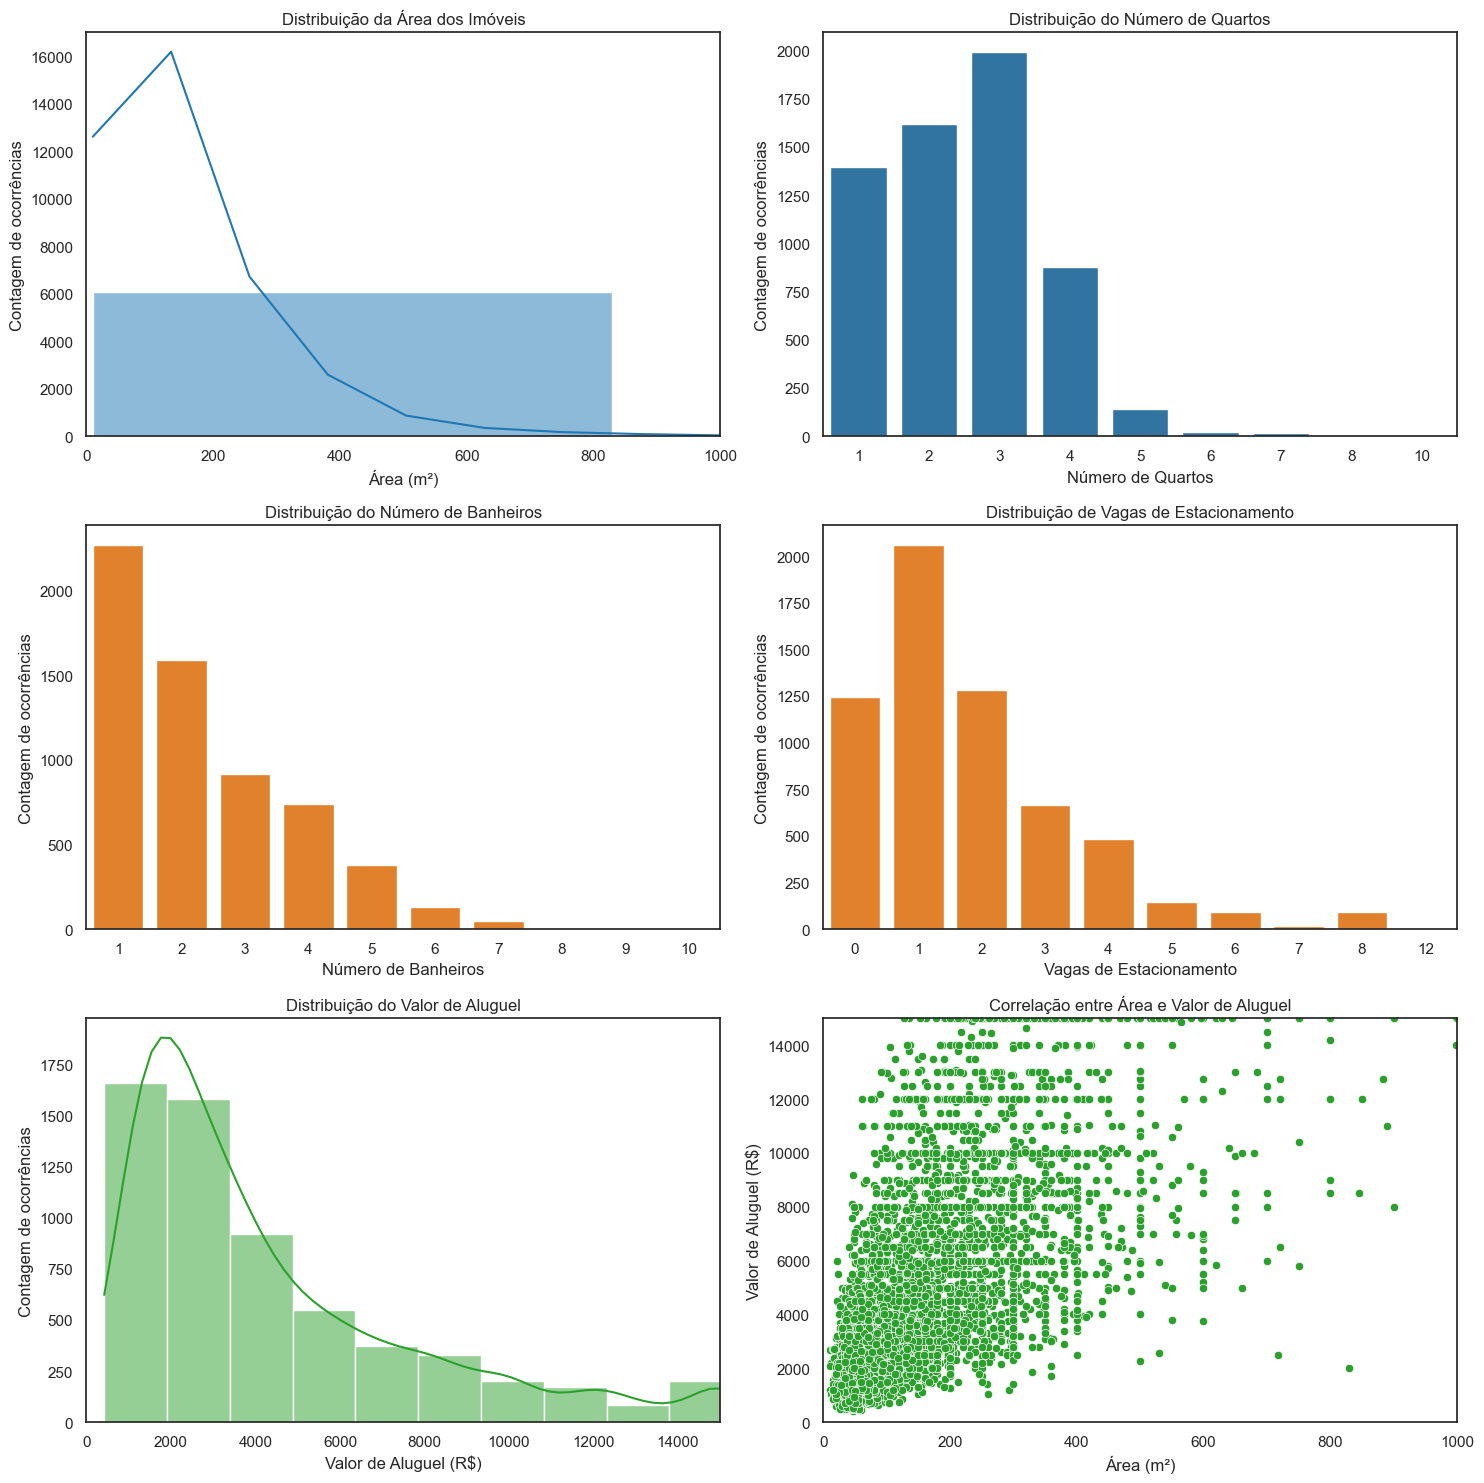

In [141]:
# Criando um conjunto de figuras para várias análises
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Distribuição de Área
sns.histplot(data['area'], bins=30, ax=axes[0, 0], kde=True, color = cor1)
axes[0, 0].set_title('Distribuição da Área dos Imóveis')
axes[0, 0].set_xlim(0, 1000) # Limitando
axes[0, 0].set_xlabel('Área (m²)')
axes[0, 0].set_ylabel('Contagem de ocorrências')

# Distribuição de Quartos
sns.countplot(x='rooms', data=data, ax=axes[0, 1], color = cor1)
axes[0, 1].set_title('Distribuição do Número de Quartos')
axes[0, 1].set_xlabel('Número de Quartos')
axes[0, 1].set_ylabel('Contagem de ocorrências')

# Distribuição de Banheiros
sns.countplot(x='bathroom', data=data, ax=axes[1, 0], color = cor2)
axes[1, 0].set_title('Distribuição do Número de Banheiros')
axes[1, 0].set_xlabel('Número de Banheiros')
axes[1, 0].set_ylabel('Contagem de ocorrências')

# Distribuição de Vagas de Estacionamento
sns.countplot(x='parking spaces', data=data, ax=axes[1, 1], color = cor2)
axes[1, 1].set_title('Distribuição de Vagas de Estacionamento')
axes[1, 1].set_xlabel('Vagas de Estacionamento')
axes[1, 1].set_ylabel('Contagem de ocorrências')

# Distribuição do Valor de Aluguel
sns.histplot(data['rent amount'], bins=30, ax=axes[2, 0], kde=True, color = cor3)
axes[2, 0].set_title('Distribuição do Valor de Aluguel')
axes[2, 0].set_xlim(0, 15000) # Limitando 
axes[2, 0].set_xlabel('Valor de Aluguel (R$)')
axes[2, 0].set_ylabel('Contagem de ocorrências')

# Correlação entre Área e Valor de Aluguel
sns.scatterplot(x='area', y='rent amount', data=data, ax=axes[2, 1], color = cor3)
axes[2, 1].set_title('Correlação entre Área e Valor de Aluguel')
axes[2, 1].set_xlim(0, 1000) # Limitando
axes[2, 1].set_ylim(0, 15000)
axes[2, 1].set_xlabel('Área (m²)')
axes[2, 1].set_ylabel('Valor de Aluguel (R$)')

plt.tight_layout();
plt.savefig(homepath + 'reports/figures/distribuições.png')

#### Outliers

- Existem outliers em várias variáveis, como area, hoa (valor do condomínio), e property tax, o que pode indicar propriedades excepcionais ou erros de entrada de dados.

#### Correlações Significativas

- Há uma forte correlação positiva entre o rent amount (valor do aluguel) e o fire insurance (seguro contra incêndio), faz sentido pois o valor do seguro geralmente é proporcional ao valor do aluguel.
- O número de bathrooms (banheiros) e rooms (quartos) também mostra uma forte correlação com o rent amount, indicando que imóveis maiores tendem a ter aluguéis mais altos.
- Total tem uma correlação significativa com property tax (IPTU), sugerindo que imóveis com taxas mais altas também tendem a ter custos totais mais elevados.

#### Distribuição das Variáveis

- A maioria dos imóveis tem entre 2 e 3 quartos e 1 a 2 vagas de estacionamento.
- A área dos imóveis varia consideravelmente, com alguns casos extremos (por exemplo, área máxima de 24.606 m²).
- O floor (andar) tem uma distribuição interessante, com muitos imóveis localizados no térreo (valor 0).

### 1. Correlação entre área e valor do aluguel: Existe uma correlação significativa entre a área do imóvel (area) e o valor do aluguel (rent amount)?

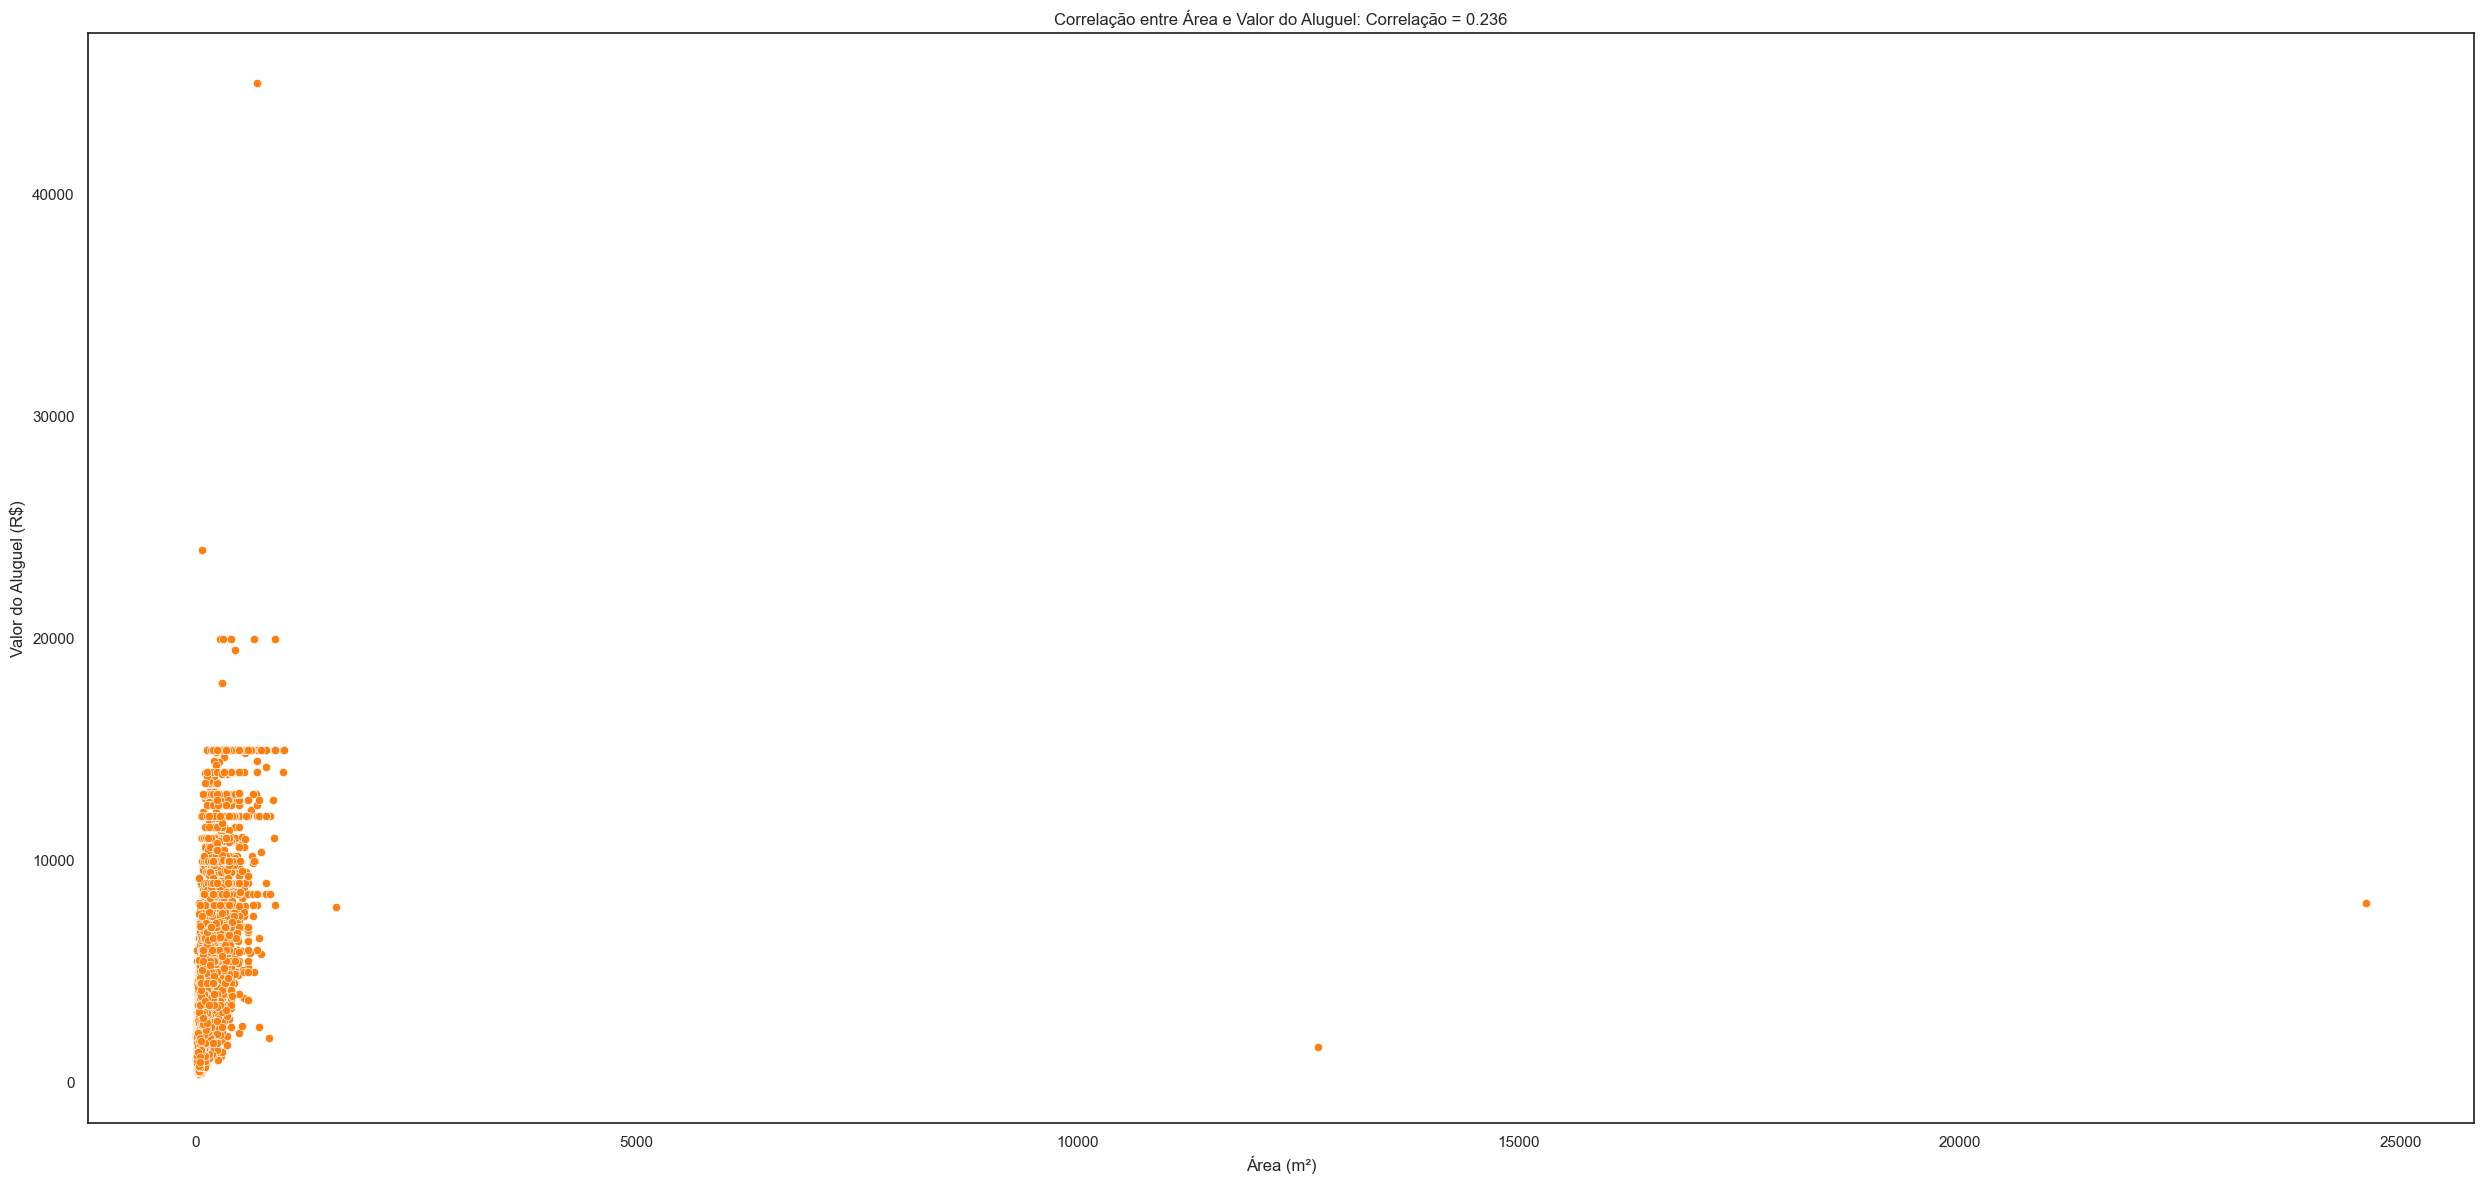

In [142]:
# Calculando o coeficiente de correlação entre 'area' e 'rent amount'
question_1 = data['area'].corr(data['rent amount'])

sns.scatterplot(x = 'area', y = 'rent amount', data = data, color = cor2)

# Título e labels
plt.title(f'Correlação entre Área e Valor do Aluguel: Correlação = {round(question_1, 3)}')
plt.xlabel('Área (m²)')
plt.ylabel('Valor do Aluguel (R$)')

plt.tight_layout()
plt.savefig(homepath + 'reports/figures/pergunta1.png')

- Esse valor corresponde a uma correlação positiva fraca entre Área e Valor do Aluguel. Embora haja alguma tendência de que imóveis maiores tenham aluguéis mais altos, outros fatores também desempenham um papel importante na determinação do valor do aluguel.

### 2. Impacto da aceitação de animais: Como a aceitação de animais (animal) afeta o valor do aluguel (rent amount)? 

Média do valor do aluguel para imóveis que aceitam animais: R$4585.85 
Média do valor do aluguel para imóveis que não aceitam animais: R$3768.86


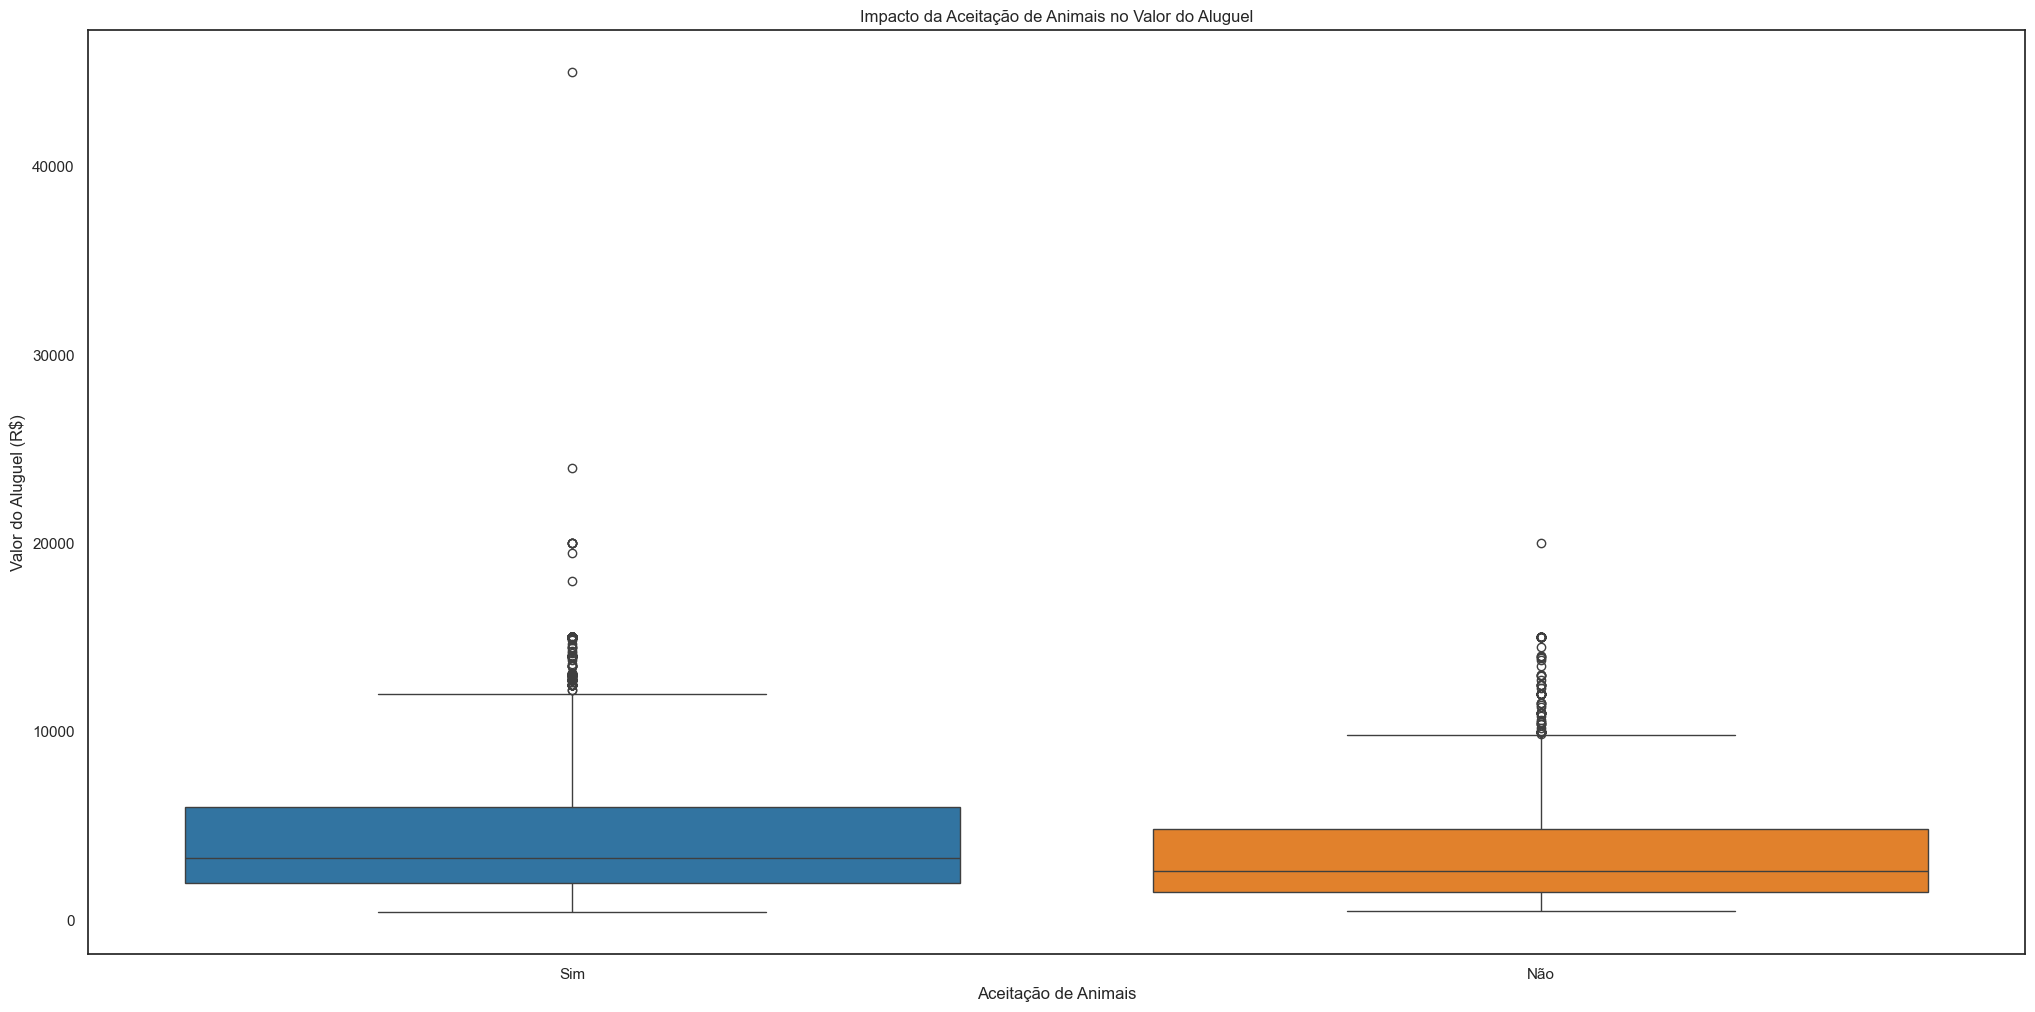

In [143]:
# Gráfico de caixa para comparar o valor do aluguel em imóveis que aceitam e não aceitam animais
sns.boxplot(x = data['animal'].replace({0: 'Não', 1: 'Sim'}), y = data['rent amount'], palette = (cor1, cor2), hue = data['animal'].replace({0: 'Não', 1: 'Sim'}))

# Título e labels
plt.title('Impacto da Aceitação de Animais no Valor do Aluguel')
plt.xlabel('Aceitação de Animais')
plt.ylabel('Valor do Aluguel (R$)')
plt.savefig(homepath + 'reports/figures/pergunta2.png')

# Calculando a média do valor do aluguel para imóveis que aceitam e não aceitam animais
mean_animal_accepted = data[data['animal'] == 1]['rent amount'].mean()
mean_animal_not_accepted = data[data['animal'] == 0]['rent amount'].mean()

print(f'Média do valor do aluguel para imóveis que aceitam animais: R${round(mean_animal_accepted, 2)} \nMédia do valor do aluguel para imóveis que não aceitam animais: R${round(mean_animal_not_accepted, 2)}')

- Média do Valor do Aluguel: A média do valor do aluguel para imóveis que aceitam animais é aproximadamente R$ 4.586. Para imóveis que não aceitam animais, a média do aluguel é cerca de R$ 3.769.

- Distribuição do Valor do Aluguel: O gráfico de caixa mostra uma distribuição ligeiramente mais alta de valores de aluguel para imóveis que aceitam animais em comparação com aqueles que não aceitam.

- Estes valores sugerem que a aceitação de animais de estimação pode estar associada a um valor de aluguel mais alto, entretanto, pela pequena variação, essa diferença pode ser motivada pela soma de outros fatores como localização e tamanho do imóvel.

### 3. Distribuição de imóveis mobiliados: Qual é a proporção de imóveis mobiliados (furniture) e não mobiliados? Existe diferença no valor do aluguel entre eles? 

furniture
Não    0.739803
Sim    0.260197
Name: proportion, dtype: float64
furniture
Não    4047.210760
Sim    5387.092288
Name: rent amount, dtype: float64


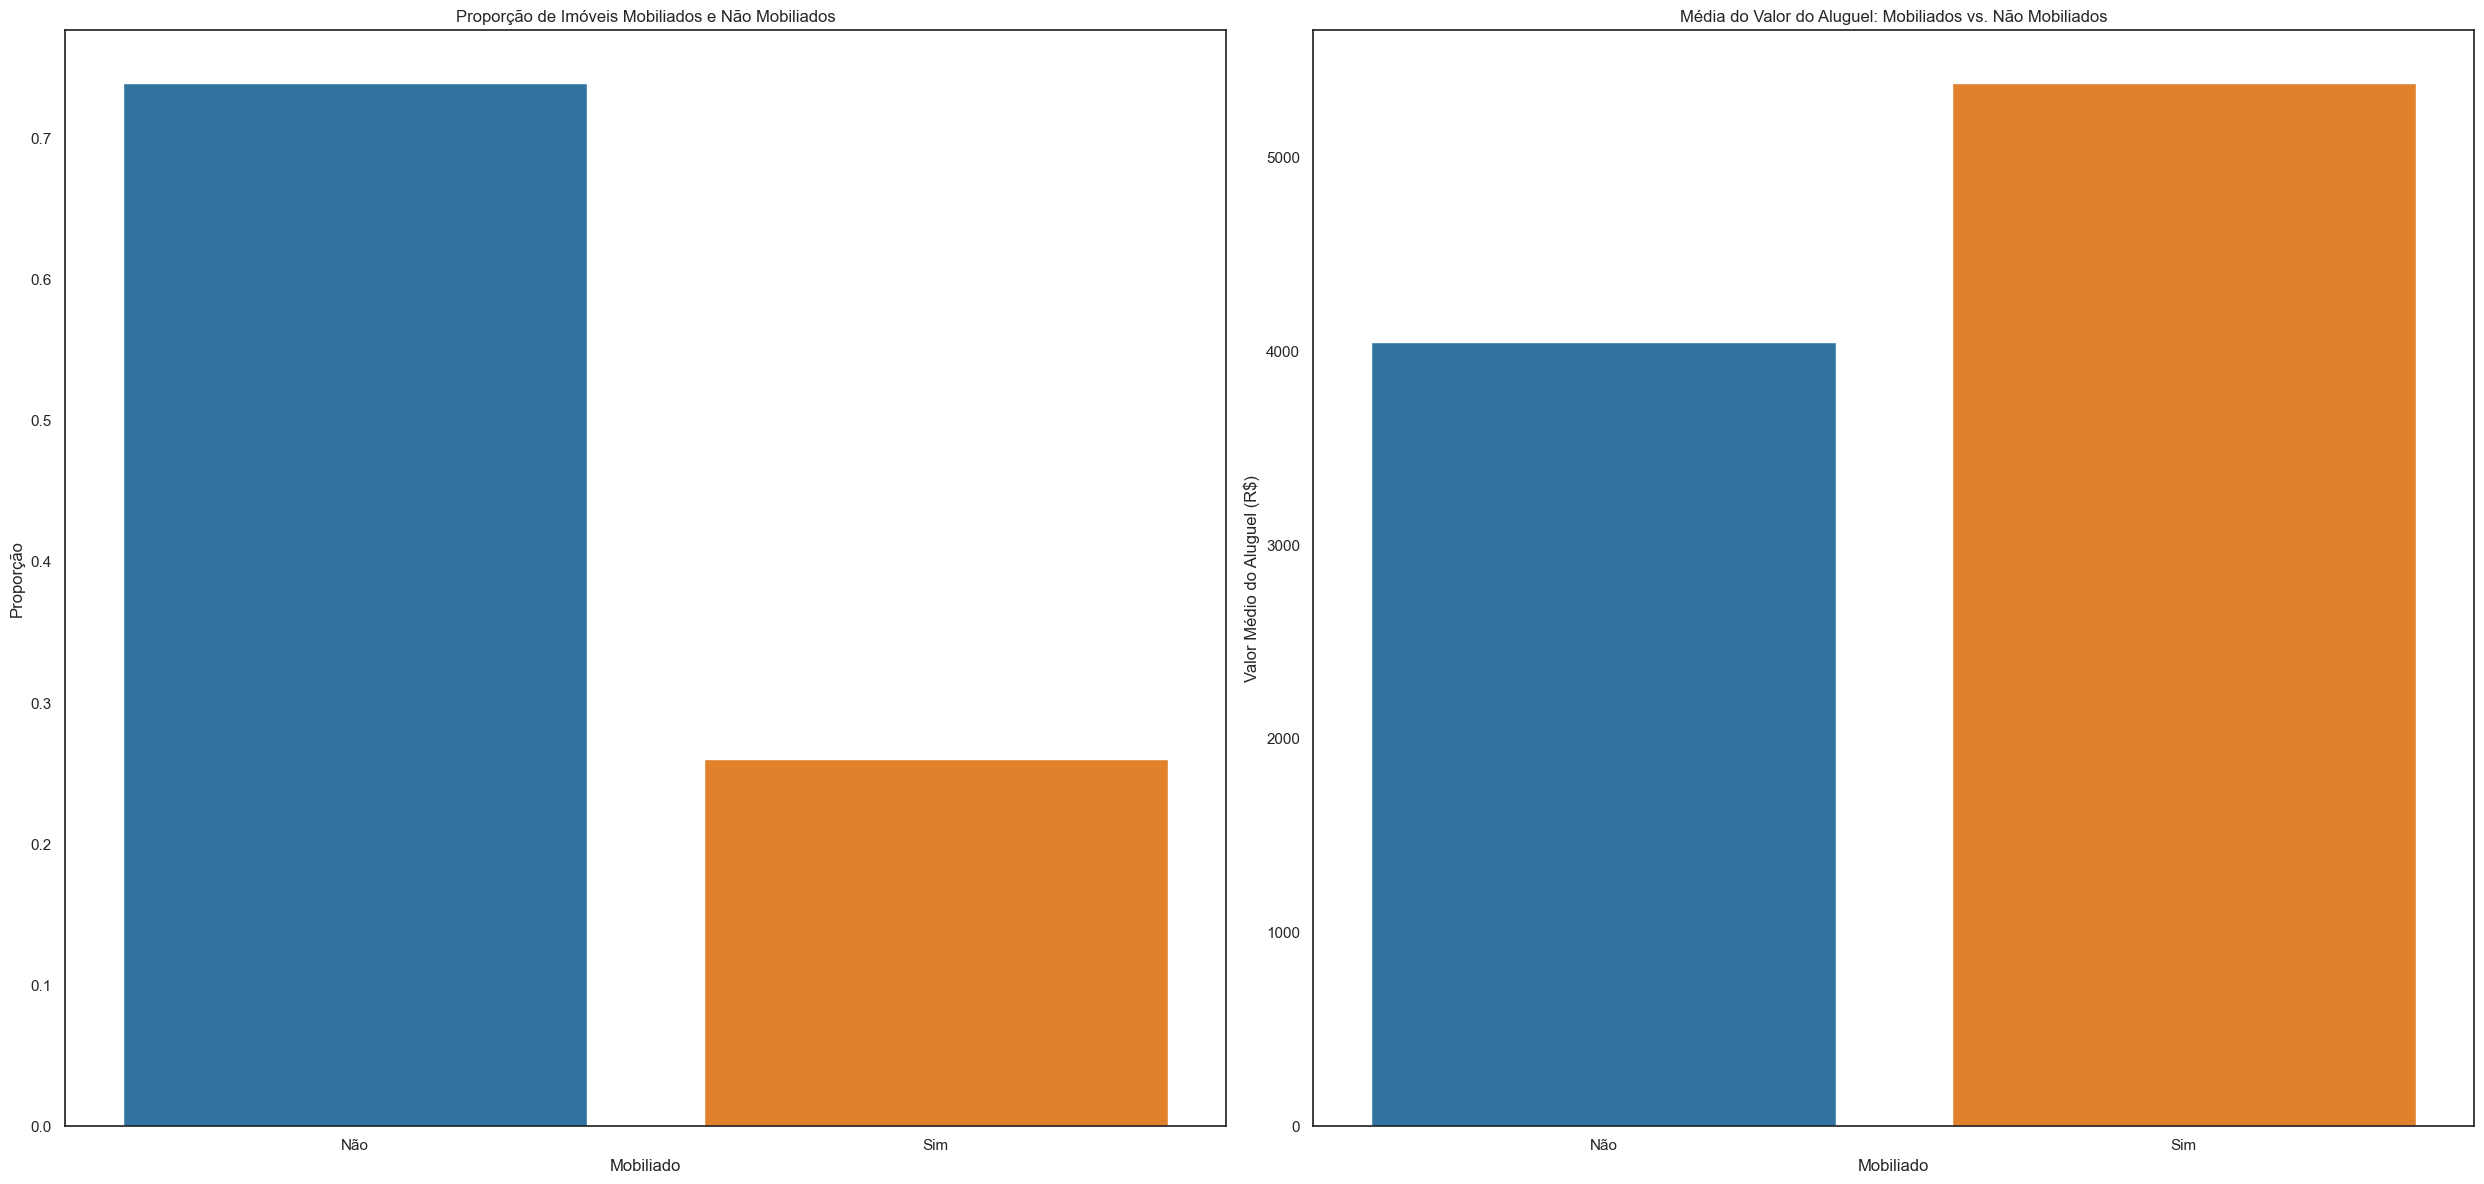

In [144]:
# Proporção de imóveis mobiliados e não mobiliados
prop_furniture = data['furniture'].map({0: 'Não', 1: 'Sim'}).value_counts(normalize = True)

# Calculando a média do valor do aluguel para imóveis mobiliados e não mobiliados
mean_rent_furniture = data.groupby(data['furniture'].map({0: 'Não', 1: 'Sim'}))['rent amount'].mean()

# Gráfico de barras para a proporção de imóveis mobiliados e não mobiliados
plt.figure()

plt.subplot(1, 2, 1)
sns.barplot(x = prop_furniture.index, y = prop_furniture.values, hue = prop_furniture.index, palette = [cor1, cor2])
plt.title('Proporção de Imóveis Mobiliados e Não Mobiliados')
plt.xlabel('Mobiliado')
plt.ylabel('Proporção')

# Gráfico de barras para a média do valor do aluguel de imóveis mobiliados e não mobiliados
plt.subplot(1, 2, 2)
sns.barplot(x = mean_rent_furniture.index, y = mean_rent_furniture.values, hue = mean_rent_furniture.index ,palette = [cor1, cor2])
plt.title('Média do Valor do Aluguel: Mobiliados vs. Não Mobiliados')
plt.xlabel('Mobiliado')
plt.ylabel('Valor Médio do Aluguel (R$)')

plt.tight_layout();
print(prop_furniture)
print(mean_rent_furniture)

plt.savefig(homepath + 'reports/figures/pergunta3.png')

Proporção de Imóveis Mobiliados e Não Mobiliados:

- Cerca de 73.98% dos imóveis não são mobiliados.
- Aproximadamente 26.02% dos imóveis são mobiliados.

Diferença no Valor do Aluguel entre Imóveis Mobiliados e Não Mobiliados:
    
- A média do valor do aluguel para imóveis não mobiliados é de aproximadamente R$ 4.047.
- Para imóveis mobiliados, a média do valor do aluguel é de cerca de R$ 5.387.

Isso sugere que, em média, imóveis mobiliados têm um valor de aluguel mais alto em comparação com imóveis não mobiliados, o que faz sentido.

### 4. Análise de outliers no valor do IPTU (property tax): Existem outliers significativos no valor do IPTU? Como eles impactam o valor total (total)?

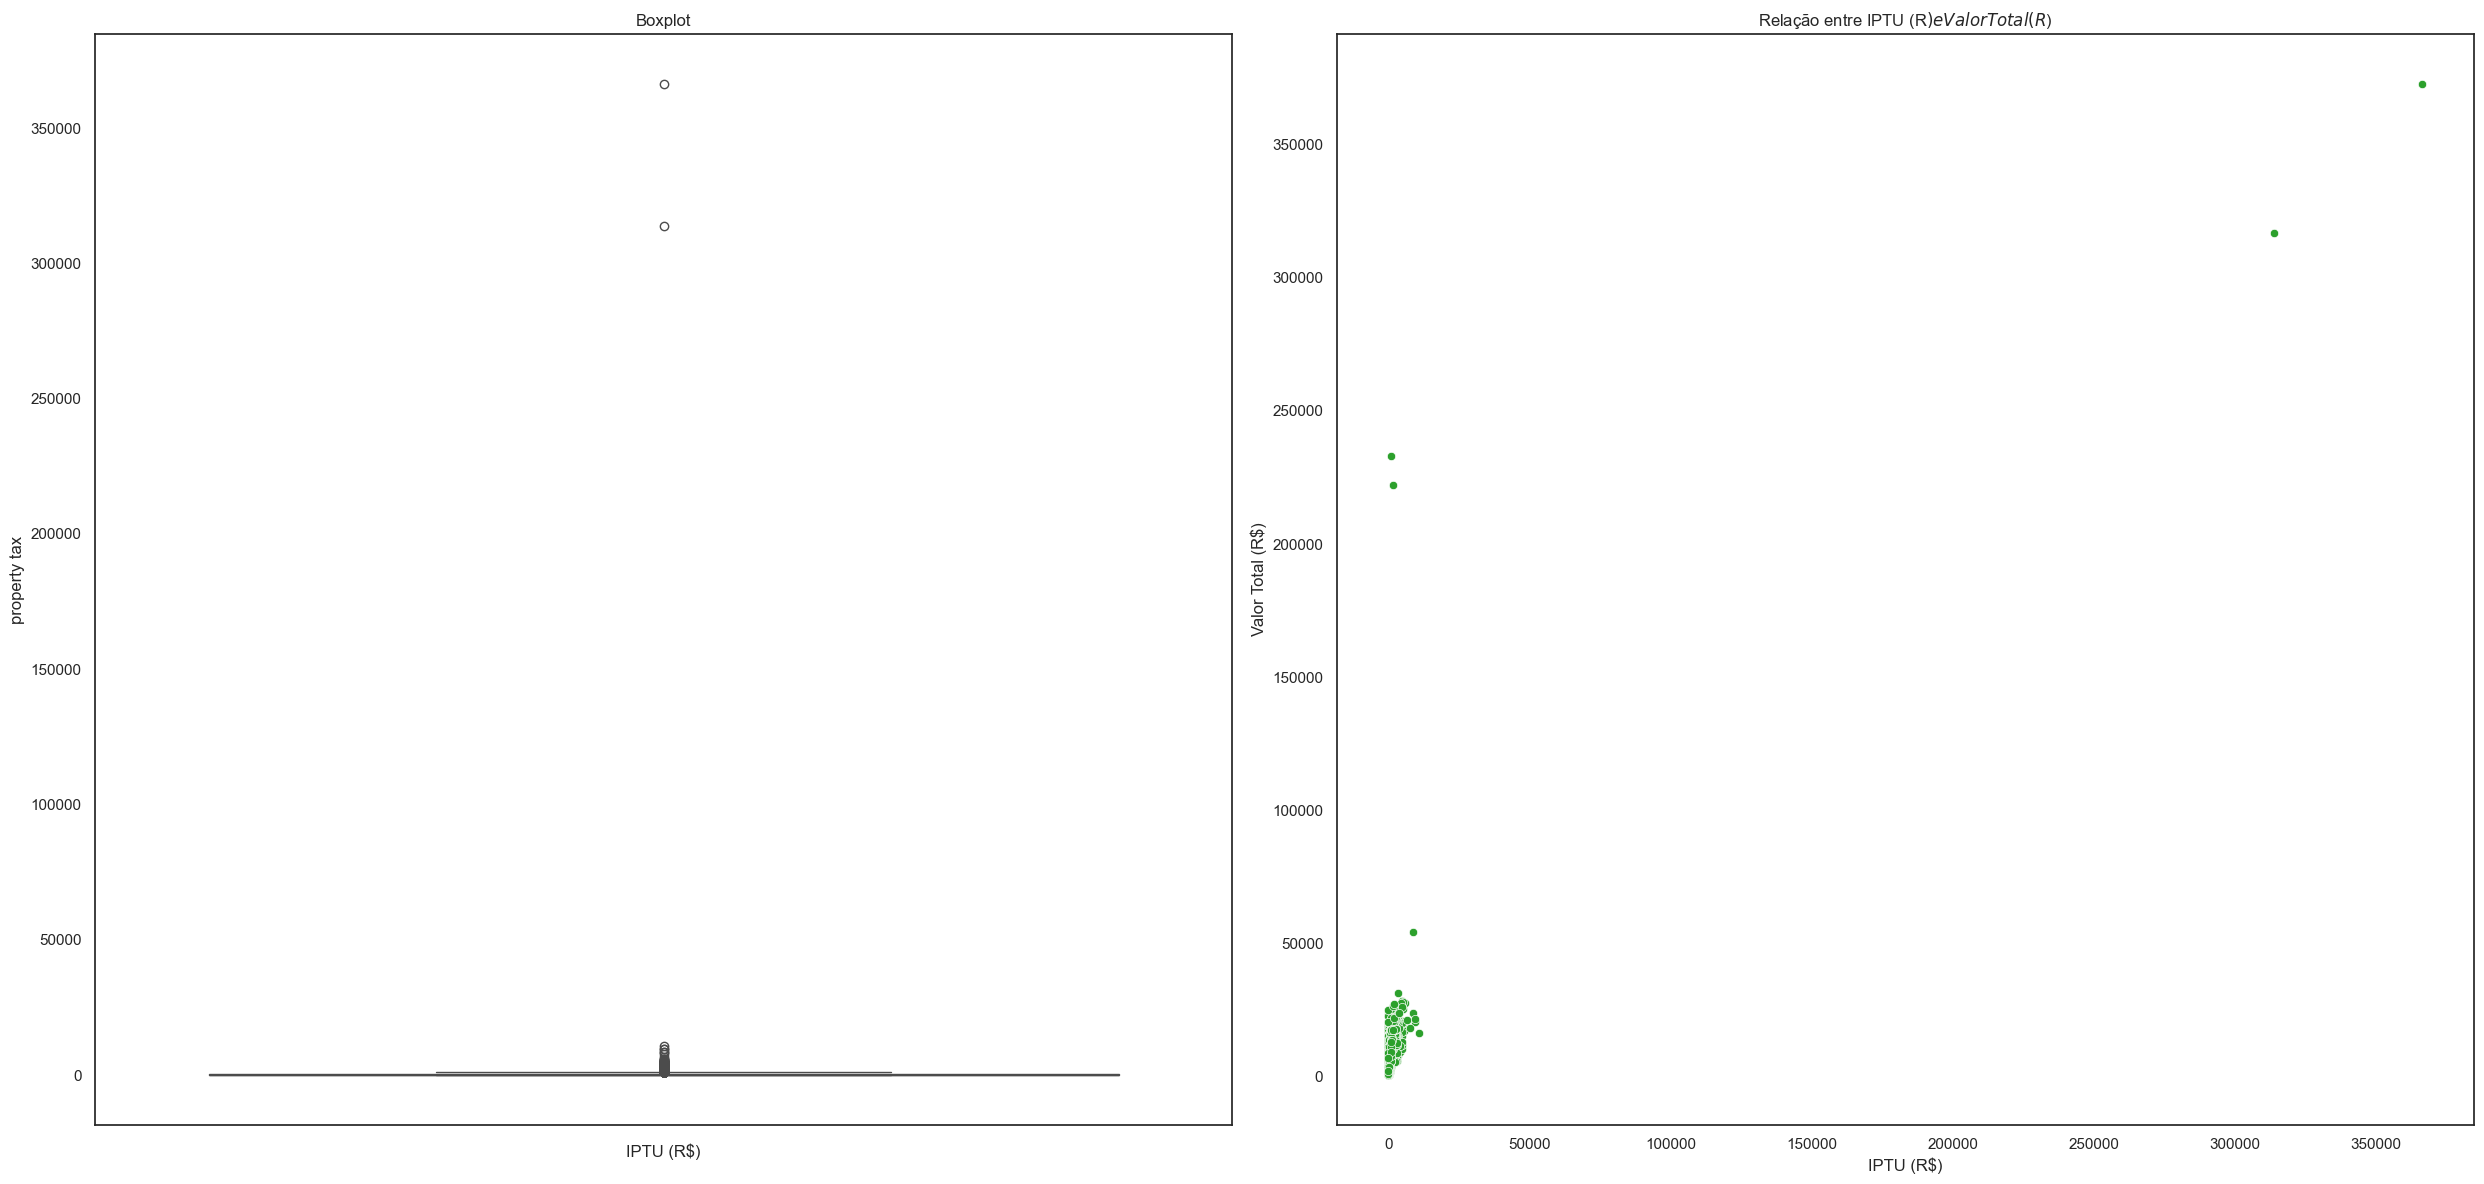

In [145]:
plt.figure()

# Boxplot do IPTU
plt.subplot(1, 2, 1)
sns.boxplot(data['property tax'])
plt.title('Boxplot')
plt.xlabel('IPTU (R$)')

# Gráfico de dispersão entre IPTU e valor total
plt.subplot(1, 2, 2)
sns.scatterplot(x = 'property tax', y = 'total', data = data, color = cor3)
plt.title('Relação entre IPTU (R$) e Valor Total (R$)')
plt.xlabel('IPTU (R$)')
plt.ylabel('Valor Total (R$)')

plt.tight_layout();
plt.savefig(homepath + 'reports/figures/pergunta4.png')

In [146]:
Q1_iptu = data['property tax'].quantile(0.25)
Q3_iptu = data['property tax'].quantile(0.75)
IQR_iptu = Q3_iptu - Q1_iptu
outlier_threshold_iptu_upper = Q3_iptu + 1.5 * IQR_iptu

# Filtrando outliers
outliers_iptu = data[data['property tax'] > outlier_threshold_iptu_upper]

# Proporção de outliers no IPTU
proporcao_outliers_iptu = len(outliers_iptu) / len(data)
print(f'A proporção de imóveis considerados como outliers no iptu é de {proporcao_outliers_iptu*100}%.')

A proporção de imóveis considerados como outliers no iptu é de 8.68421052631579%.


Boxplot do IPTU:
- O boxplot mostra a presença de diversos outliers no valor do IPTU, indicando que há valores significativamente mais altos do que a maioria. Esses IDs já foram identificados anteriormente.

Relação entre IPTU e Valor Total:
- O gráfico de dispersão mostra que, embora a maioria dos imóveis tenha valores de IPTU e totais moderados, existem alguns casos com IPTU extremamente alto.

Proporção de Outliers no IPTU:
- A proporção de imóveis considerados como outliers no valor do IPTU é aproximadamente 8.68%.

Isso indica que os outliers no valor do IPTU têm um impacto significativo no valor total, especialmente em imóveis com taxas de IPTU muito altas. 
- Obs: Imóveis em áreas de alto valor imobiliário demandam uma análise mais detalhada futuramente, com mais dados.

### 5. Influência do número de vagas de estacionamento: Como o número de vagas de estacionamento (parking spaces) influencia o valor do aluguel (rent amount)? 

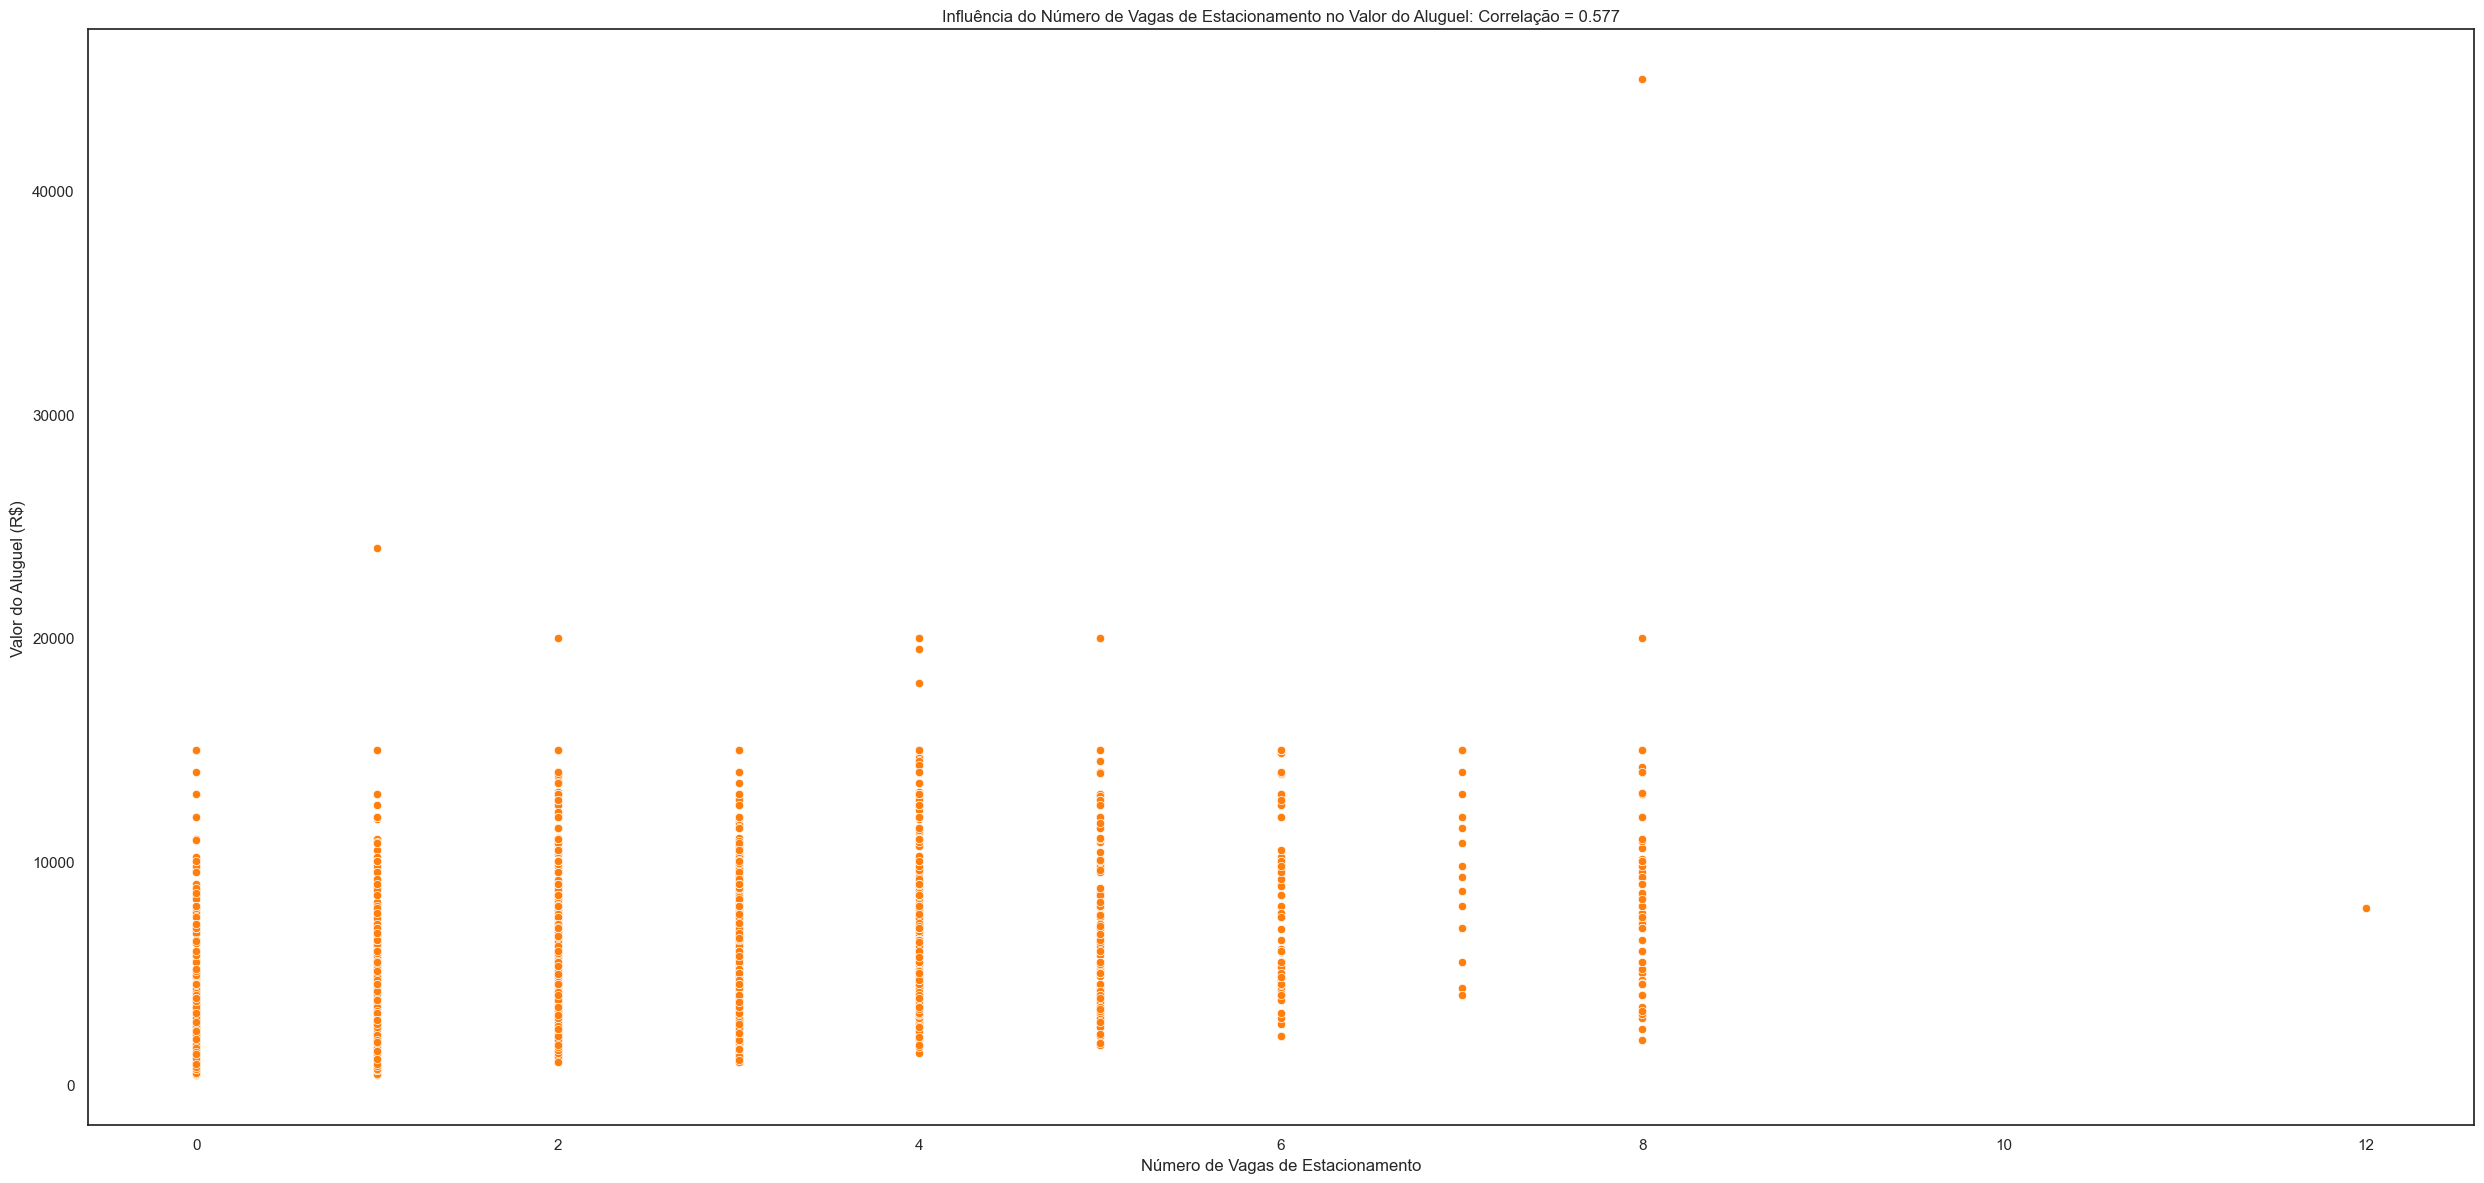

In [147]:
correlation_parking_rent = data['parking spaces'].corr(data['rent amount'])

# Criando um gráfico de dispersão para visualizar a relação entre o número de vagas de estacionamento e o valor do aluguel
sns.scatterplot(x = 'parking spaces', y = 'rent amount', data = data, color = cor2)

# Título e labels
plt.title(f'Influência do Número de Vagas de Estacionamento no Valor do Aluguel: Correlação = {round(correlation_parking_rent, 3)}')
plt.xlabel('Número de Vagas de Estacionamento')
plt.ylabel('Valor do Aluguel (R$)')

plt.tight_layout();
plt.savefig(homepath + 'reports/figures/pergunta5.png')

O coeficiente de correlação entre o número de vagas de estacionamento e o valor do aluguel é de aproximadamente 0.577. Este valor indica uma correlação positiva moderada, sugerindo que imóveis com mais vagas de estacionamento tendem a ter aluguéis mais altos, vale ressaltar que outros fatores também influenciam no valor do aluguel.

### 6. Relação entre andar (floor) e valor do aluguel: Existe alguma tendência no valor do aluguel com base no andar do imóvel?

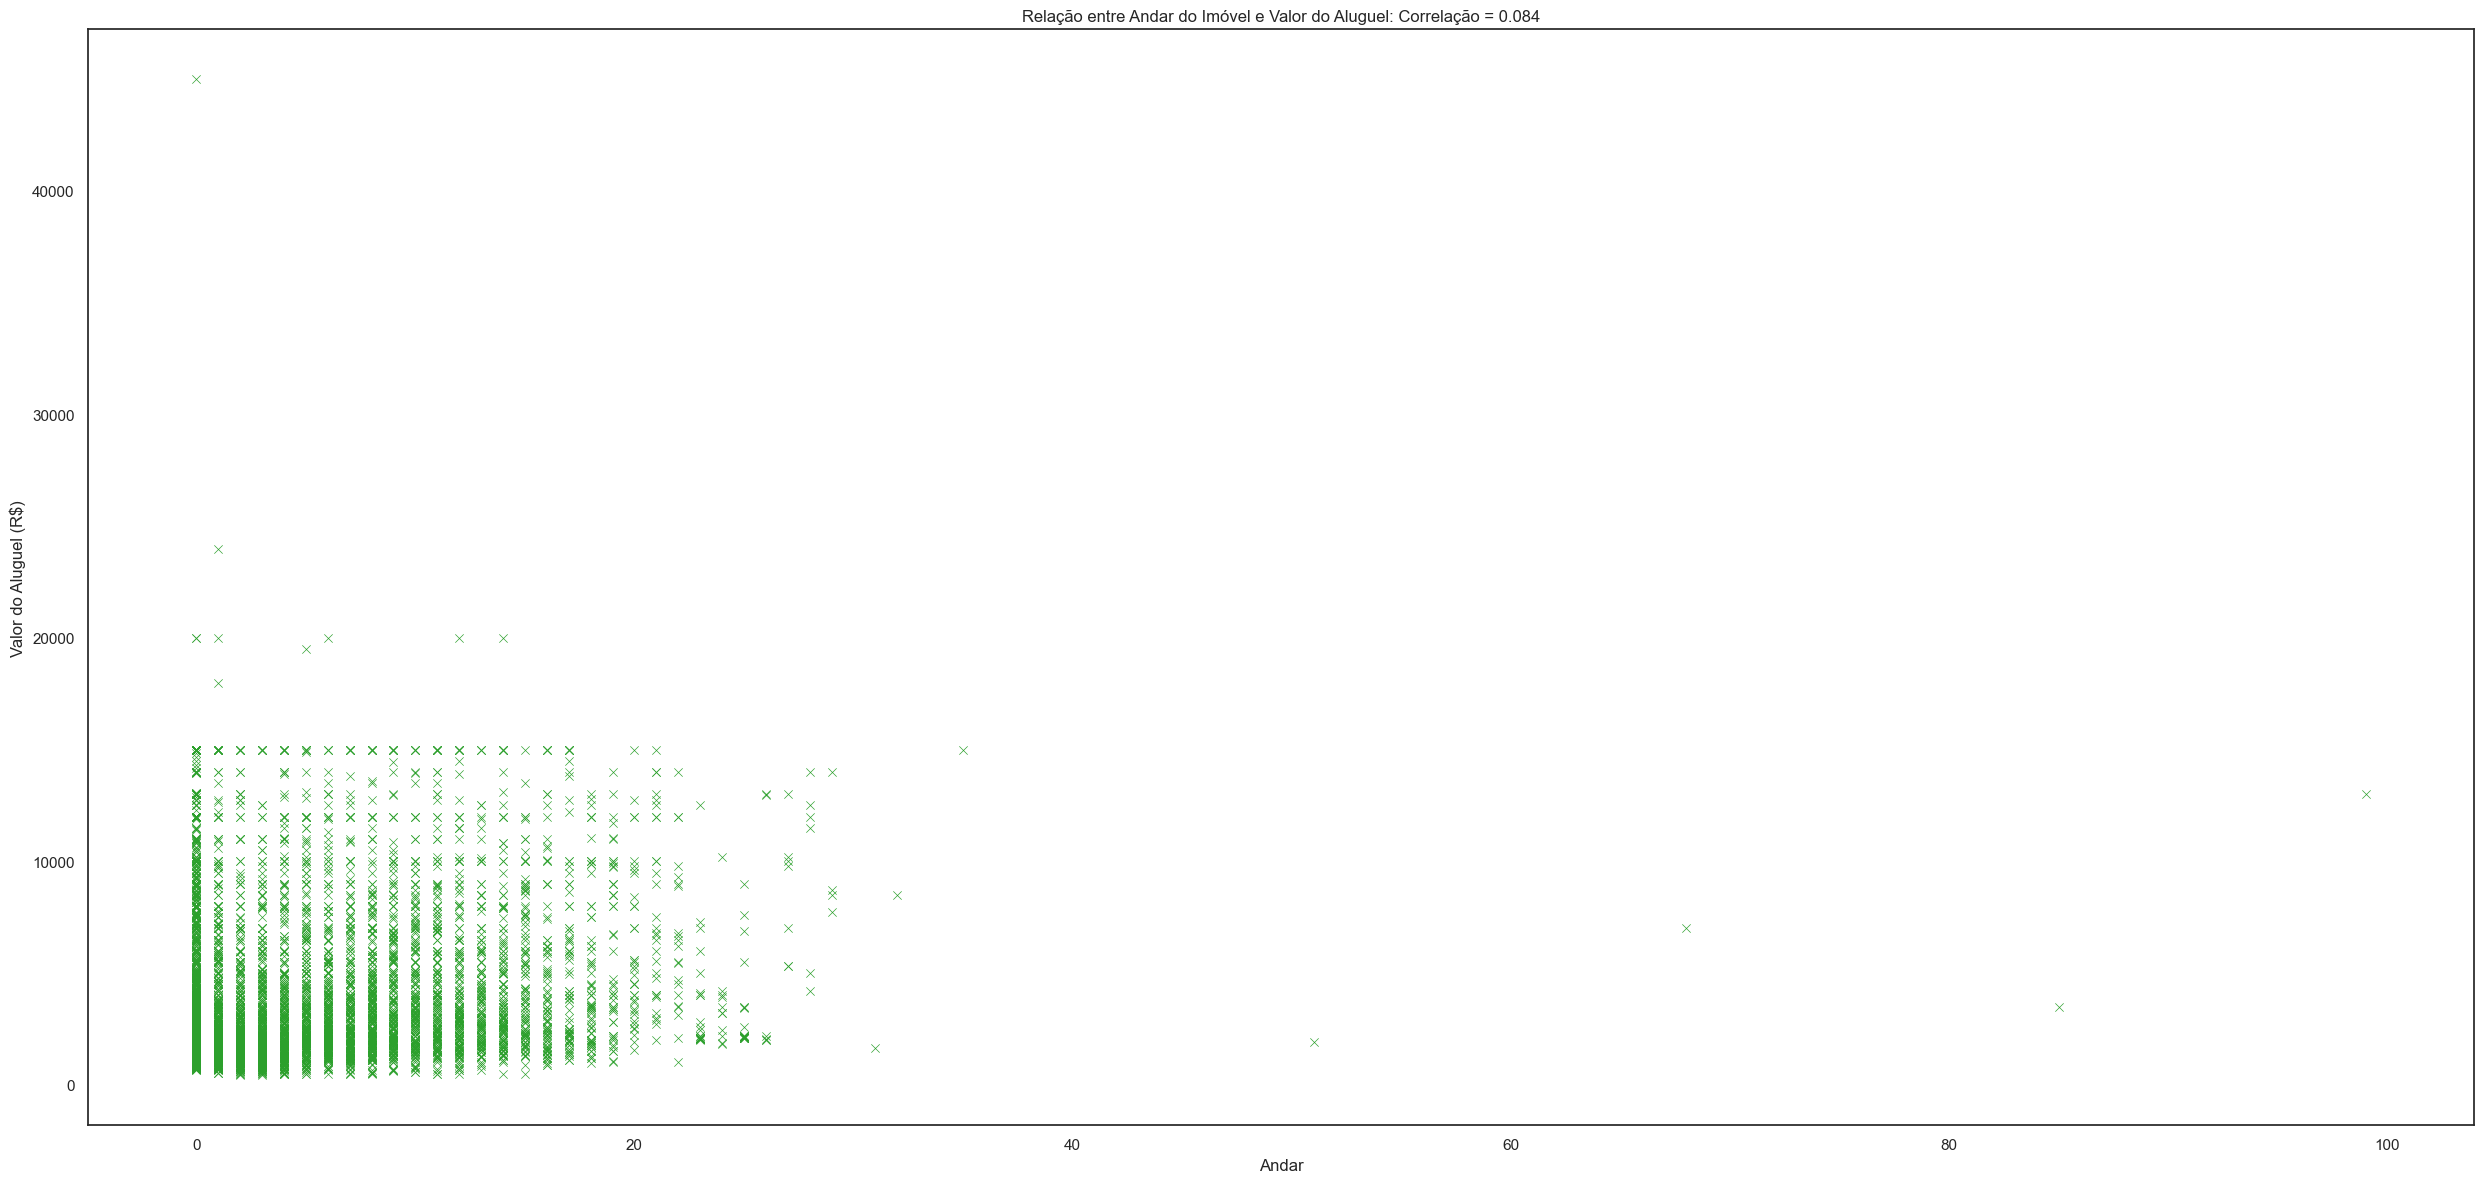

In [148]:
correlation_floor_rent = data['floor'].corr(data['rent amount'])
sns.scatterplot(x = 'floor', y = 'rent amount', data = data, color = cor3, marker = 'x')

# Título e labels
plt.title(f'Relação entre Andar do Imóvel e Valor do Aluguel: Correlação = {round(correlation_floor_rent, 3)}')
plt.xlabel('Andar')
plt.ylabel('Valor do Aluguel (R$)')

plt.tight_layout();
plt.savefig(homepath + 'reports/figures/pergunta6.png')

O coeficiente de correlação entre o andar do imóvel e o valor do aluguel é de aproximadamente 0.084, uma correlação positiva muito fraca, sugerindo que o andar do imóvel, por si só, não é determinante para o valor do aluguel.

### 7. Variação das taxas de condomínio (HOA) por cidade: Como as taxas de condomínio variam entre diferentes cidades?

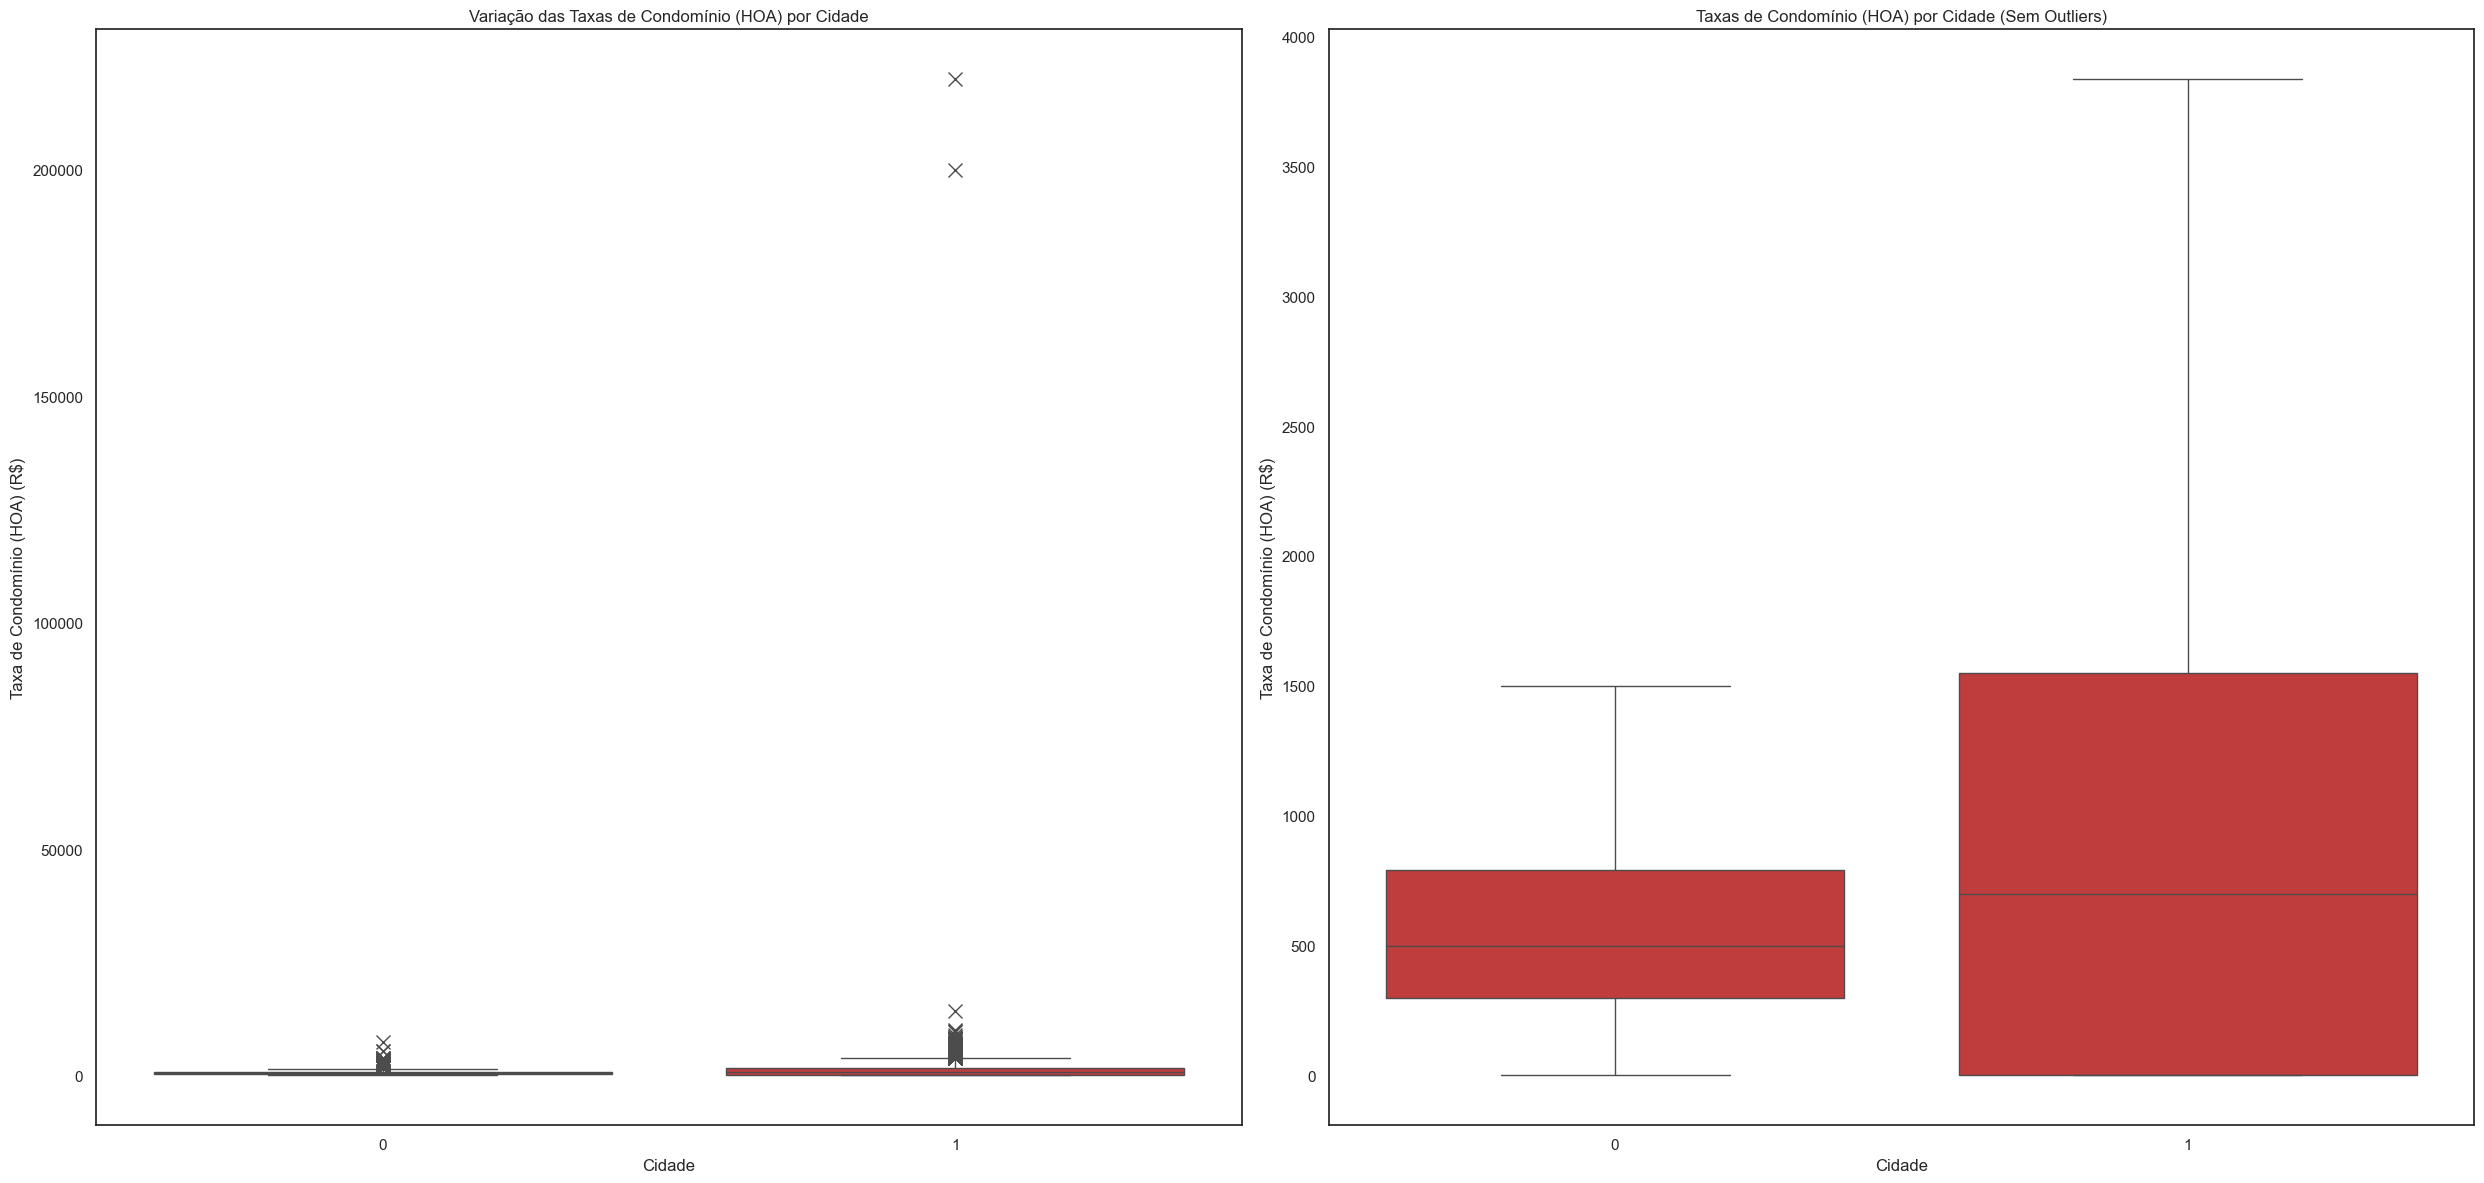

In [149]:
flierprops = dict(marker='x', markersize = 10)

plt.figure()

plt.subplot(1, 2, 1)
sns.boxplot(x = 'city', y = 'hoa', data = data, flierprops = flierprops, color = cor4)

# Título e labels
plt.title('Variação das Taxas de Condomínio (HOA) por Cidade')
plt.xlabel('Cidade')
plt.ylabel('Taxa de Condomínio (HOA) (R$)')

plt.subplot(1, 2, 2)
sns.boxplot(x = 'city', y = 'hoa', data = data, showfliers = False, color = cor4)

# Título e labels
plt.title('Taxas de Condomínio (HOA) por Cidade (Sem Outliers)')
plt.xlabel('Cidade')
plt.ylabel('Taxa de Condomínio (HOA) (R$)')

plt.tight_layout();
plt.savefig(homepath + 'reports/figures/pergunta7.png')

As diferenças nas medianas, a amplitude dos quartis e a presença de outliers podem indicar variações significativas nas taxas de condomínio entre as cidades codificadas.


### 8. Correlação entre número de banheiros e valor do aluguel: Qual é a relação entre o número de banheiros (bathroom) e o valor do aluguel (rent amount)? 


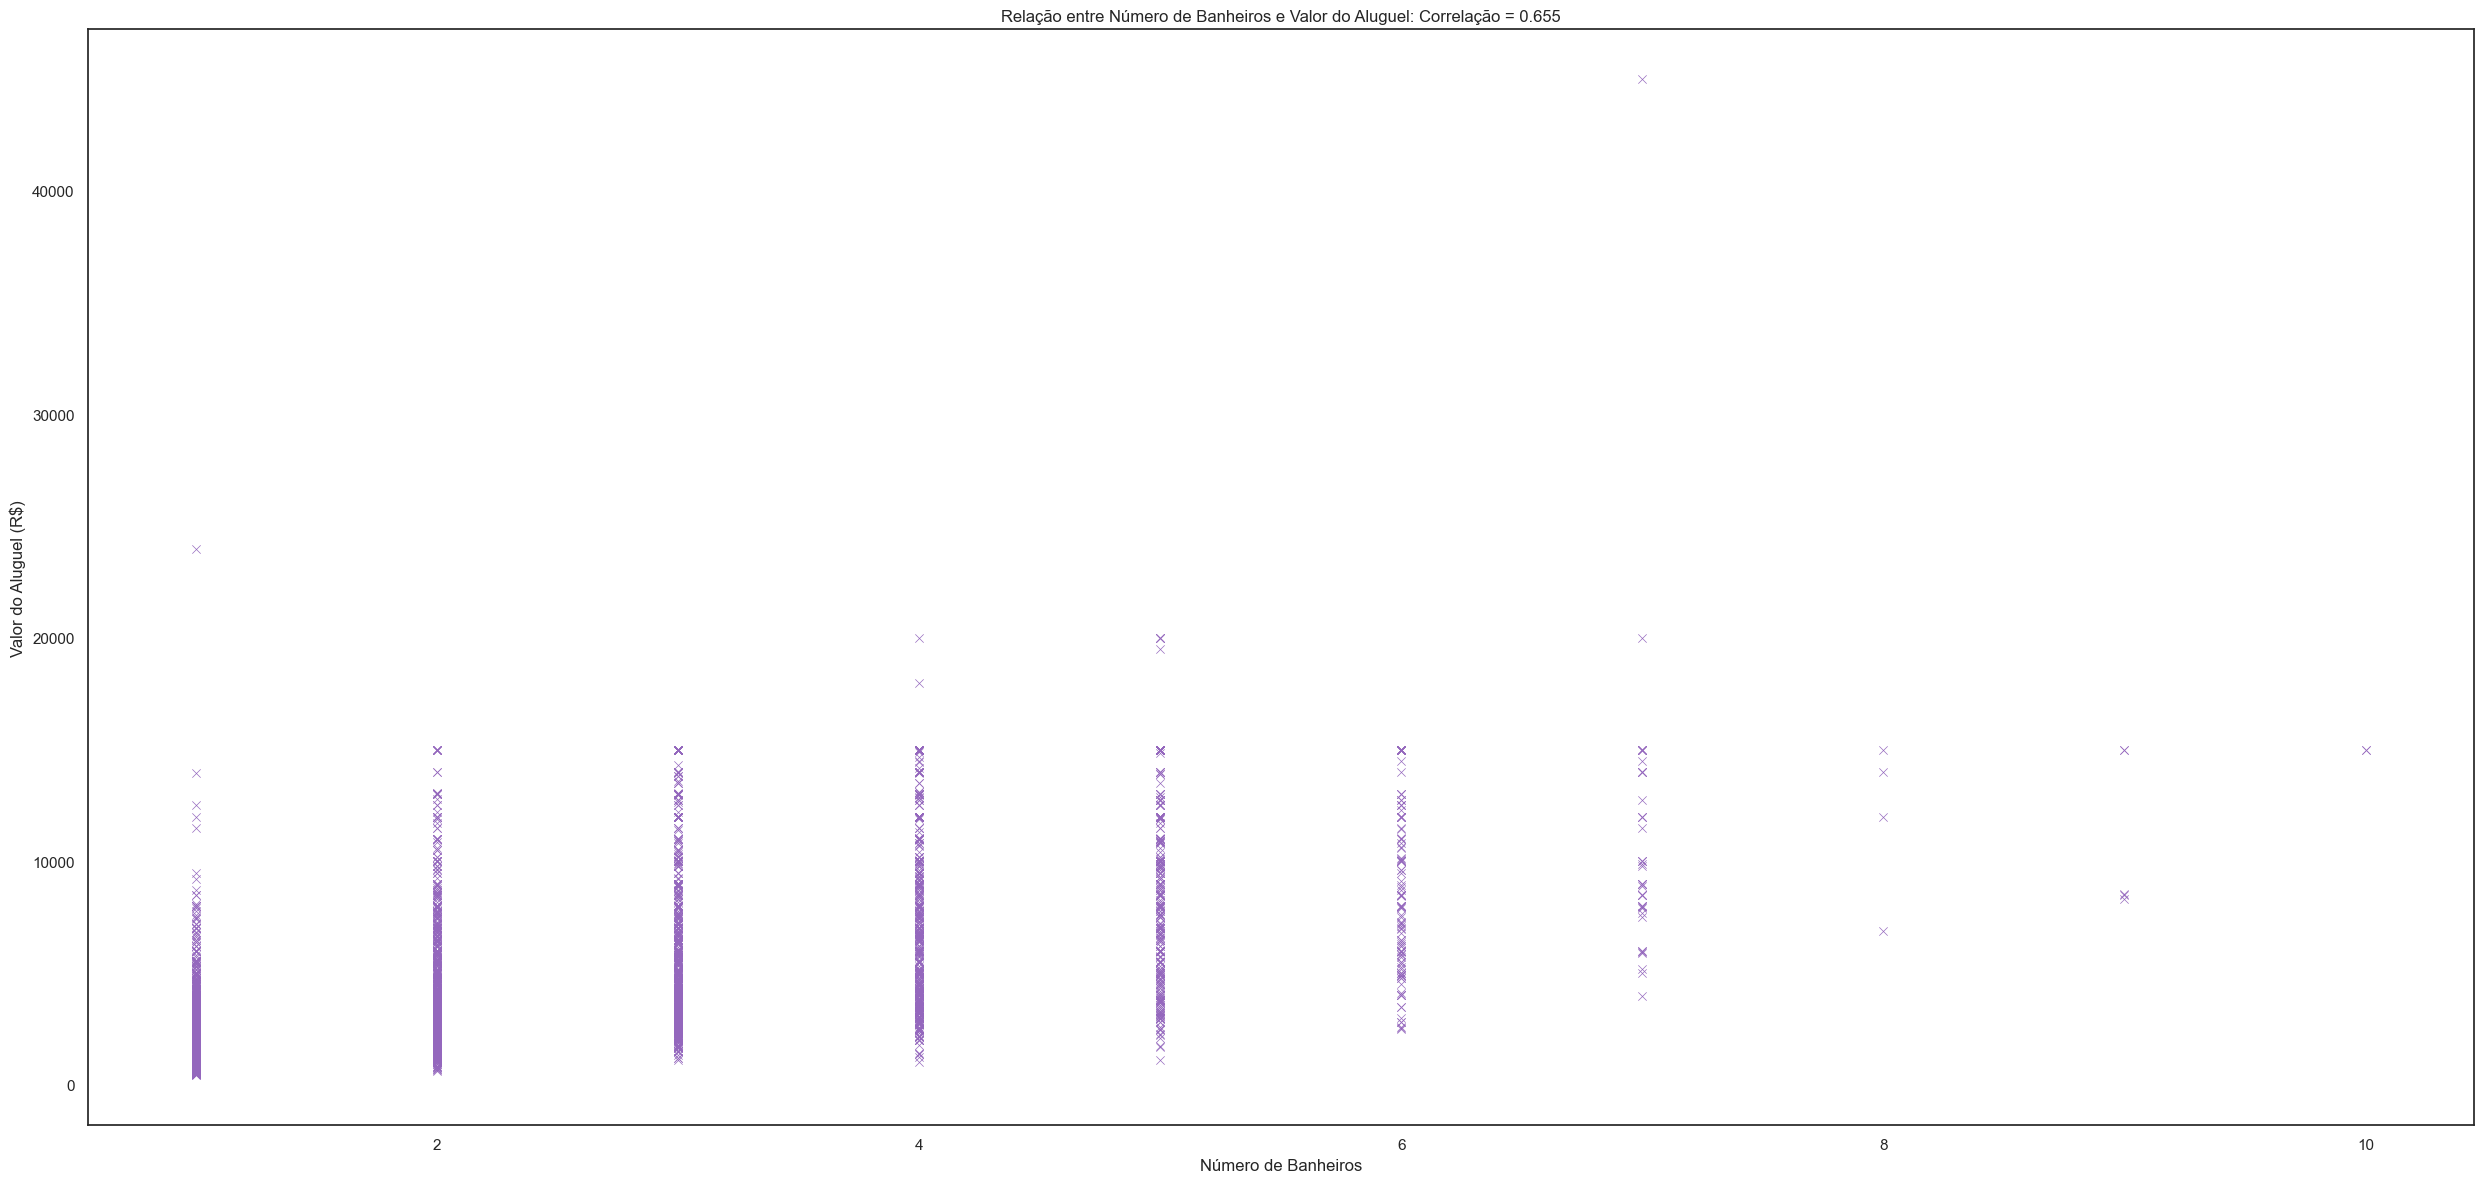

In [150]:
correlation_bathroom_rent = data['bathroom'].corr(data['rent amount'])

sns.scatterplot(x = 'bathroom', y = 'rent amount', data = data, marker = 'x', color = cor5)

# Título e labels
plt.title(f'Relação entre Número de Banheiros e Valor do Aluguel: Correlação = {round(correlation_bathroom_rent, 3)}')
plt.xlabel('Número de Banheiros')
plt.ylabel('Valor do Aluguel (R$)')

plt.tight_layout();
plt.savefig(homepath + 'reports/figures/pergunta8.png')

O coeficiente de correlação entre o número de banheiros e o valor do aluguel é de aproximadamente 0.655. Este valor indica uma correlação positiva moderada a forte, sugerindo que imóveis com mais banheiros tendem a ter aluguéis mais altos. Este padrão pode ser atribuído ao fato de que imóveis maiores, que geralmente têm mais banheiros, também tendem a ter um valor de aluguel mais elevado.


### 9. Variação do valor do aluguel por cidade: Como o valor do aluguel (rent amount) varia entre diferentes cidades? 

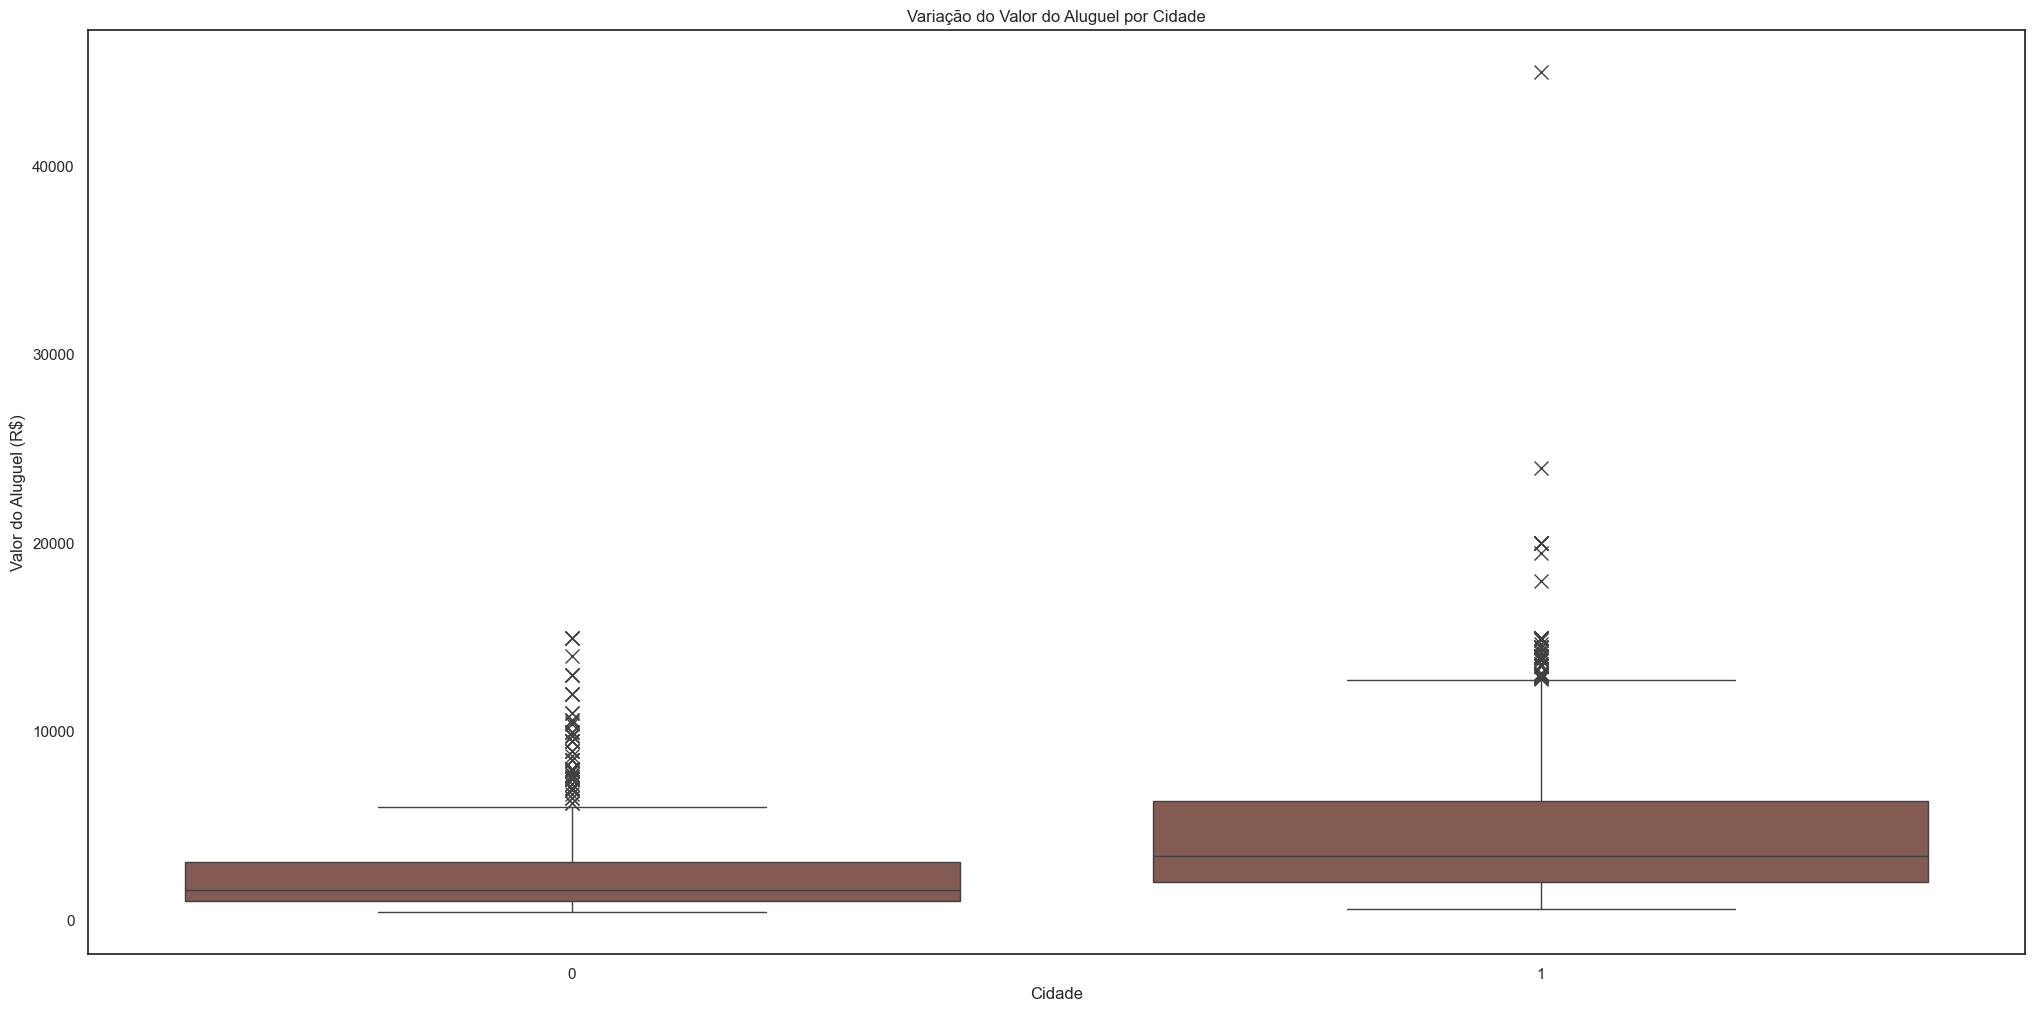

In [151]:
sns.boxplot(x = 'city', y = 'rent amount', data = data, flierprops = flierprops, color = cor6)

# Título e labels
plt.title('Variação do Valor do Aluguel por Cidade')
plt.xlabel('Cidade')
plt.ylabel('Valor do Aluguel (R$)')
plt.savefig(homepath + 'reports/figures/pergunta9.png')

As variações nas medianas, a amplitude dos interquartis e a presença de outliers podem indicar diferenças significativas nos custos de aluguel entre as cidades.


### 10. Distribuição do custo total (total): Como é a distribuição do custo total dos aluguéis? 

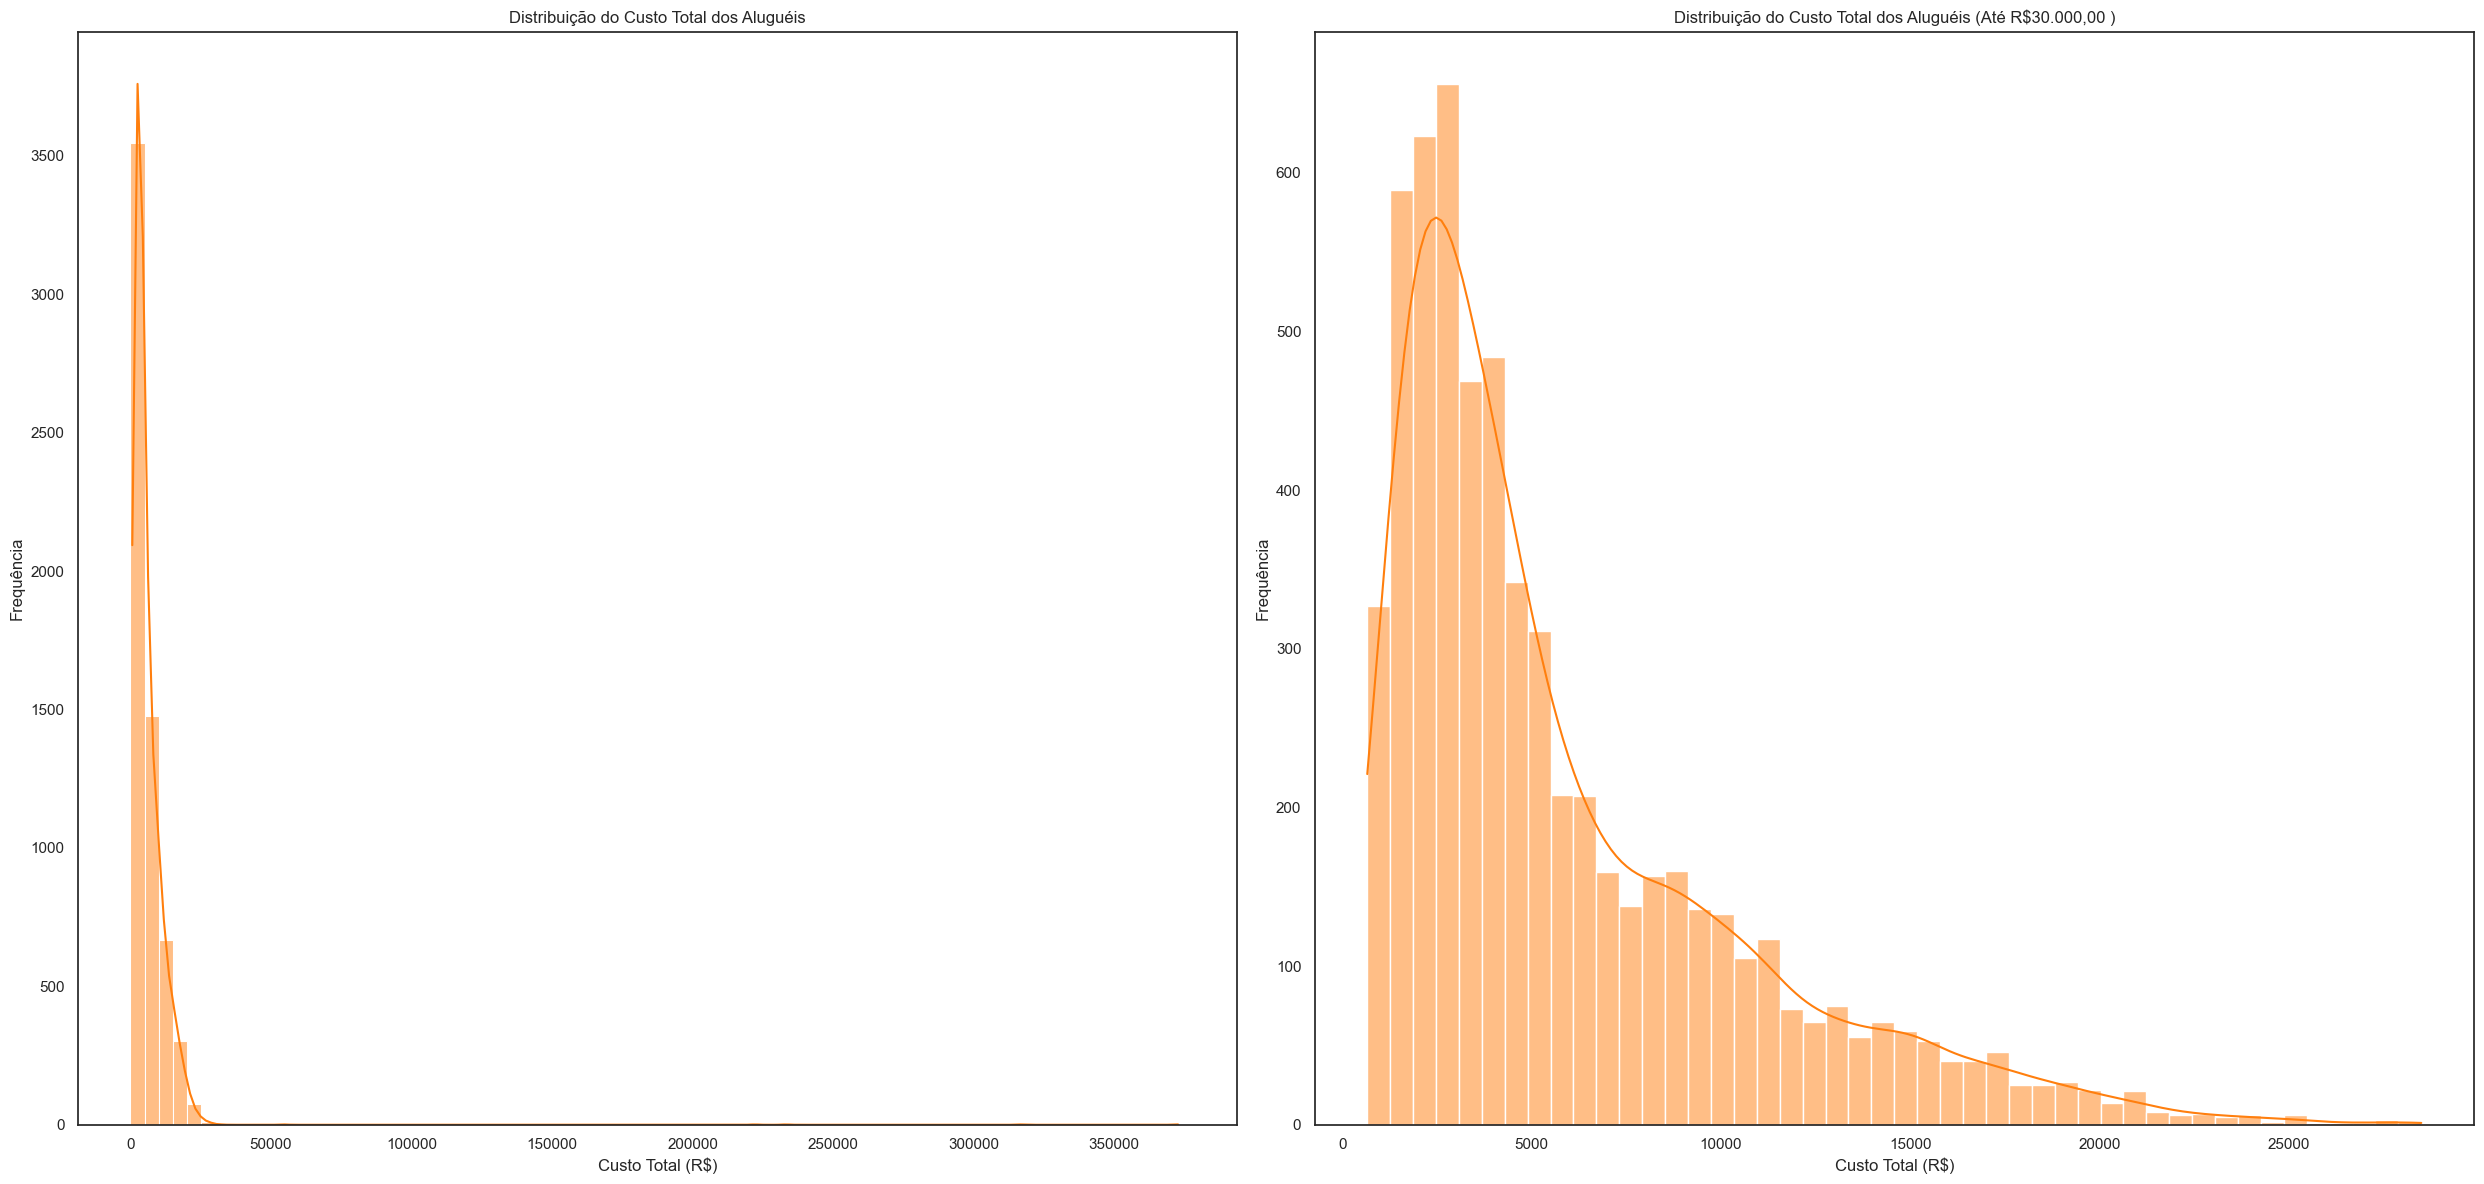

In [152]:
bin_size = 5000
bins_range = range(0, int(data['total'].max() + bin_size), bin_size)


plt.figure()

plt.subplot(1, 2, 1)
sns.histplot(data['total'], bins = bins_range, kde = True, color = cor2)

# Título e labels
plt.title('Distribuição do Custo Total dos Aluguéis')
plt.xlabel('Custo Total (R$)')
plt.ylabel('Frequência')

plt.subplot(1, 2, 2)
sns.histplot(data[data['total'] <= 30000]['total'], kde = True, color = cor2)
plt.title('Distribuição do Custo Total dos Aluguéis (Até R$30.000,00 )')
plt.xlabel('Custo Total (R$)')
plt.ylabel('Frequência')

plt.tight_layout();
plt.savefig(homepath + 'reports/figures/pergunta10.png')

Concentração em Valores Mais Baixos:
- A maioria dos aluguéis está concentrada nas faixas de preço mais baixas, conforme indicado pelas barras mais altas do lado esquerdo dos gráficos.

Decréscimo na Frequência com o Aumento do Custo:
- A frequência de aluguéis diminui à medida que o custo total aumenta, o que é característico de uma distribuição assimétrica à direita.

Outliers:
- Há uma presença visível de outliers em faixas de custo mais altas.


### 11. Proporção do seguro incêndio no custo total: Qual é a proporção do seguro incêndio (fire insurance) no custo total (total)? 


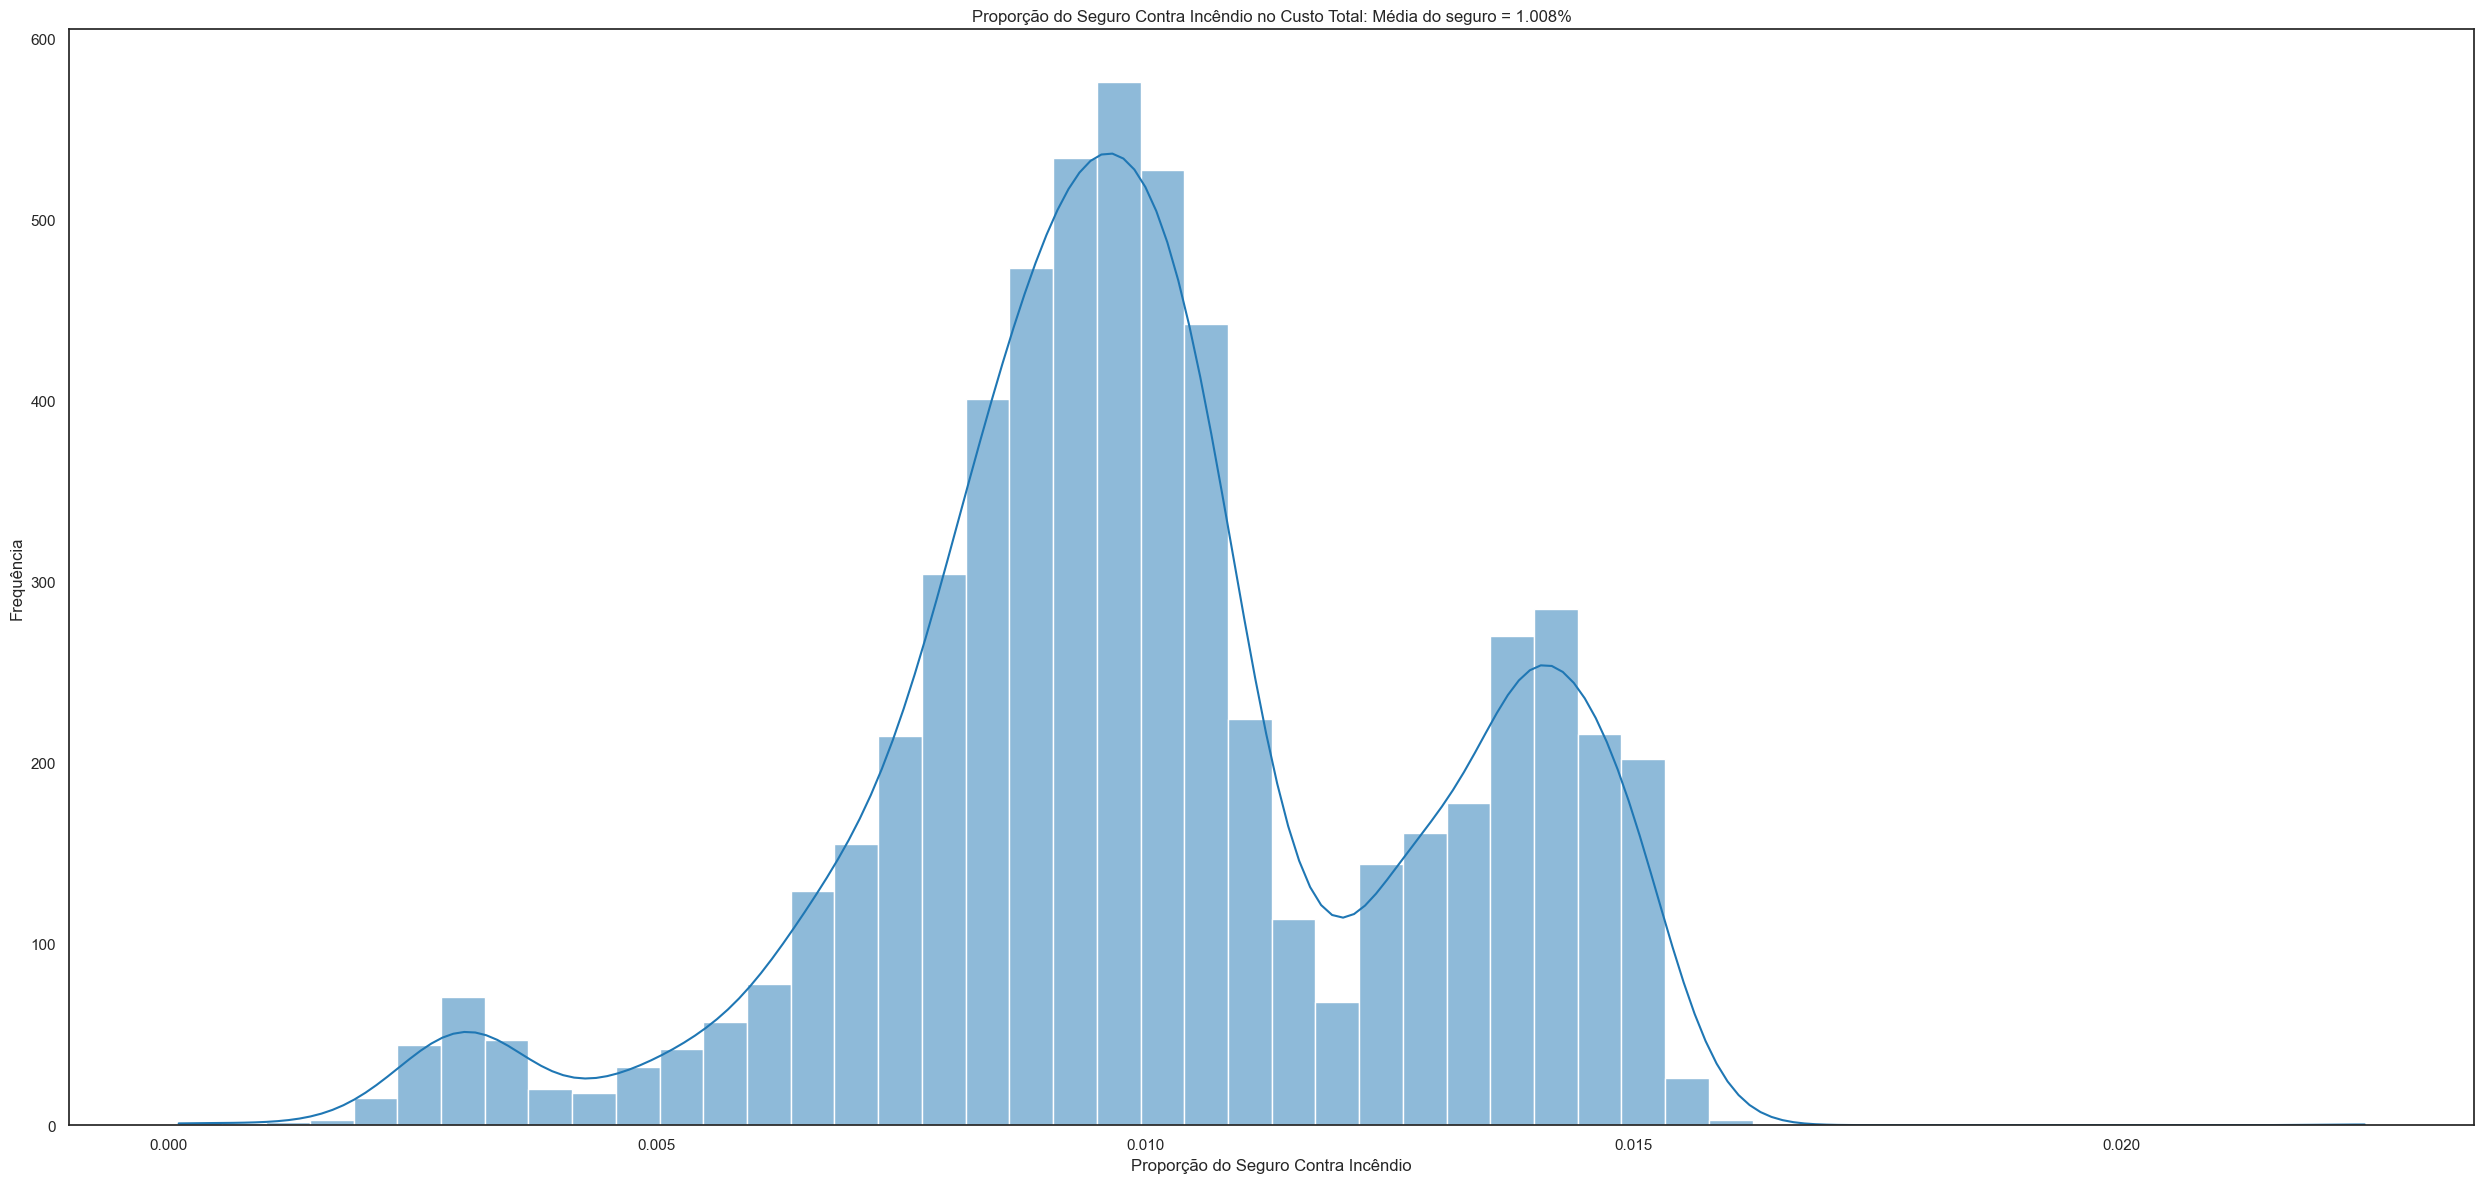

In [153]:
data['fire_insurance_proportion'] = data['fire insurance'] / data['total']
fire_insurance_proportion_mean = data['fire_insurance_proportion'].mean()

sns.histplot(data['fire_insurance_proportion'], bins = 50, kde = True, color = cor1)

# Título e labels
plt.title(f'Proporção do Seguro Contra Incêndio no Custo Total: Média do seguro = {round(fire_insurance_proportion_mean*100, 3)}%')
plt.xlabel('Proporção do Seguro Contra Incêndio')
plt.ylabel('Frequência')
plt.savefig(homepath + 'reports/figures/pergunta11.png')

plt.tight_layout();

A proporção média do seguro contra incêndio no custo total é de aproximadamente 1.008%.
Concentração da Proporção:
- A maioria dos valores se concentra em proporções baixas, indicando que o seguro contra incêndio geralmente representa uma pequena fração do custo total do aluguel.

Distribuição:
- A distribuição é relativamente estreita, sugerindo que a proporção do seguro contra incêndio em relação ao custo total é bastante consistente entre os diferentes aluguéis.


### 12. Variação do valor do aluguel com base no número de quartos: Como o número de quartos (rooms) afeta o valor do aluguel (rent amount)? 


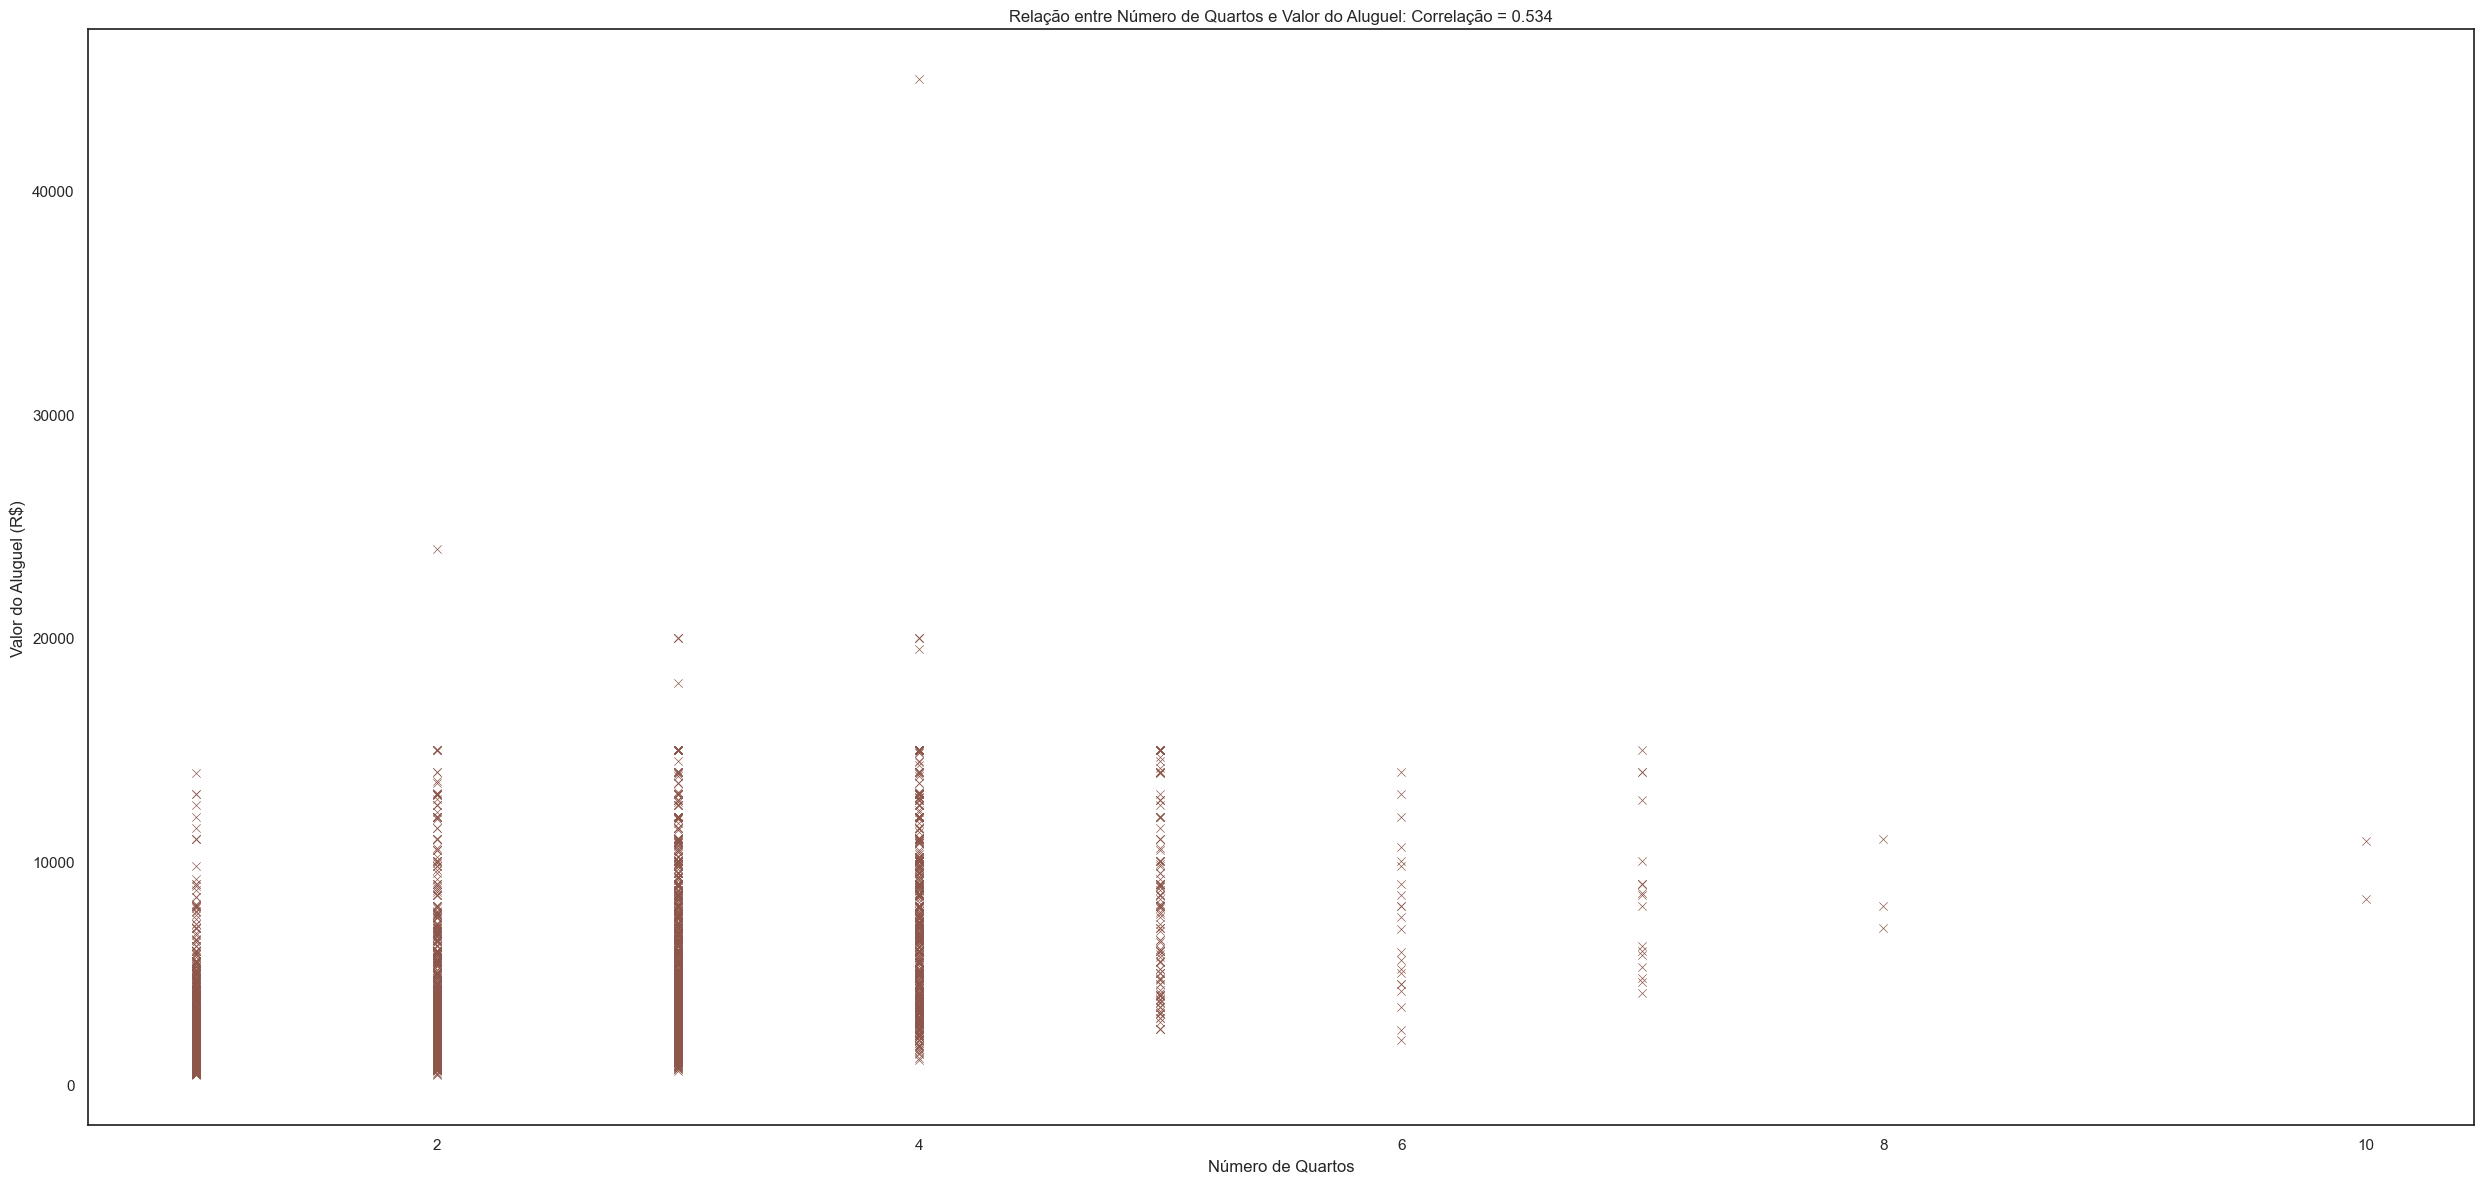

In [154]:
correlation_rooms_rent = data['rooms'].corr(data['rent amount'])

sns.scatterplot(x = 'rooms', y = 'rent amount', data = data, marker = 'x', color = cor6)

# Título e labels
plt.title(f'Relação entre Número de Quartos e Valor do Aluguel: Correlação = {round(correlation_rooms_rent, 3)}')
plt.xlabel('Número de Quartos')
plt.ylabel('Valor do Aluguel (R$)')

plt.tight_layout();
plt.savefig(homepath + 'reports/figures/pergunta12.png')

O coeficiente de correlação entre o número de quartos e o valor do aluguel é de aproximadamente 0.534. Este valor indica uma correlação positiva moderada, sugerindo que imóveis com mais quartos tendem a ter aluguéis mais altos. Isso pode ser atribuído à relação geral entre o tamanho do imóvel e seu valor de aluguel: imóveis maiores, com mais quartos, geralmente custam mais para alugar.


### 13. Influência da localização na taxa de HOA: A localização (cidade) tem impacto significativo na taxa de HOA?


A correlação entre cidade e HOA é de 0.043


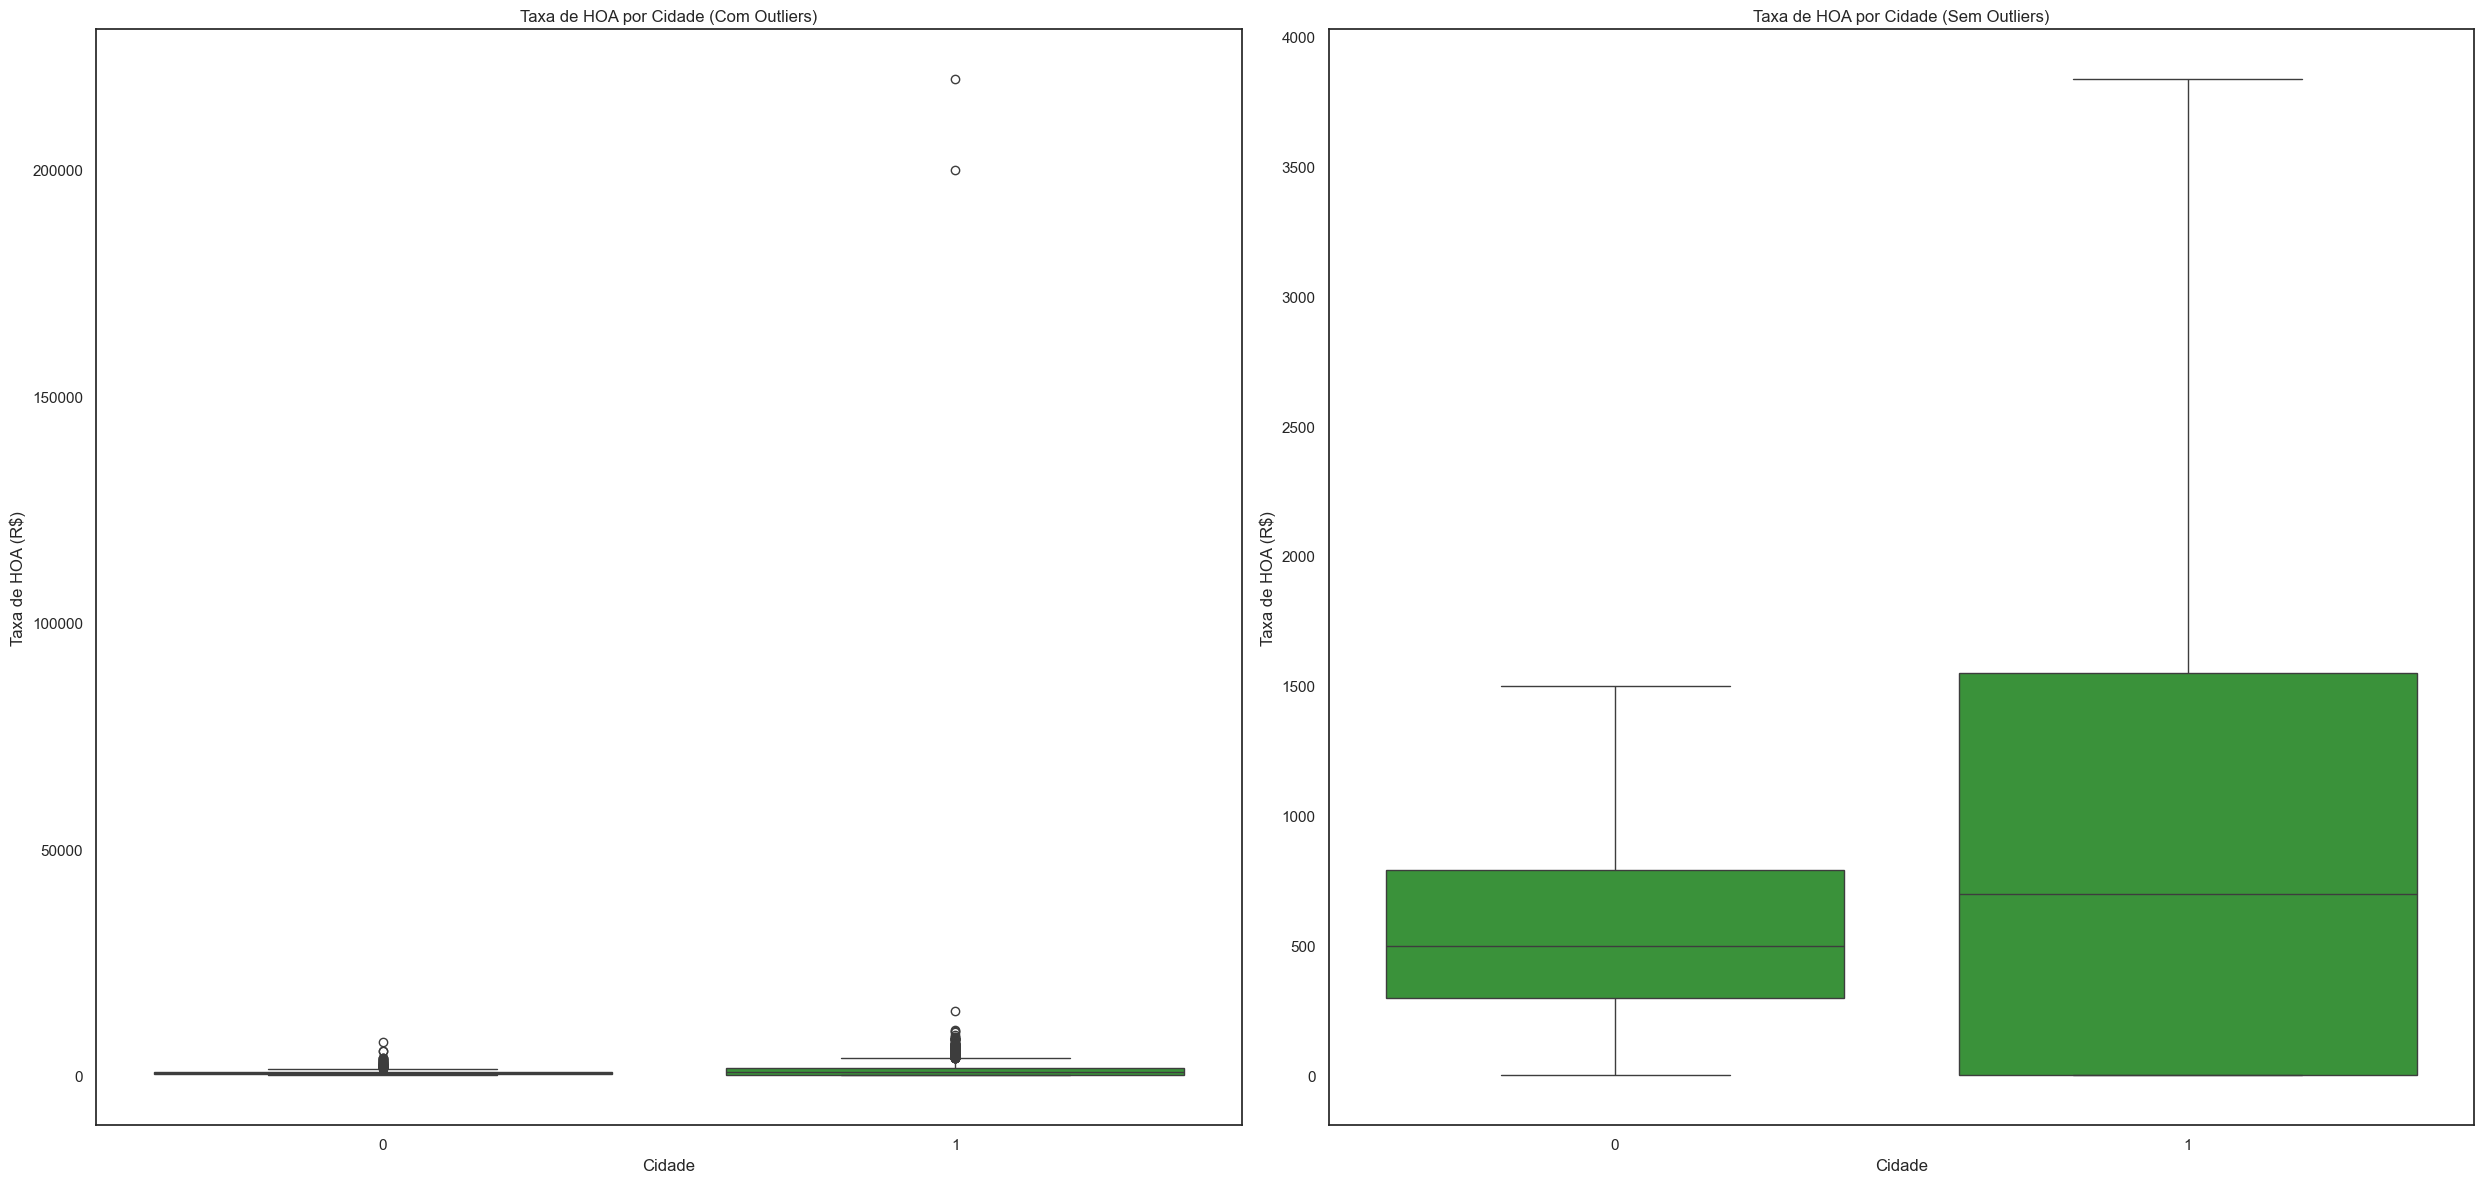

In [155]:
plt.figure()

# Gráfico de caixa com outliers
plt.subplot(1, 2, 1)
sns.boxplot(x = 'city', y = 'hoa', data = data, color = cor3)
plt.title('Taxa de HOA por Cidade (Com Outliers)')
plt.xlabel('Cidade')
plt.ylabel('Taxa de HOA (R$)')

# Gráfico de caixa sem outliers
plt.subplot(1, 2, 2)
sns.boxplot(x = 'city', y = 'hoa', data = data, showfliers = False, color = cor3)
plt.title('Taxa de HOA por Cidade (Sem Outliers)')
plt.xlabel('Cidade')
plt.ylabel('Taxa de HOA (R$)')

plt.tight_layout();
plt.savefig(homepath + 'reports/figures/pergunta13.png')

correlation_city_hoa = data['city'].corr(data['hoa'])
print(f'A correlação entre cidade e HOA é de {round(correlation_city_hoa, 3)}')

A Taxa de variação da HOA não parece estar fortemente associada à cidade em que o imóvel está localizado por causa da correlação fraca. Outros fatores podem ter uma influência maior na determinação da taxa de HOA. 


### 14. Relação entre área e número de quartos/banheiros: Existe uma relação entre a área do imóvel (area) e o número de quartos (rooms) e banheiros (bathroom)? 


Correlação de área e número de quartos: 0.267
Correlação de área e número de quartos: 0.275


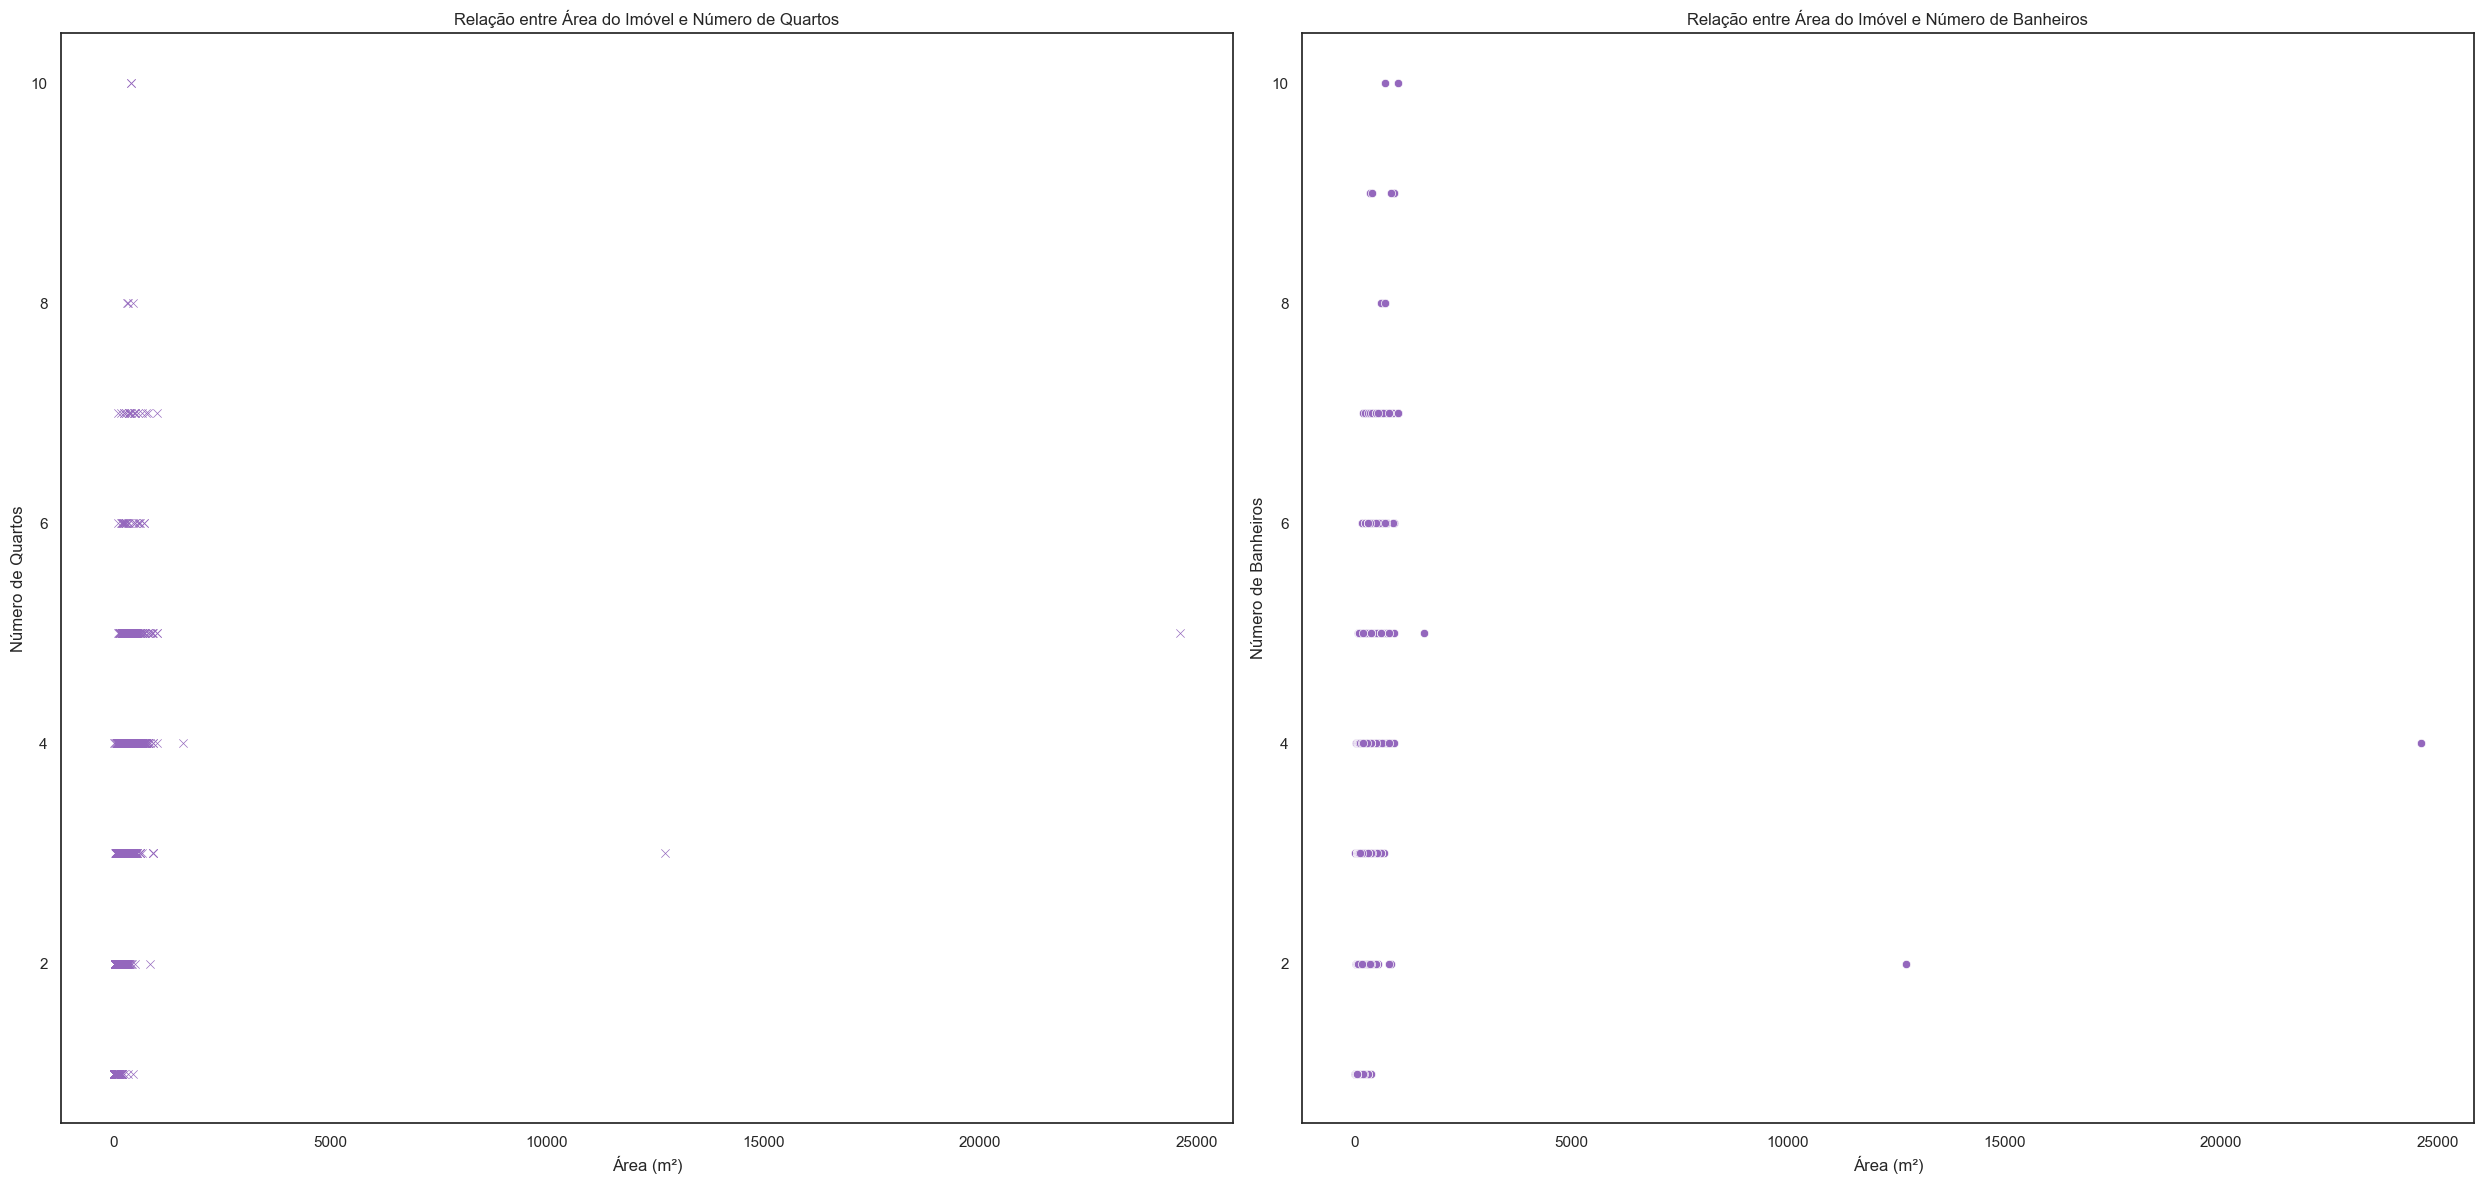

In [156]:
plt.figure()

# Relação entre área e número de quartos
plt.subplot(1, 2, 1)
sns.scatterplot(x = 'area', y = 'rooms', data = data, color = cor5, marker = 'x')
plt.title('Relação entre Área do Imóvel e Número de Quartos')
plt.xlabel('Área (m²)')
plt.ylabel('Número de Quartos')

# Relação entre área e número de banheiros
plt.subplot(1, 2, 2)
sns.scatterplot(x = 'area', y = 'bathroom', data = data, color = cor5, marker = 'o')
plt.title('Relação entre Área do Imóvel e Número de Banheiros')
plt.xlabel('Área (m²)')
plt.ylabel('Número de Banheiros')

plt.tight_layout();
plt.savefig(homepath + 'reports/figures/pergunta14.png')

# Calculando os coeficientes de correlação
correlation_area_rooms = data['area'].corr(data['rooms'])
correlation_area_bathrooms = data['area'].corr(data['bathroom'])

print(f'Correlação de área e número de quartos: {round(correlation_area_rooms, 3)}')
print(f'Correlação de área e número de quartos: {round(correlation_area_bathrooms, 3)}')

Essas relações sugerem que, embora exista alguma tendência de que imóveis maiores tenham mais quartos e banheiros, a correlação não é particularmente forte. Outros fatores podem influenciar o número de quartos e banheiros em um imóvel além de sua área.


### 15. Diferenças no valor do aluguel por tipo de mobília: Como a presença ou ausência de mobília (furniture) afeta o valor do aluguel (rent amount)? 
Obs: Parece a 3.

A média de móveis mobiliados é de R$5387.09228824273
A média de móveis mobiliados é de R$4047.210760337928


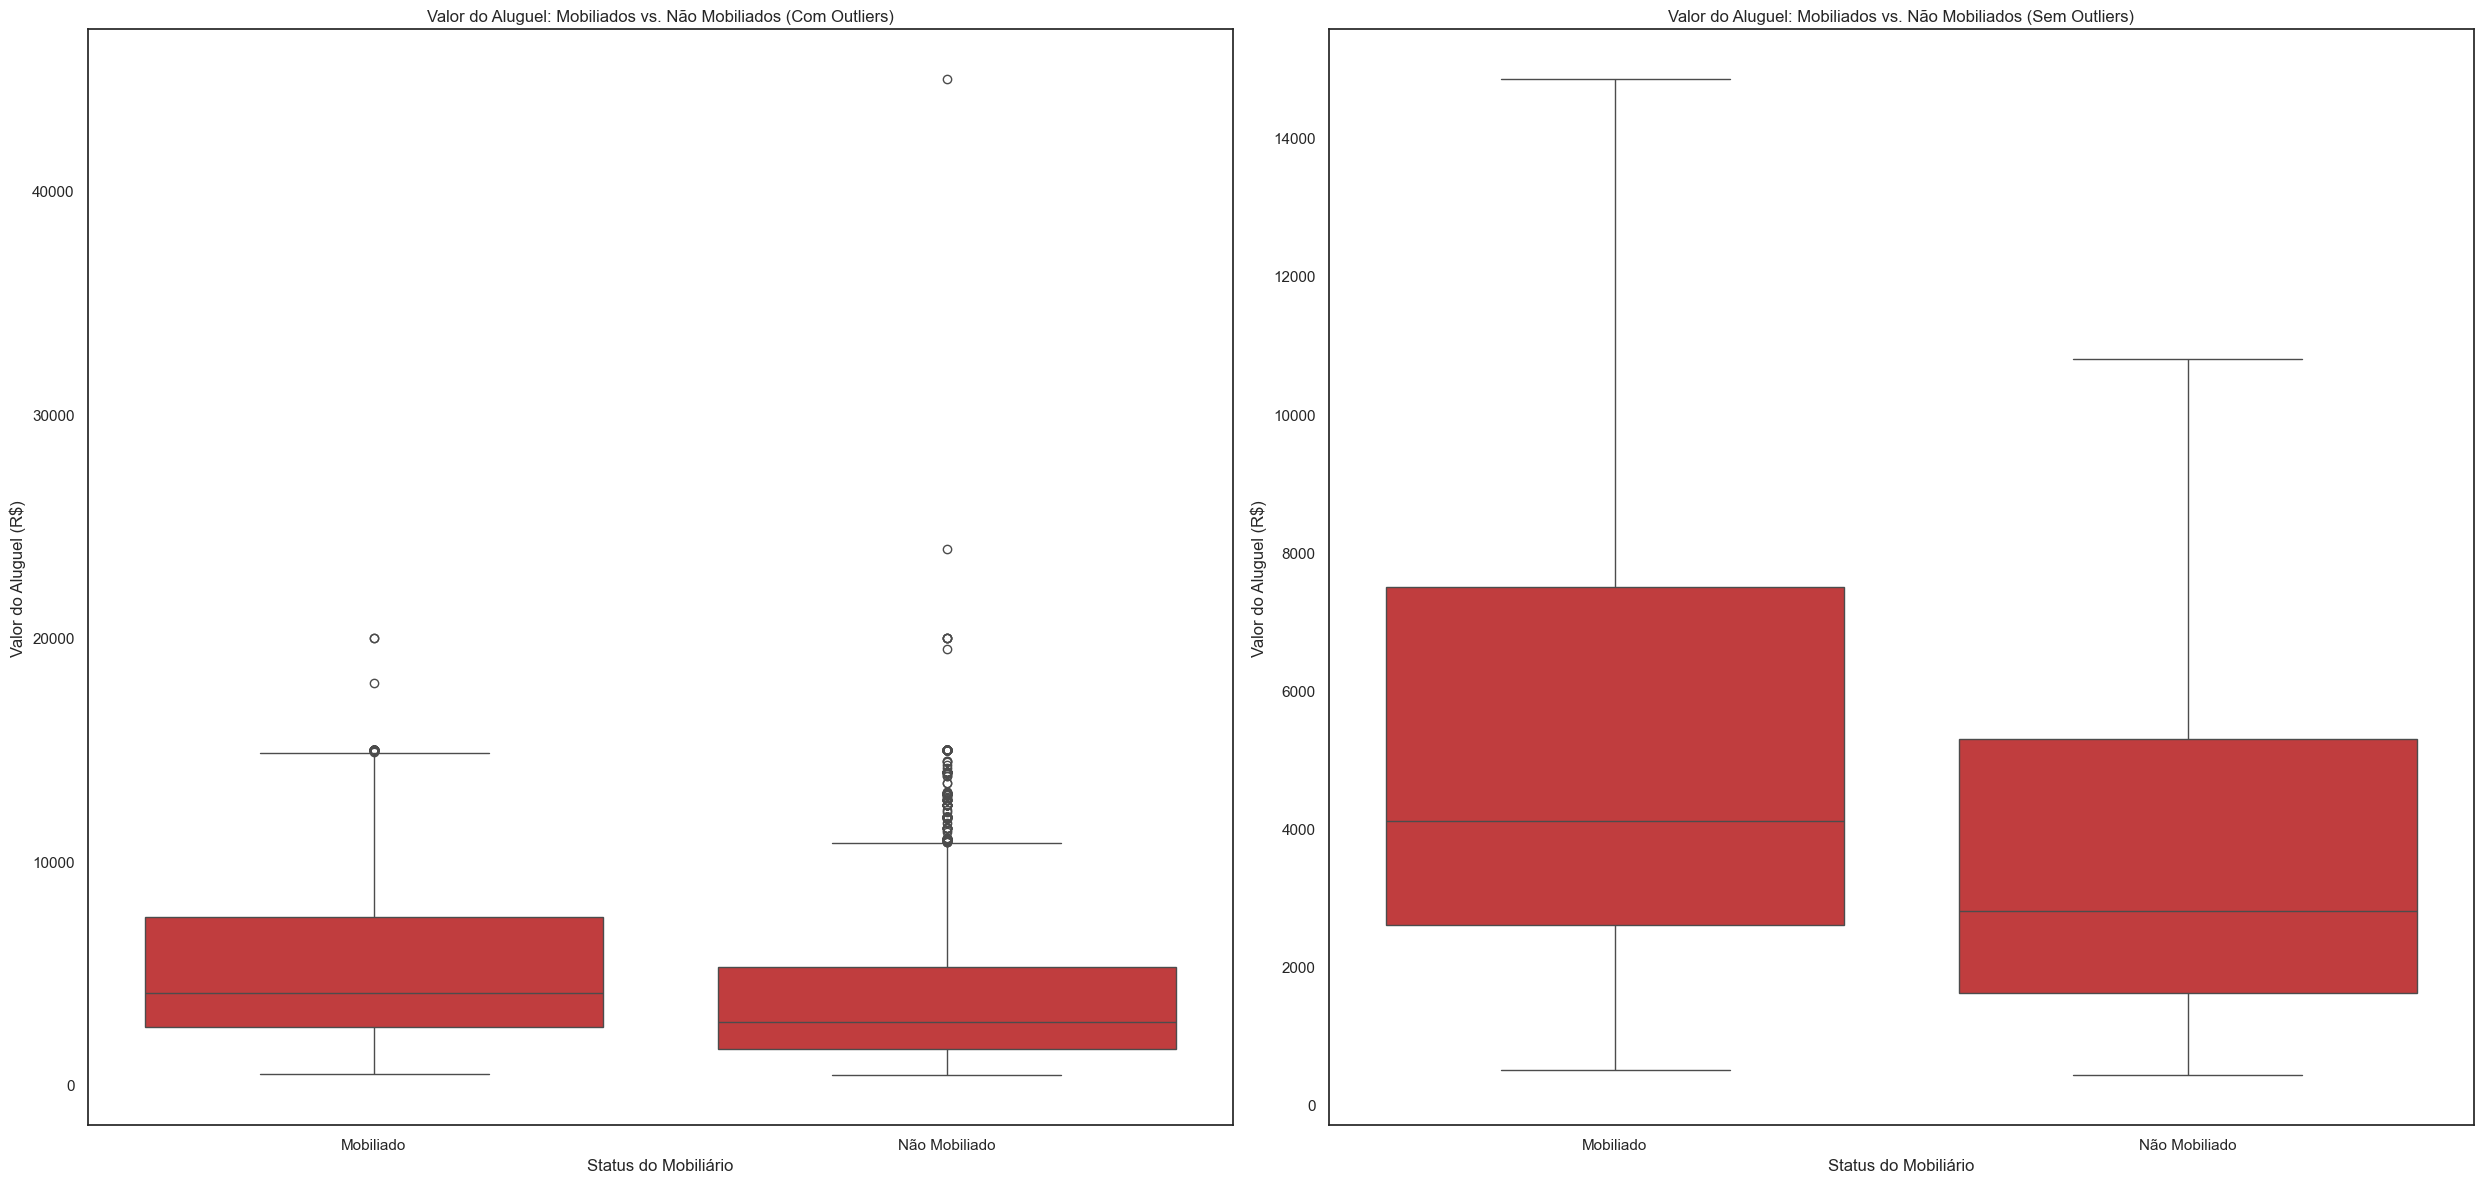

In [157]:
plt.figure()

# Gráfico de caixa com outliers
plt.subplot(1, 2, 1)
sns.boxplot(x = data['furniture'].map({0: 'Não Mobiliado', 1: 'Mobiliado'}), y = 'rent amount', data = data, color = cor4)
plt.title('Valor do Aluguel: Mobiliados vs. Não Mobiliados (Com Outliers)')
plt.xlabel('Status do Mobiliário')
plt.ylabel('Valor do Aluguel (R$)')

# Gráfico de caixa sem outliers
plt.subplot(1, 2, 2)
sns.boxplot(x = data['furniture'].map({0: 'Não Mobiliado', 1: 'Mobiliado'}), y = 'rent amount', data = data, showfliers = False, color = cor4)
plt.title('Valor do Aluguel: Mobiliados vs. Não Mobiliados (Sem Outliers)')
plt.xlabel('Status do Mobiliário')
plt.ylabel('Valor do Aluguel (R$)')

plt.tight_layout();
plt.savefig(homepath + 'reports/figures/pergunta15.png')

# Calculando a média do valor do aluguel para imóveis mobiliados e não mobiliados
mean_rent_furnished = data[data['furniture'] == 1]['rent amount'].mean()
mean_rent_unfurnished = data[data['furniture'] == 0]['rent amount'].mean()

print(f'A média de móveis mobiliados é de R${mean_rent_furnished}')
print(f'A média de móveis mobiliados é de R${mean_rent_unfurnished}')


Diferença no Valor do Aluguel entre Imóveis Mobiliados e Não Mobiliados:
    
- A média do valor do aluguel para imóveis não mobiliados é de aproximadamente R$ 4.047.
- Para imóveis mobiliados, a média do valor do aluguel é de cerca de R$ 5.387.

Isso sugere que, em média, imóveis mobiliados têm um valor de aluguel mais alto em comparação com imóveis não mobiliados, o que faz sentido.

### 16. Análise de densidade de imóveis por cidade: Qual cidade possui mais imóveis listados para aluguel? 

(city
 1    5249
 0     831
 Name: count, dtype: int64,
 6.316486161251504)

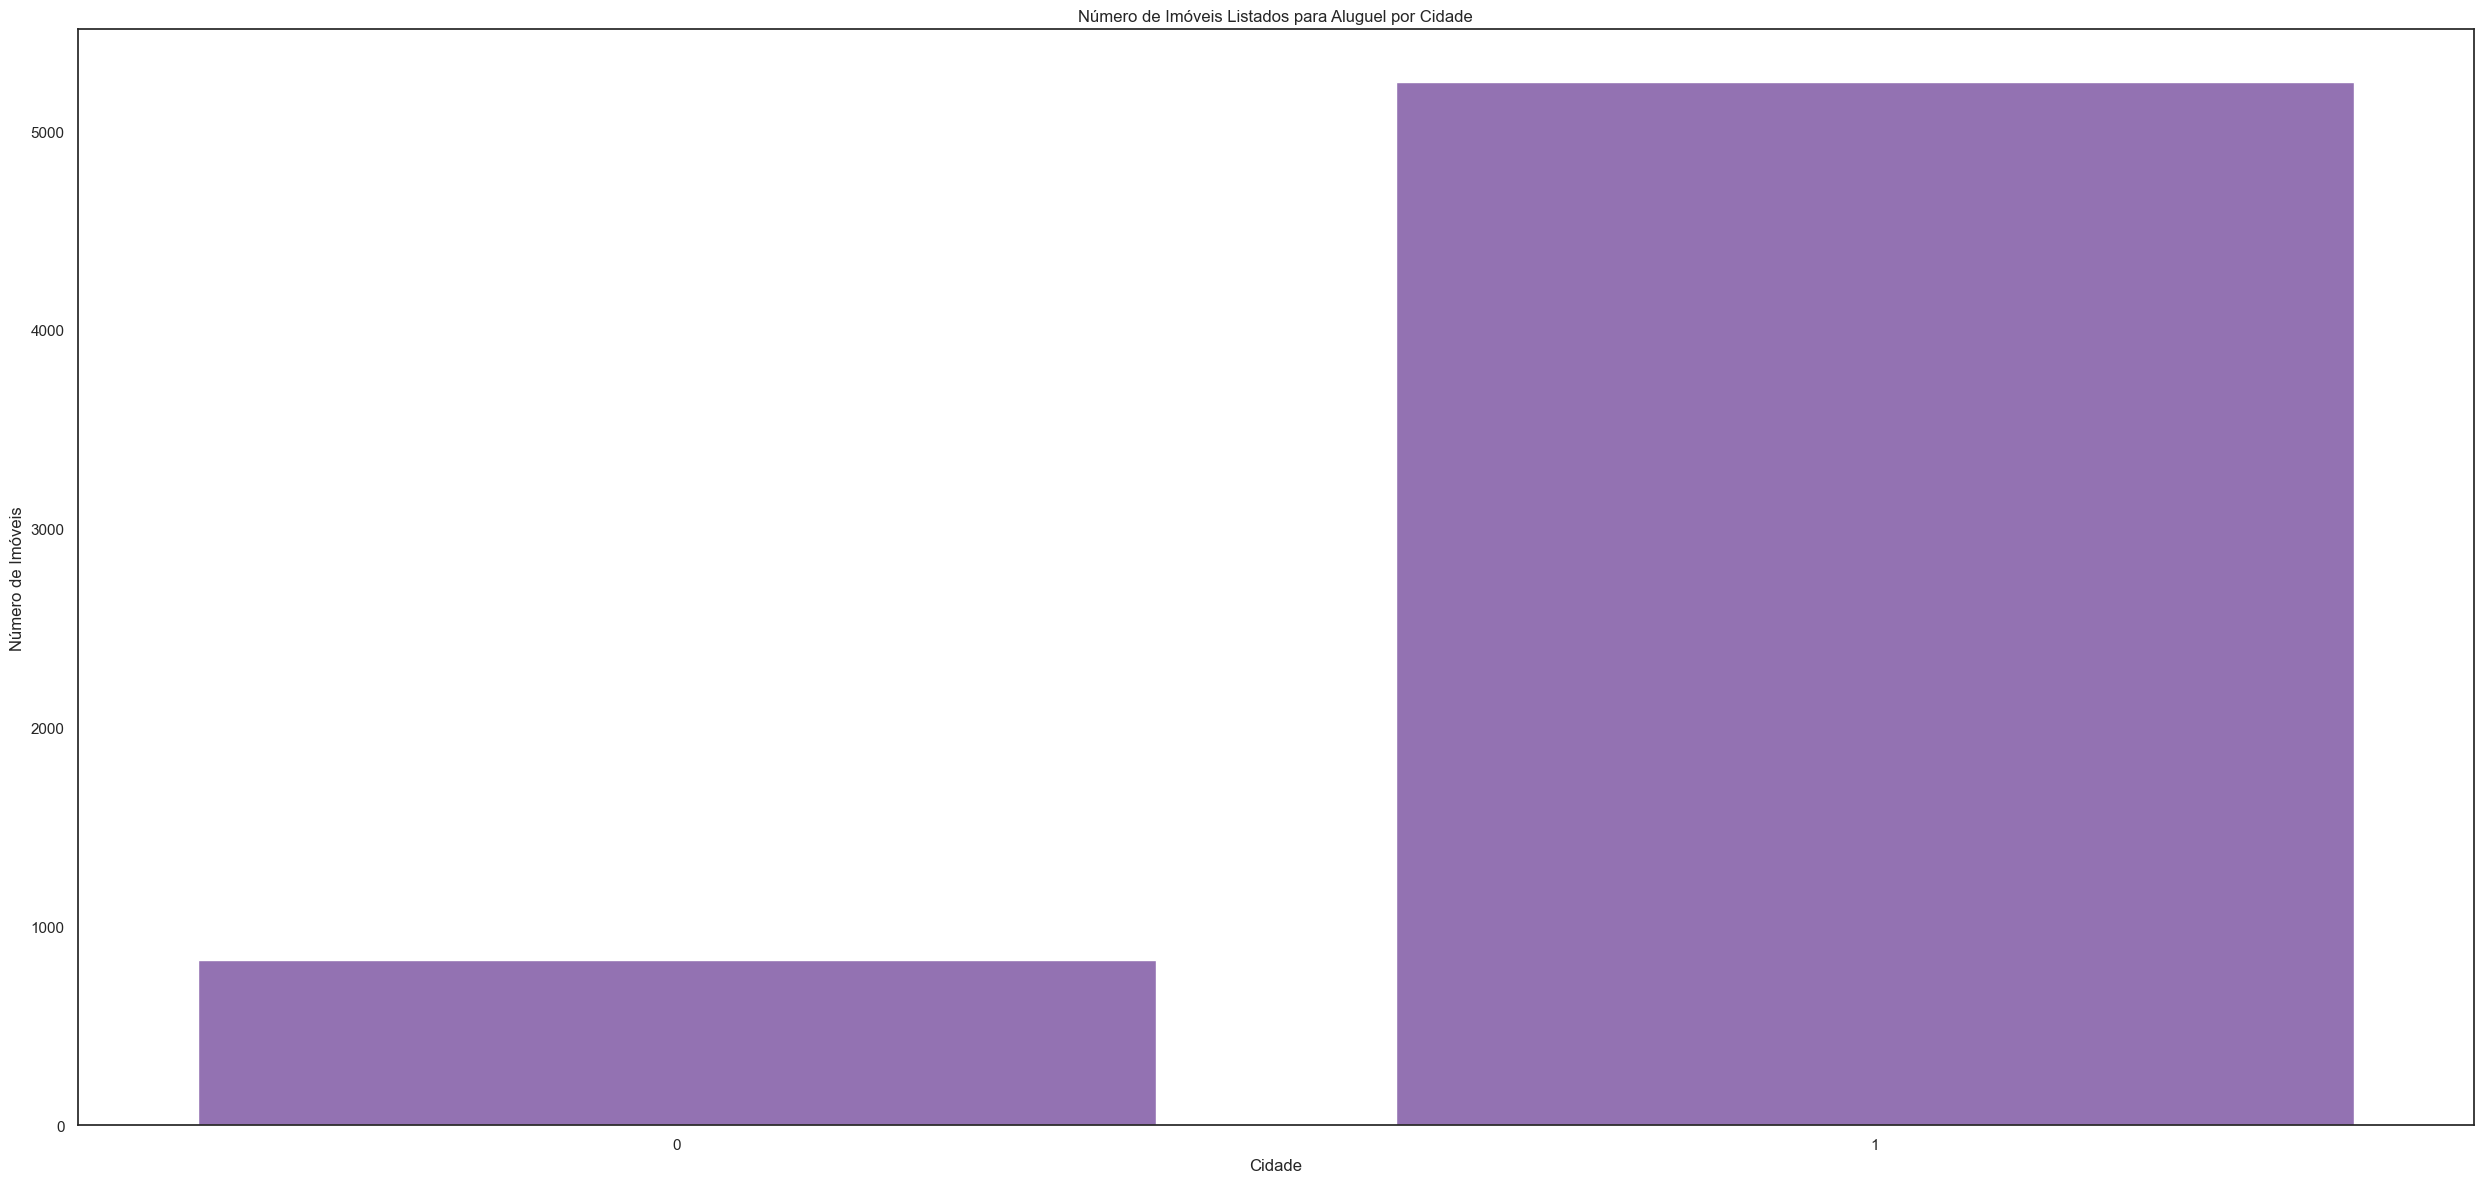

In [158]:
# Contando o número de imóveis listados para aluguel em cada cidade
count_city = data['city'].value_counts()

# Criando um gráfico de barras para mostrar o número de imóveis por cidade
plt.figure()
sns.barplot(x = count_city.index, y = count_city.values, color = cor5)
plt.title('Número de Imóveis Listados para Aluguel por Cidade')
plt.xlabel('Cidade')
plt.ylabel('Número de Imóveis')

plt.tight_layout();
plt.savefig(homepath + 'reports/figures/pergunta16.png')

count_city, 5249 / 831

A cidade com mais imóveis é a cidade 1 com 5249 cidades contra a cidade 0 com 831, 6,31 vezes mais.


### 17. Perfil dos imóveis mais caros e mais baratos: Quais características são comuns nos imóveis com os valores de aluguel mais altos e mais baixos? 

In [159]:
# Definindo os percentis para aluguéis altos e baixos
percentil_alto = data['rent amount'].quantile(0.75)
percentil_baixo = data['rent amount'].quantile(0.25)

# Filtrando imóveis com aluguéis altos e baixos
imoveis_altos = data[data['rent amount'] >= percentil_alto]
imoveis_baixos = data[data['rent amount'] <= percentil_baixo]

# Analisando características médias para imóveis com aluguéis altos
caracteristicas_altas = imoveis_altos[['area', 'rooms', 'bathroom', 'parking spaces', 'furniture', 'animal', 'hoa', 'property tax']].mean()

# Analisando características médias para imóveis com aluguéis baixos
caracteristicas_baixas = imoveis_baixos[['area', 'rooms', 'bathroom', 'parking spaces', 'furniture', 'animal', 'hoa', 'property tax']].mean()

print(caracteristicas_altas)

print(caracteristicas_baixas)


area               290.424342
rooms                3.398684
bathroom             3.765132
parking spaces       3.121053
furniture            0.354605
animal               0.823684
hoa               2115.780263
property tax       916.042763
dtype: float64
area               68.812338
rooms               1.701299
bathroom            1.224675
parking spaces      0.629221
furniture           0.114286
animal              0.690909
hoa               420.058442
property tax       63.169481
dtype: float64


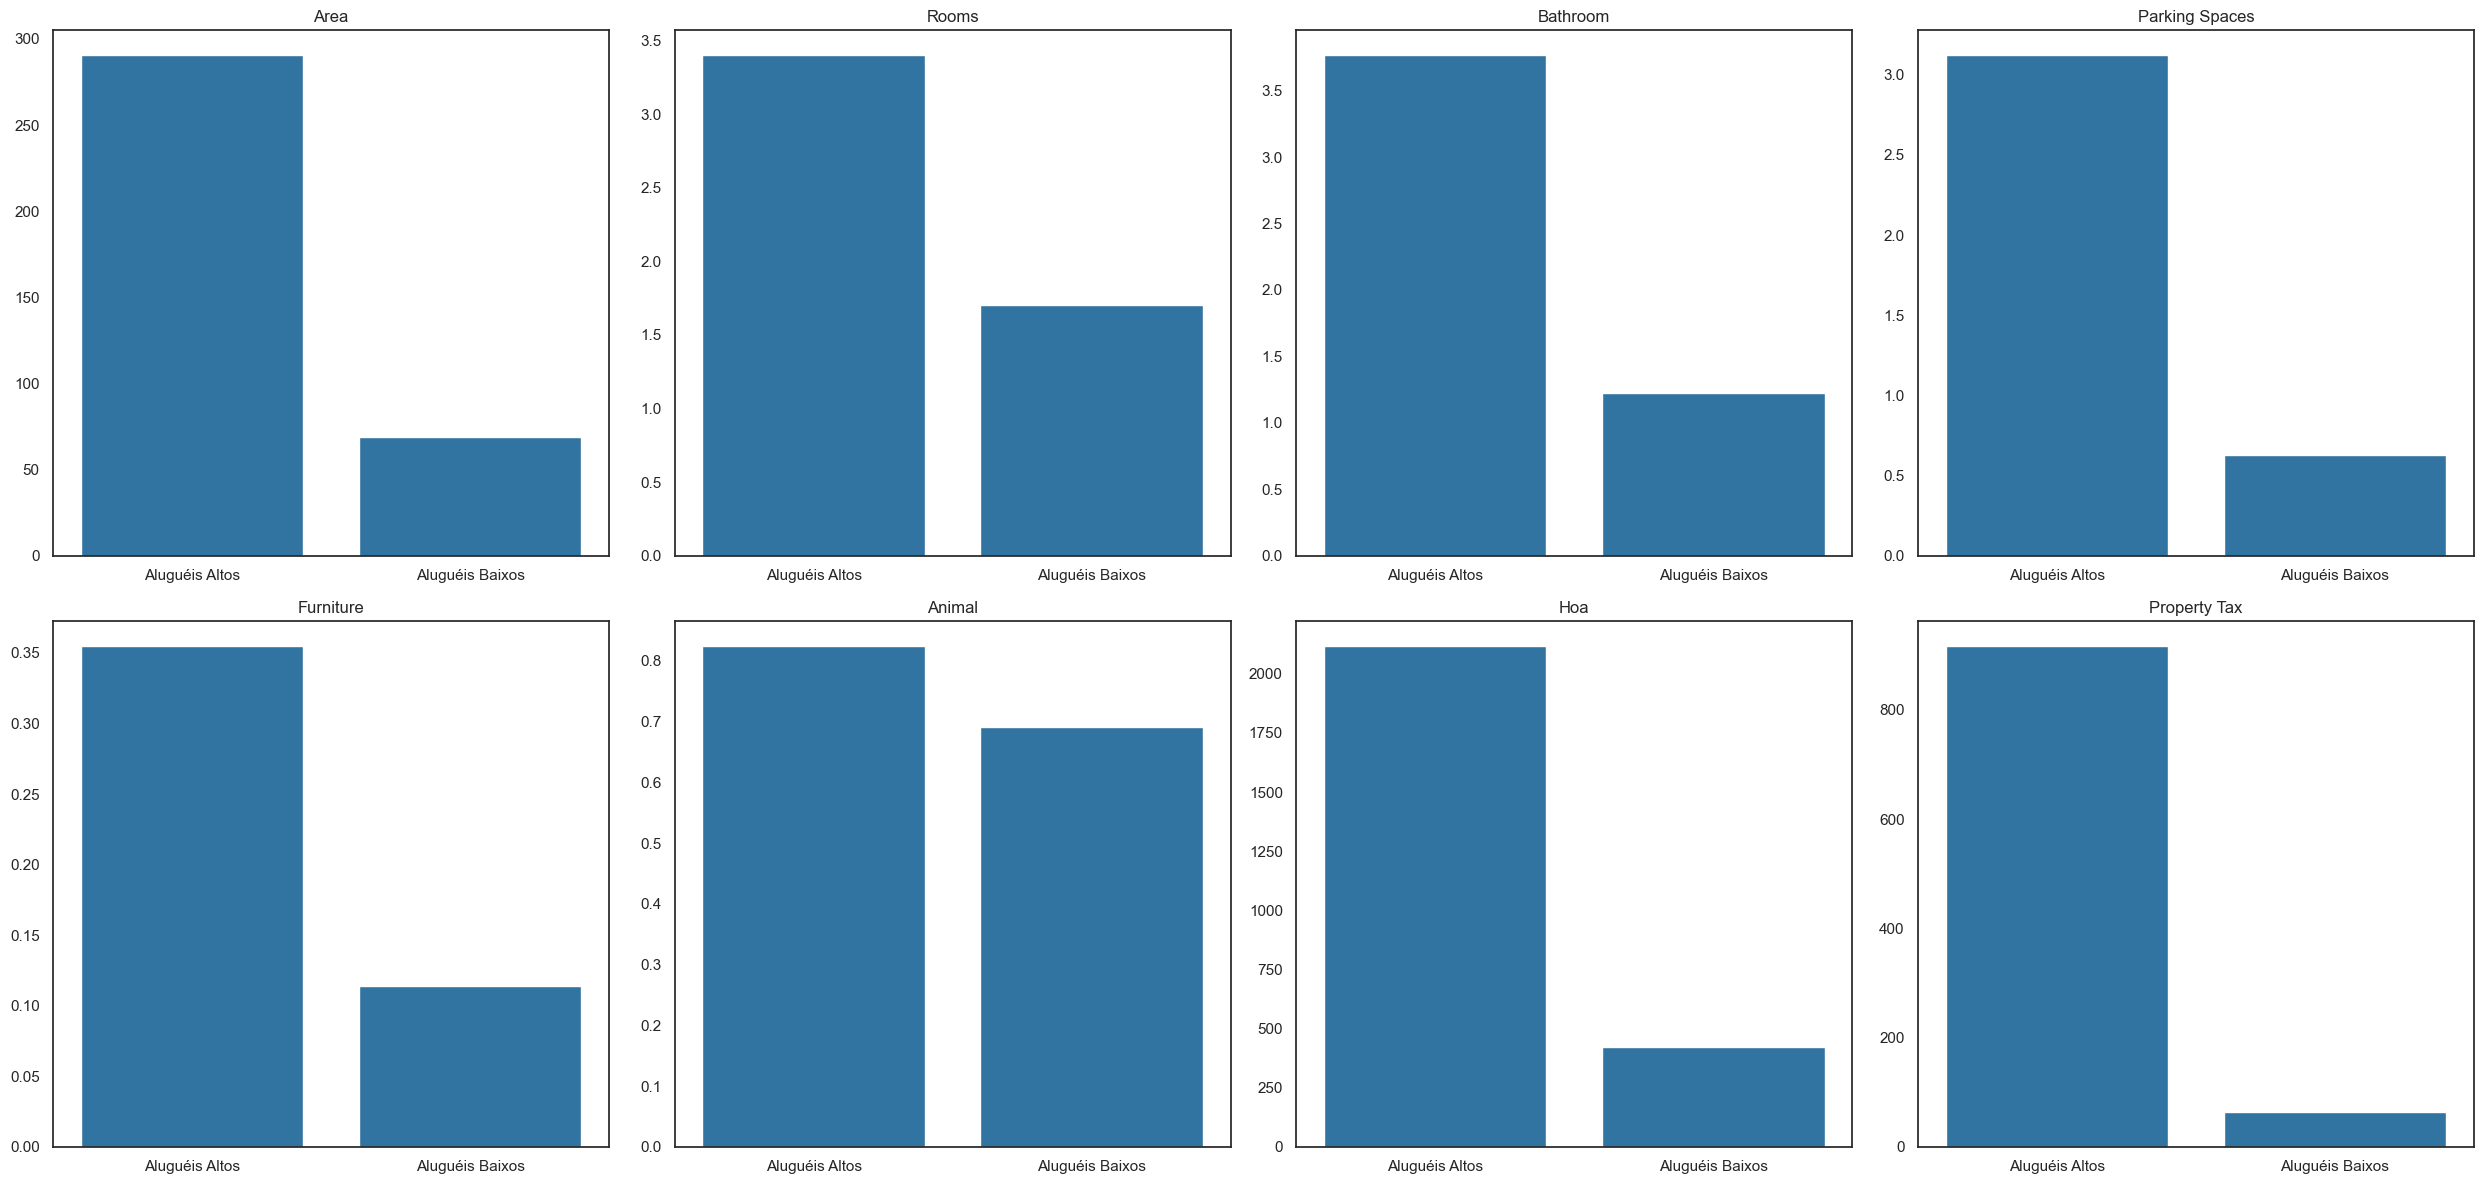

In [160]:
# Definindo os percentis para aluguéis altos e baixos
high_percentile = data['rent amount'].quantile(0.75)
low_percentile = data['rent amount'].quantile(0.25)

# Filtrando imóveis com aluguéis altos e baixos
high_rent = data[data['rent amount'] >= high_percentile]
low_rent = data[data['rent amount'] <= low_percentile]

# Lista de características para análise
features = ['area', 'rooms', 'bathroom', 'parking spaces', 'furniture', 'animal', 'hoa', 'property tax']

# Criando plots para comparar as características médias dos imóveis com aluguéis altos e baixos
plt.figure()

for i, caracteristica in enumerate(features, 1):
    plt.subplot(2, 4, i)
    sns.barplot(x=['Aluguéis Altos', 'Aluguéis Baixos'],
                y=[high_rent[caracteristica].mean(), low_rent[caracteristica].mean()], color = cor1)
    plt.title(caracteristica.title().replace('_', ' '))

plt.tight_layout();
plt.savefig(homepath + 'reports/figures/pergunta17.png')



As principais caraterísticas para aluguel caro são:
- **Área**: Em média, imóveis grandes;
- **Quartos**: Preferencia para mais quartos, geralmente a partir de 3;
- **Banheiros**: 3 ou acima;
- **Vagas de estacionamento**: Geralmente 3, em média;
- **Mobília**: Indiferente;
- **Animal**: Preferencialmente sim;
- **Taxa de condomínio**: Taxas superiores a 1750, valores altos para imóveis caros;
- **IPTU**: Alto valor de IPTU se comparado para aluguéis baratos;


As principais caraterísticas para aluguel barato são:
- **Área**: Em média, imóveis grandes;
- **Quartos**: Em média, 2 quartos;
- **Banheiros**: 1 ou 2;
- **Vagas de estacionamento**: Uma ou nenhuma, provavelmente alguns não possuem veículo próprio;
- **Furniture**: Sem mobília;
- **Animal**: Preferencialmente sim;
- **Taxa de condomínio**: Inferiores a 600, de preferência
- **IPTU**: De preferência, barato;

Em resumo:
- Área, Quartos e Banheiros: Imóveis com aluguéis mais altos tendem a ter uma área maior, mais quartos e banheiros.
- Vagas de Estacionamento: Há também uma tendência de mais vagas de estacionamento em imóveis com aluguéis mais altos.
- Mobília e Aceitação de Animais: Pode haver diferenças na presença de mobília e na aceitação de animais, embora essas características possam ser menos determinantes no valor do aluguel do que o tamanho e a localização do imóvel.
- HOA e IPTU: Os valores de HOA e IPTU parecem ser maiores em imóveis com aluguéis mais altos.


### 18. Relação entre quantidade de banheiros e quartos: Existe uma correlação entre o número de quartos (rooms) e o número de banheiros (bathroom)?

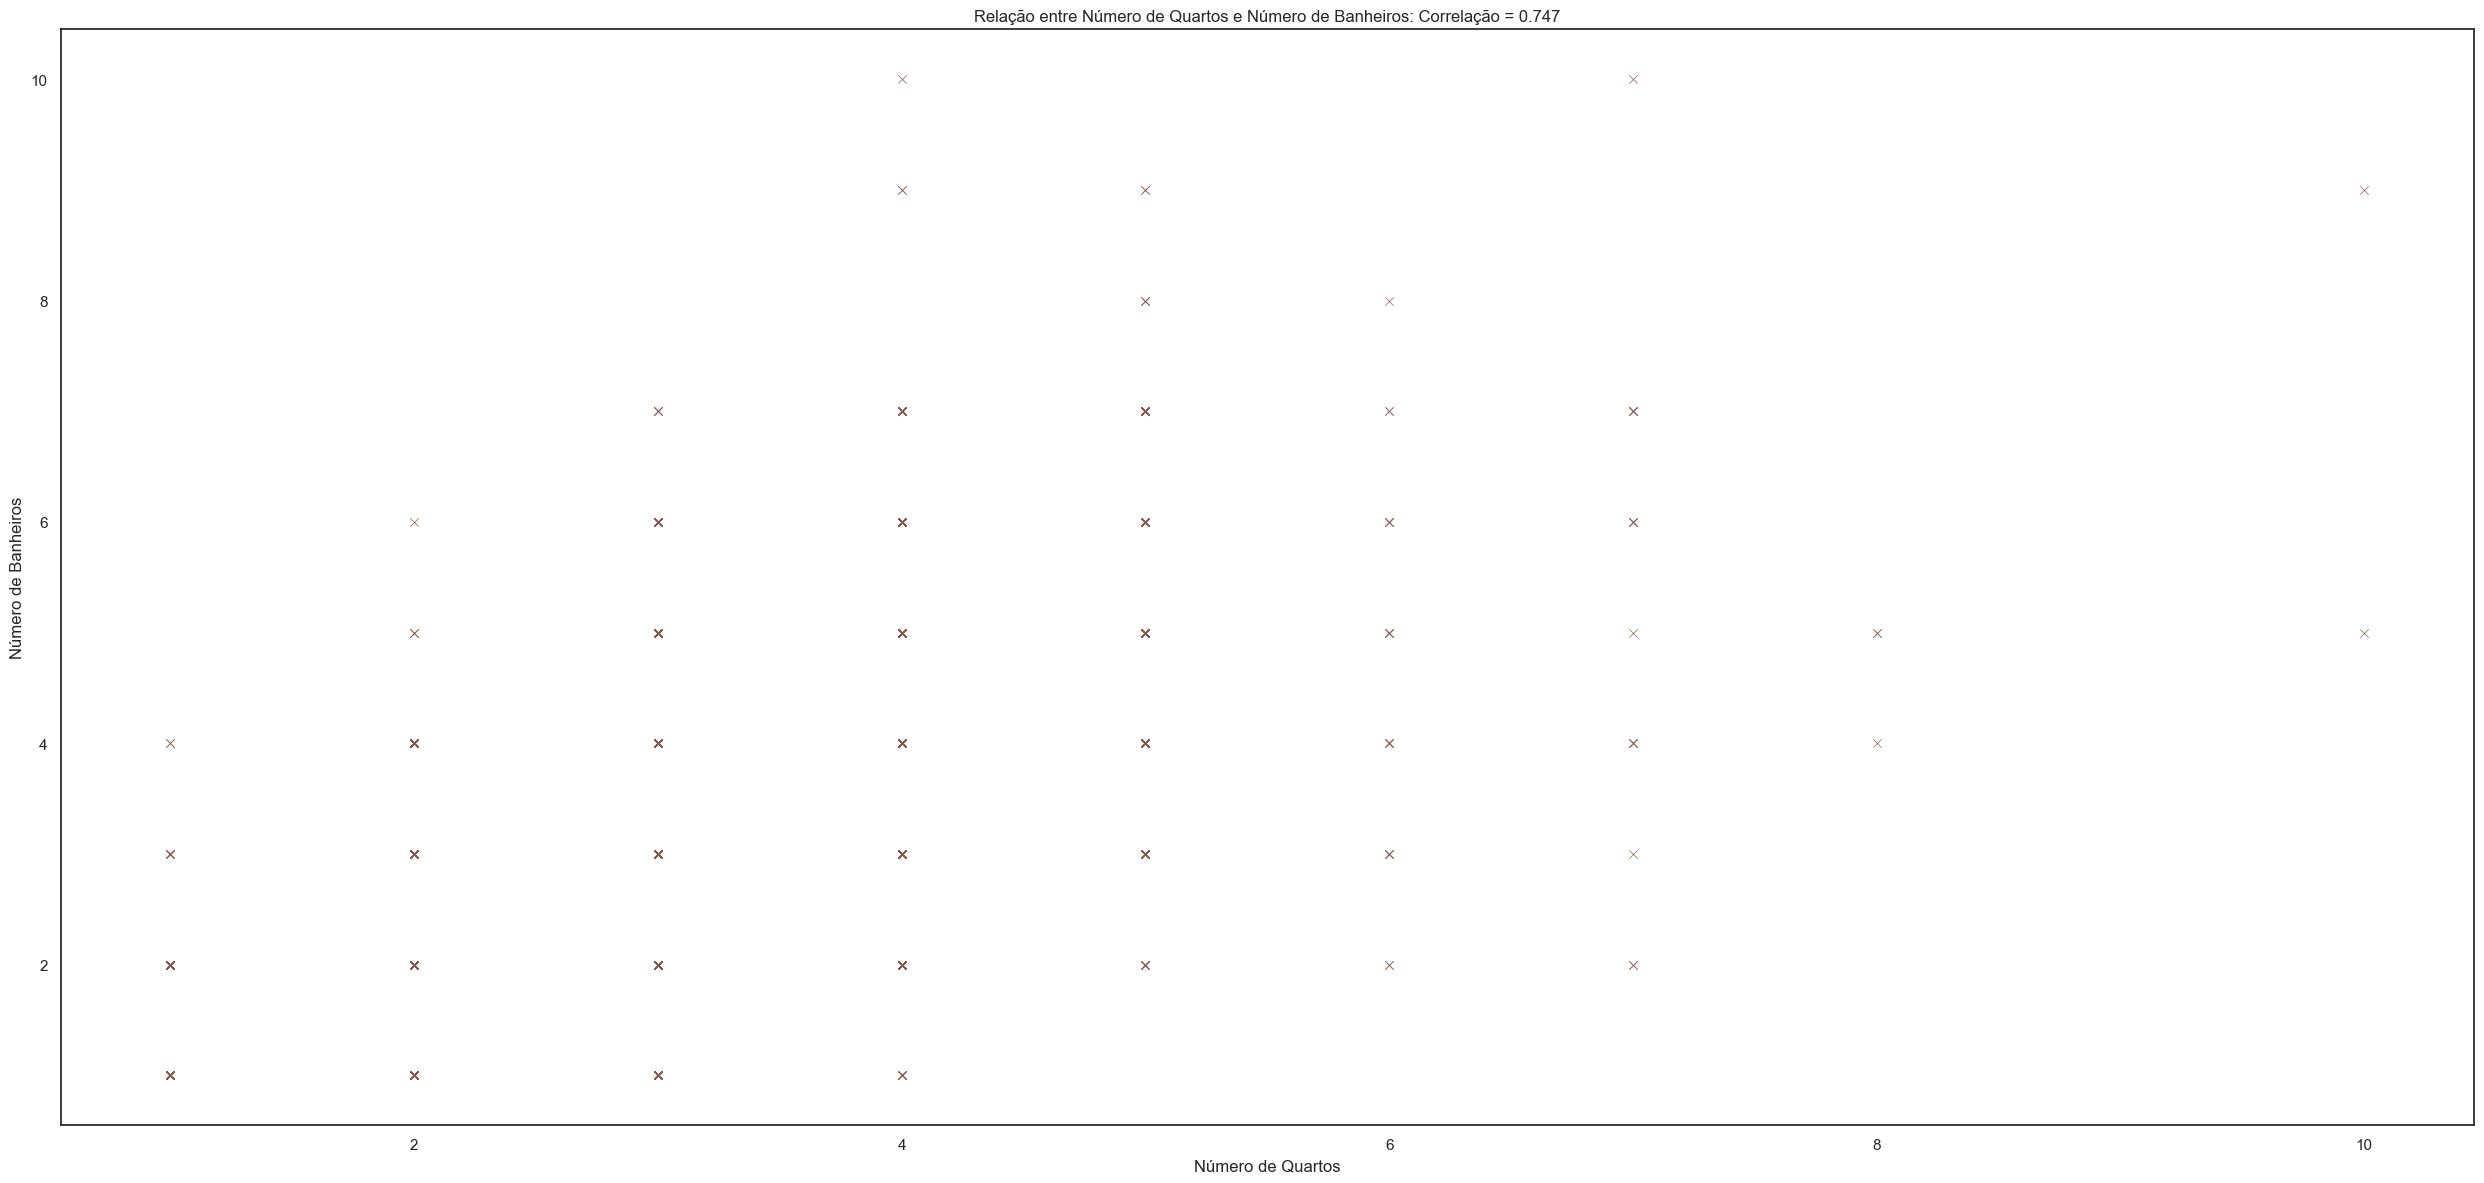

In [161]:
correlation_rooms_bathrooms = data['rooms'].corr(data['bathroom'])

plt.figure()
sns.scatterplot(x = 'rooms', y = 'bathroom', data = data, marker = 'x', color = cor6)

# Título e labels
plt.title(f'Relação entre Número de Quartos e Número de Banheiros: Correlação = {round(correlation_rooms_bathrooms, 3)}')
plt.xlabel('Número de Quartos')
plt.ylabel('Número de Banheiros')

plt.tight_layout();
plt.savefig(homepath + 'reports/figures/pergunta18.png')

O coeficiente de correlação entre o número de quartos e o número de banheiros é de aproximadamente 0.747, valor positivo e forte. Isso sugere que imóveis com mais quartos tendem a ter mais banheiros. Isso é consistente com a expectativa de que imóveis maiores, geralmente com mais quartos, ofereceriam também um maior número de banheiros para inquilinos.


### **DESAFIO 1**. Previsão de valor de aluguel baseado em características: Quais características são os melhores preditores para o valor do aluguel? 


Para essa situação, irei utilizar o H2O para uma análise mais rápida

In [162]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "21.0.1" 2023-10-17; OpenJDK Runtime Environment (build 21.0.1+12-29); OpenJDK 64-Bit Server VM (build 21.0.1+12-29, mixed mode, sharing)
  Starting server from /Users/guttofranca/Repos/brazilian_houses_for_rent/.venv/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/k8/xr4_svzj4l705syzgn21x_500000gn/T/tmphfq9yvbz
  JVM stdout: /var/folders/k8/xr4_svzj4l705syzgn21x_500000gn/T/tmphfq9yvbz/h2o_guttofranca_started_from_python.out
  JVM stderr: /var/folders/k8/xr4_svzj4l705syzgn21x_500000gn/T/tmphfq9yvbz/h2o_guttofranca_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Recife
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_guttofranca_1edyz6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.983 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Irei remover a coluna `total` para análise, por ser um modelo de regressão para prever o aluguel, sem taxas (rent amount), o total está diretamente relacionado com as features de aluguel, IPTU e valor de seguro, em outras palavras, o total precisa dessas features para existir.

In [163]:
# Divisão de Treino e Teste, X e y
df = h2o.H2OFrame(data)

train, test = df.split_frame([0.8], seed = seed)
print(f'Train: {train.nrows}\nTest: {test.nrows}')

# Para as carater

y = 'rent amount'
ignore = ['total']
x = list(set(train.names) - set(ignore))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Train: 4872
Test: 1208


In [164]:
aml = H2OAutoML(max_models = 30,
                max_runtime_secs = 2000,
                project_name = 'brazilian_houses_for_rent',
                stopping_metric = 'RMSE',
                sort_metric = 'RMSE',
                seed = seed)

aml.train(x = x, y = y, training_frame = train)

lb = aml.leaderboard
lb.head(rows = lb.nrows)

AutoML progress: |
13:13:28.911: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20240122_131328,313.727,98424.3,102.155,0.0605471,98424.3
DeepLearning_grid_3_AutoML_1_20240122_131328_model_4,349.526,122168,167.56,nan,122168
StackedEnsemble_BestOfFamily_1_AutoML_1_20240122_131328,359.37,129147,130.89,nan,129147
DeepLearning_grid_2_AutoML_1_20240122_131328_model_2,399.14,159312,245.331,nan,159312
DeepLearning_grid_1_AutoML_1_20240122_131328_model_2,403.136,162519,181.873,0.113927,162519
DeepLearning_grid_2_AutoML_1_20240122_131328_model_4,424.417,180130,174.582,nan,180130
DeepLearning_1_AutoML_1_20240122_131328,448.013,200715,235.153,0.135125,200715
GBM_grid_1_AutoML_1_20240122_131328_model_1,454.981,207007,114.688,0.068421,207007
GBM_grid_1_AutoML_1_20240122_131328_model_8,456.052,207984,88.3525,0.0648912,207984
DeepLearning_grid_3_AutoML_1_20240122_131328_model_1,493.21,243256,165.427,nan,243256


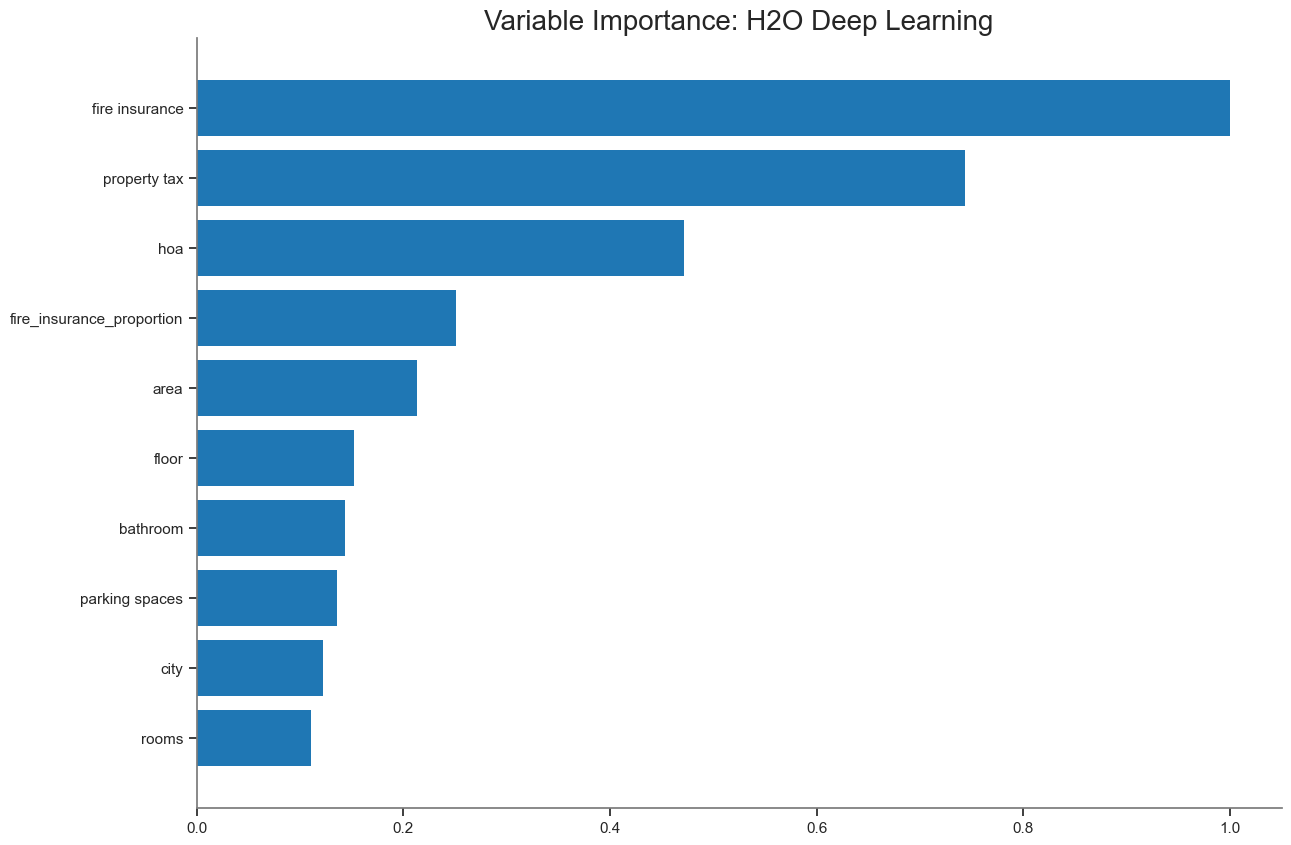

<Figure size 2500x1200 with 0 Axes>

In [170]:
# Pegando o modelo
model = h2o.get_model(lb[1, 'model_id'])
model.varimp_plot()

As características mais importantes para previsão dos valores de aluguel são:
- **Seguro contra incêndio** (fire insurance)
- **IPTU** (property tax)
- **Valor do condomínio** (hoa)
- **Área** (area)
- **Andar** (floor)

Valores de taxa como condomínio, IPTU e seguro estão no topo, o que faz sentido com a realidade, geralmente a parte financeira é a maior preocupação no aluguel, área e andar também apresentam grande importância, entretanto, o mais surpreendente é o número de banheiros estar acima do número de quartos em prioridade no valor do aluguel. As cidades estão codificadas, não é possível retirar bons insights.

In [173]:
h2o.cluster().shutdown()

H2O session _sid_8888 closed.



### **DESAFIO 2**. Análise de agrupamento de imóveis: É possível identificar grupos de imóveis com características semelhantes? 


#### PCA

In [237]:
df_cluster = data.drop(columns = ['total', 'id'])
ids = data['id']

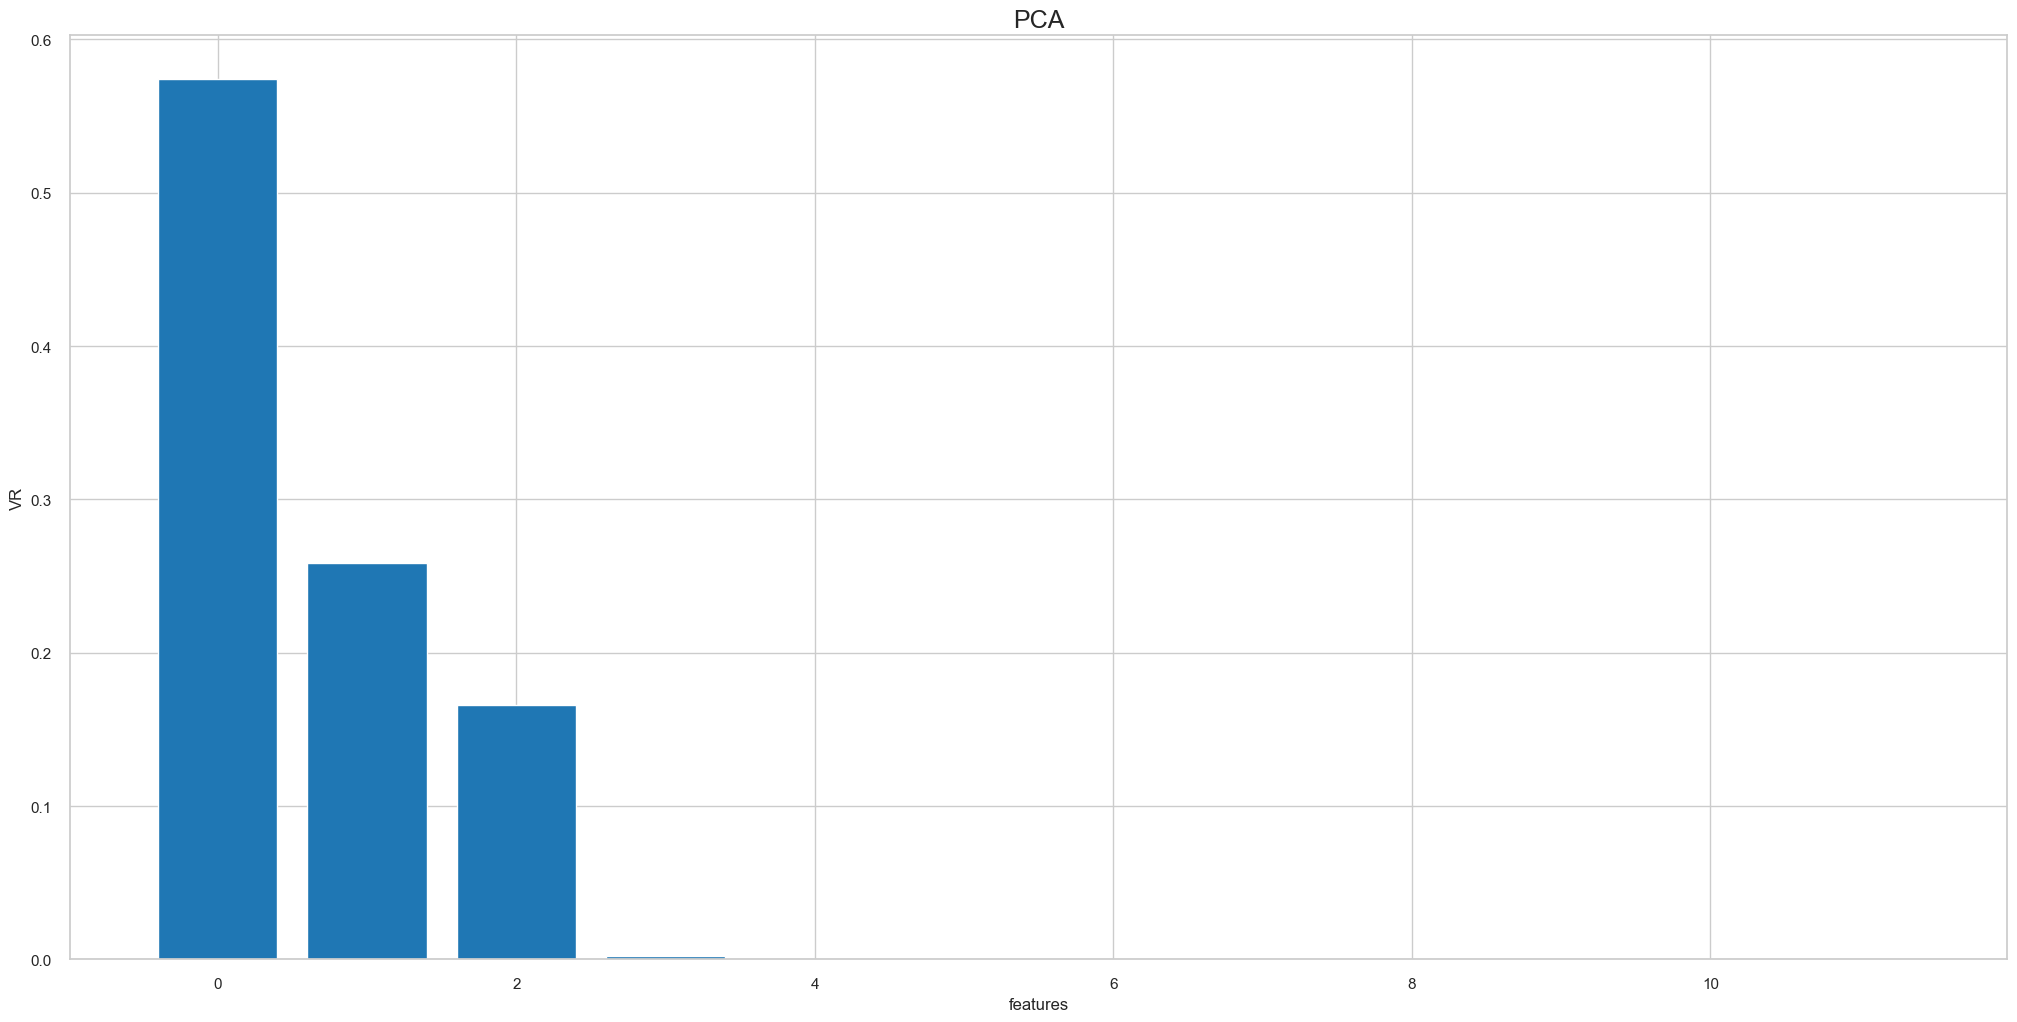

In [238]:
pca = PCA(n_components = df_cluster.shape[1])
principal_components = pca.fit_transform(df_cluster)

# plot
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plot_label('PCA', 'features', 'VR', 12)

# pca component
df_pca = pd.DataFrame(principal_components)

# saving figure
plt.savefig(homepath + 'reports/figures/pca.png')

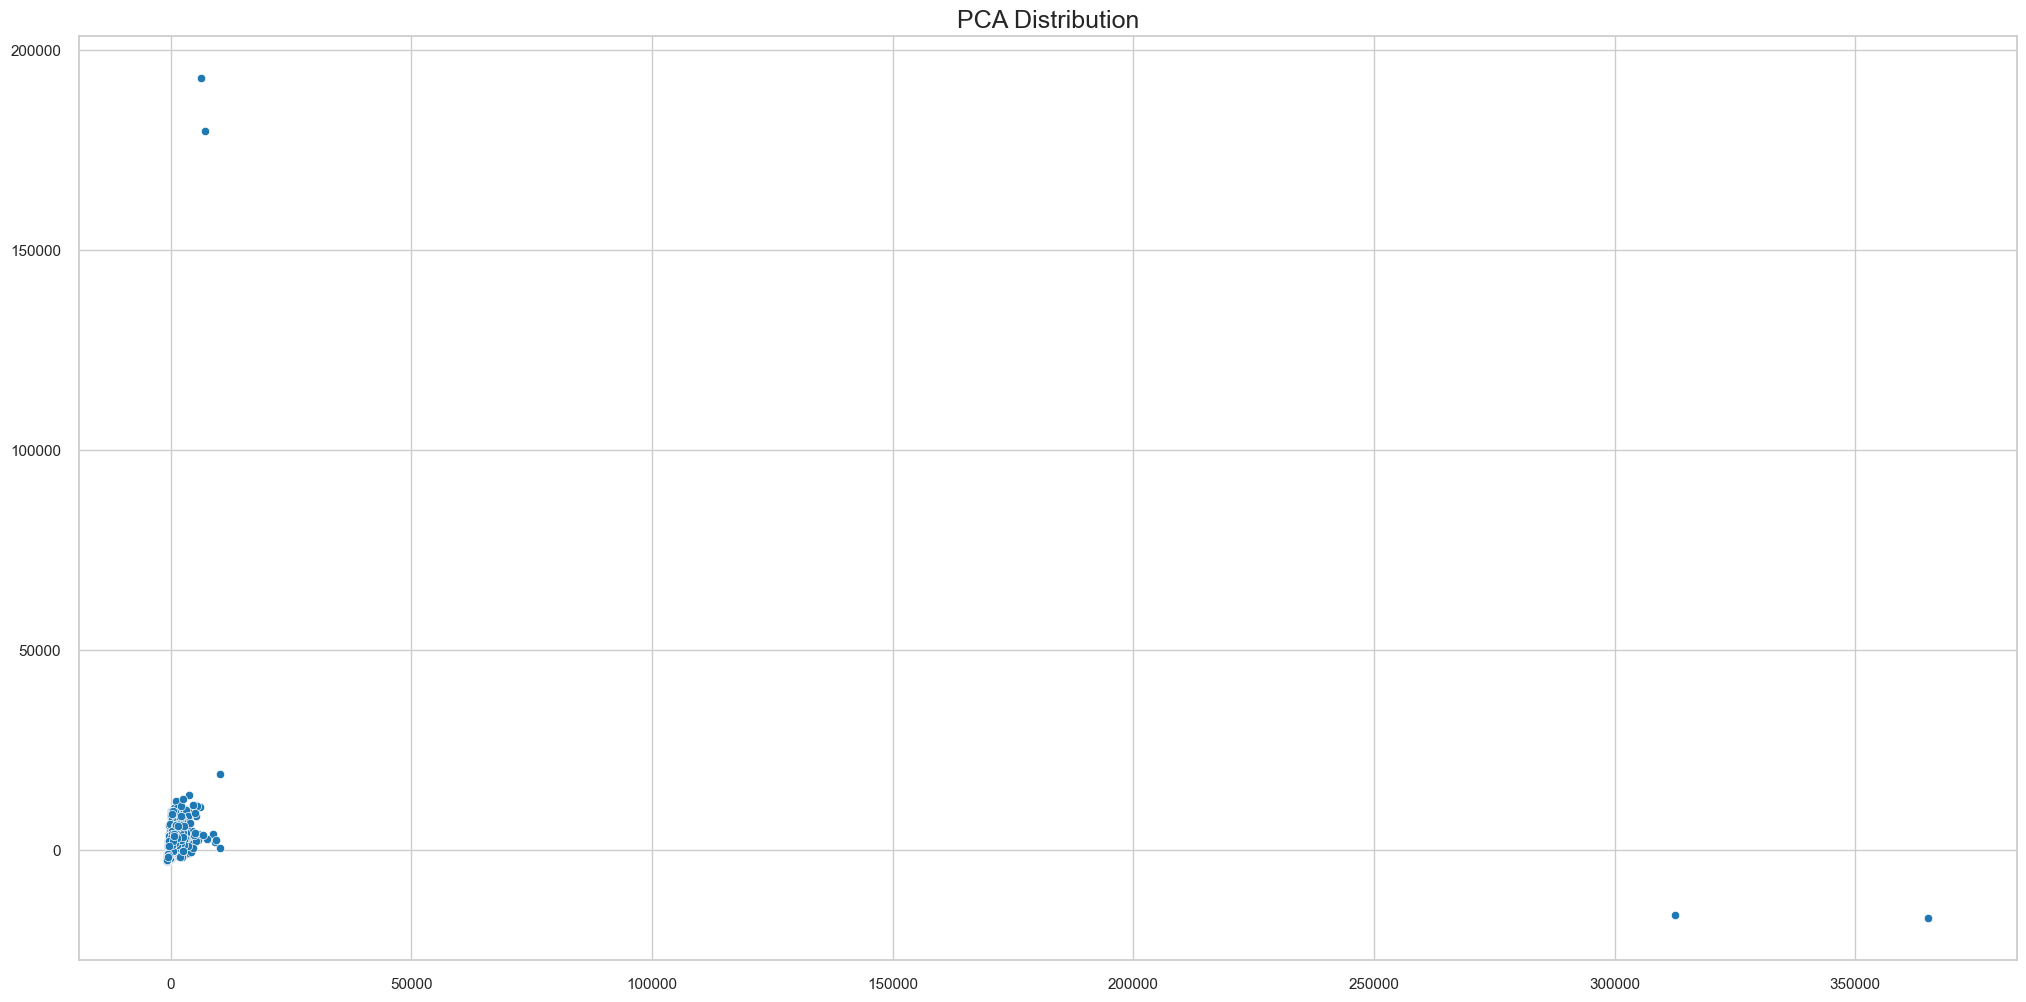

In [239]:
# plot
sns.scatterplot(x = 0, y = 1, data = df_pca);
plot_label('PCA Distribution', '', '', 12);

# saving figure
plt.savefig(homepath + 'reports/figures/pca_distribution.png')

#### UMAP

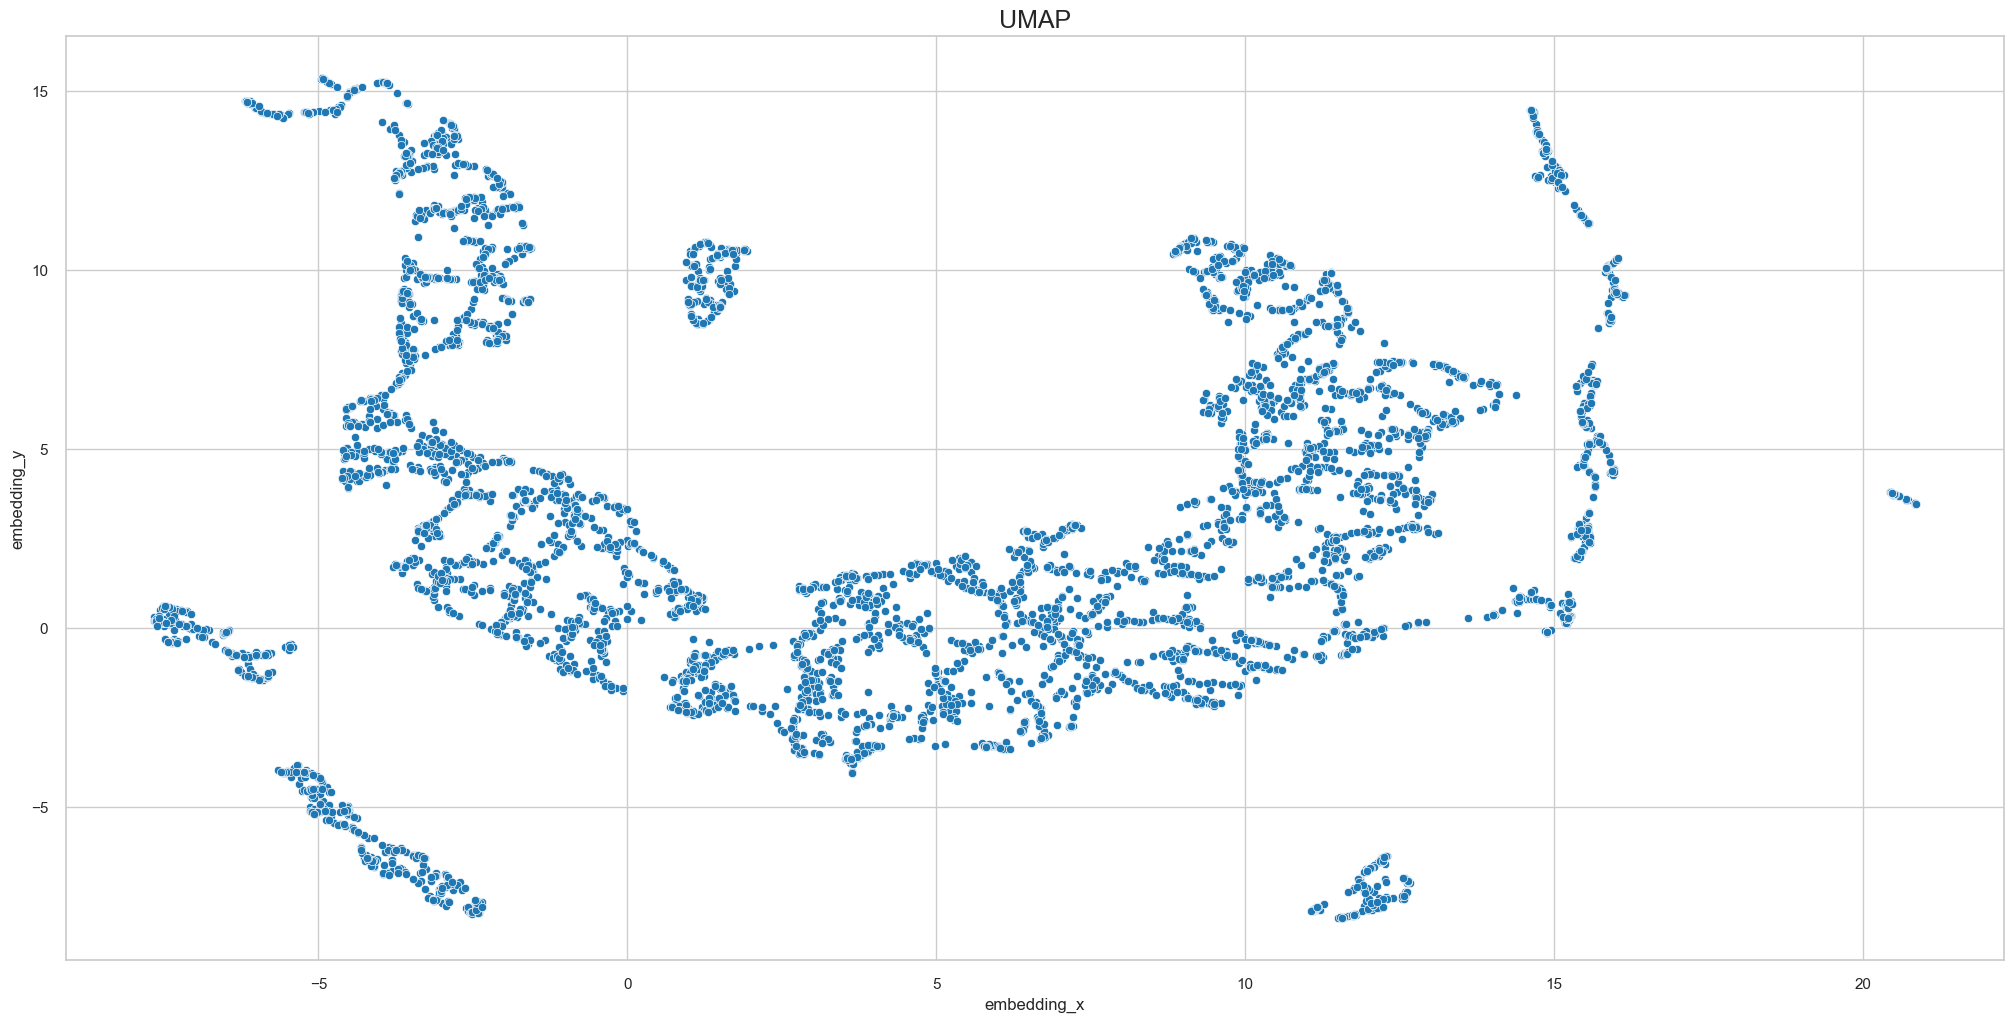

In [240]:
reducer = umap.UMAP(random_state = seed, n_jobs = 1)
embedding = reducer.fit_transform(df_cluster)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_pca);
plot_label('UMAP', 'embedding_x', 'embedding_y', 12);

# saving figure
plt.savefig(homepath + 'reports/figures/umap.png')

#### TSNE

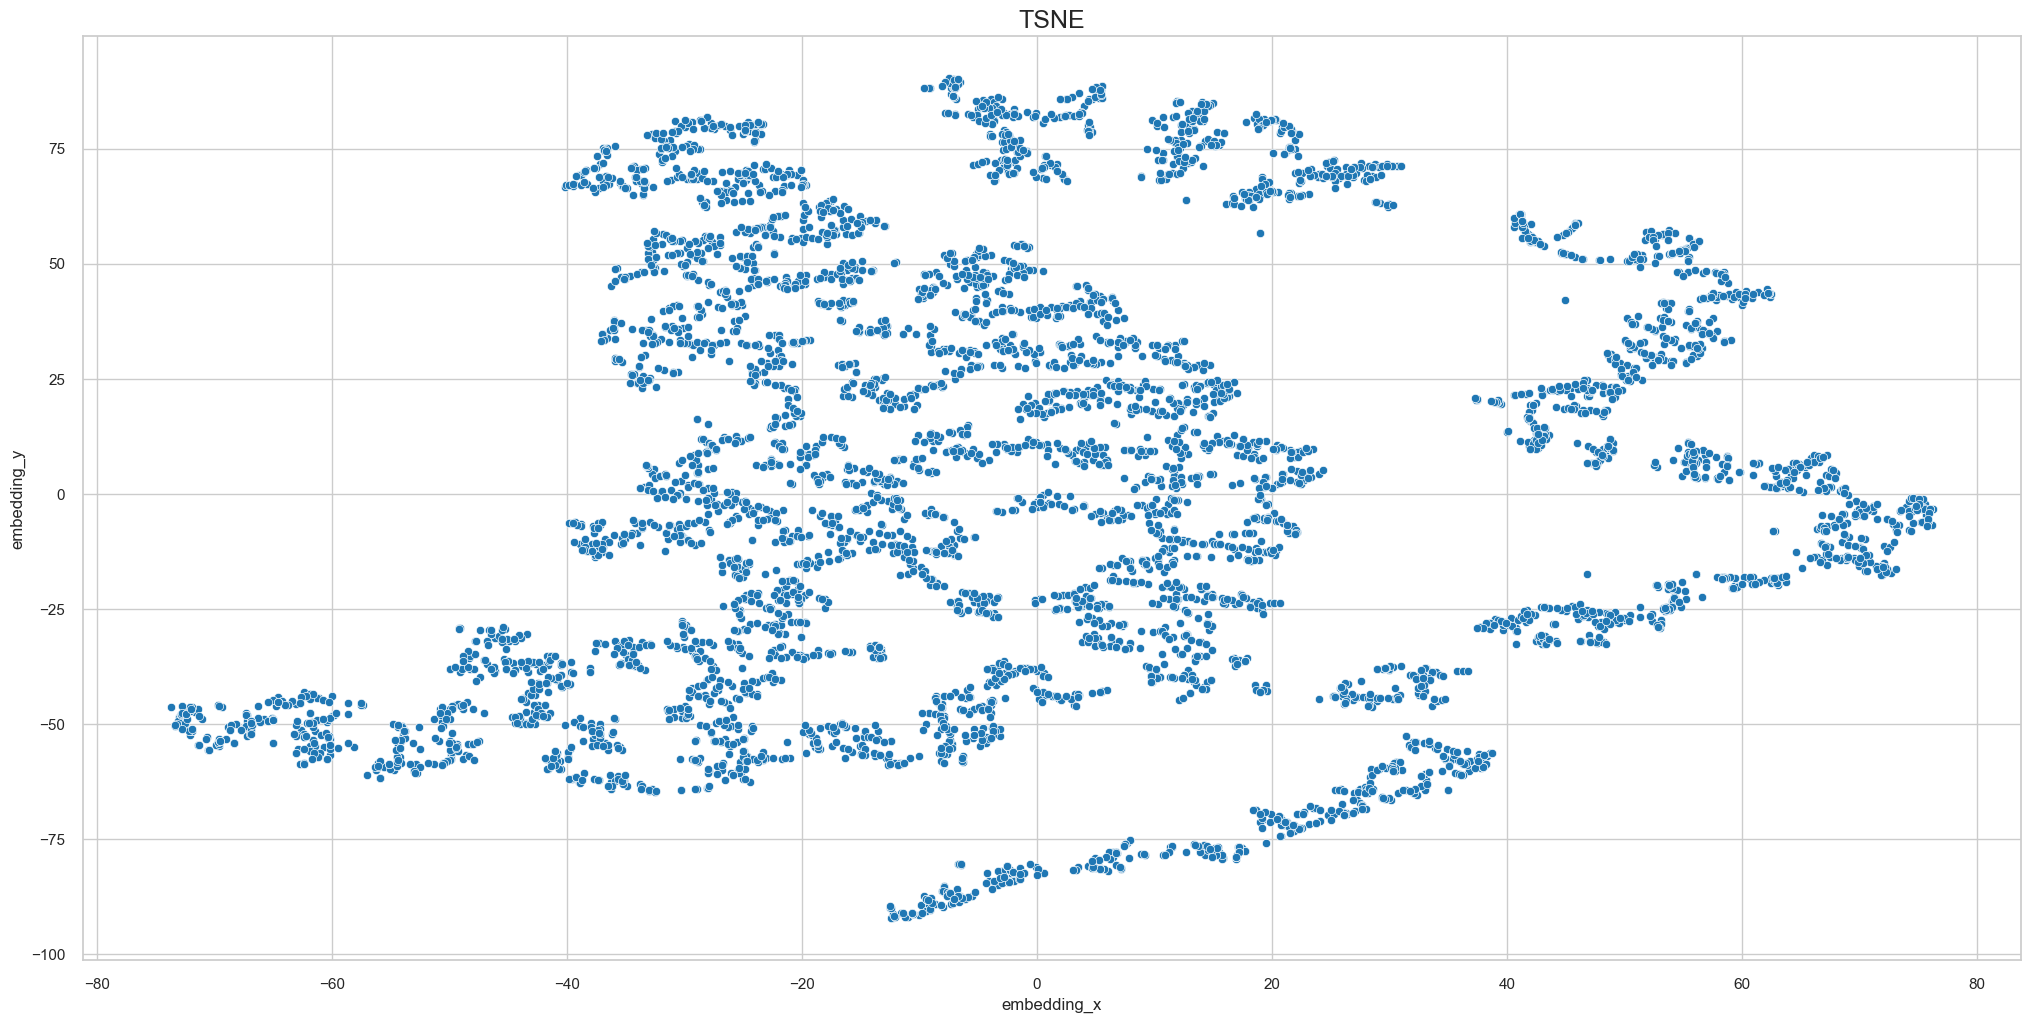

In [241]:
reducer = TSNE(n_components = 2, n_jobs = -1,random_state = seed)
embedding = reducer.fit_transform(df_cluster)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_pca);
plot_label('TSNE', 'embedding_x', 'embedding_y', 12);

# saving figure
plt.savefig(homepath + 'reports/figures/tsne.png')


#### Tree-Based TSNE

In [251]:
# training dataset
X = data.drop(['rent amount'], axis = 1)
y = data['rent amount']

# model
rf_model = RandomForestRegressor(n_estimators = 50, random_state = seed)
rf_model.fit(X, y)

df_leaf = pd.DataFrame(rf_model.apply(X))

print(f'X.shape: {X.shape}\ndf_leaf.shape: {df_leaf.shape}')

X.shape: (6080, 13)
df_leaf.shape: (6080, 50)


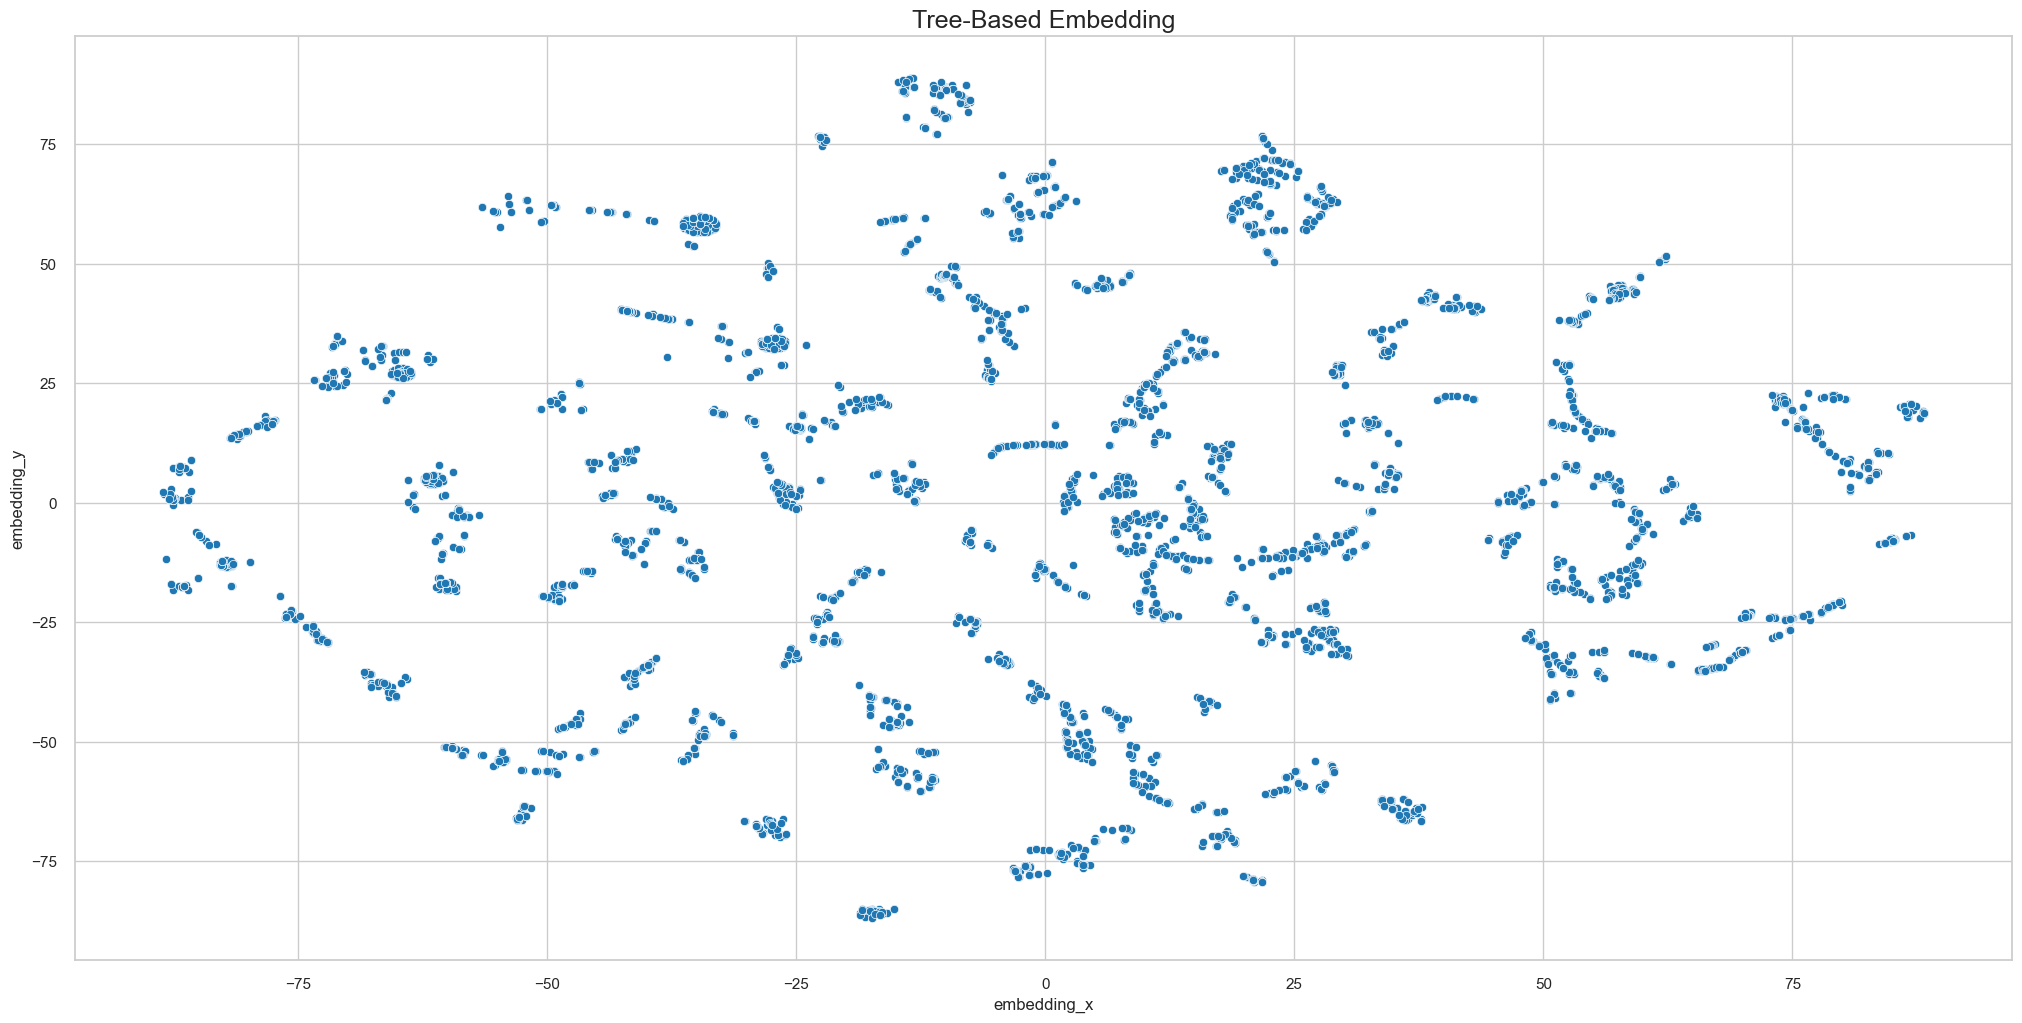

In [252]:
reducer = TSNE(random_state = seed, n_jobs = 1)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_tree);
plot_label('Tree-Based Embedding', 'embedding_x', 'embedding_y', 12);

# saving figure
plt.savefig(homepath + 'reports/figures/Tree-Based Embeddin.png')

#### Clusters

In [257]:
X = df_tree
clusters = np.arange(2, 50, 1)

# Kmeans
kmeans_list = []
for k in clusters:
    # definição do modelo
    kmeans_model = KMeans(n_clusters = k, n_init = 10)

    # treinamento
    kmeans_model.fit(X)

    # predição
    labels = kmeans_model.predict(X)

    # performance
    sil = silhouette_score(X, labels)
    kmeans_list.append(sil)


# Gaussian Mixture
gm_list = []
for k in clusters:
    # definição do modelo
    gm_model = GaussianMixture(n_components = k)

    # treinamento
    gm_model.fit(X)

    # predição
    labels = gm_model.predict(X)

    # performance
    sil = silhouette_score(X, labels)
    gm_list.append(sil)

# Hierarchical Clustering
hc_list = []
for k in clusters:
    # definição do modelo
    hc_model = hierarchy.linkage(X, 'ward')

    # predição
    labels = hierarchy.fcluster(hc_model, k, criterion = 'maxclust')

    # performance
    sil = silhouette_score(X, labels)
    hc_list.append(sil)


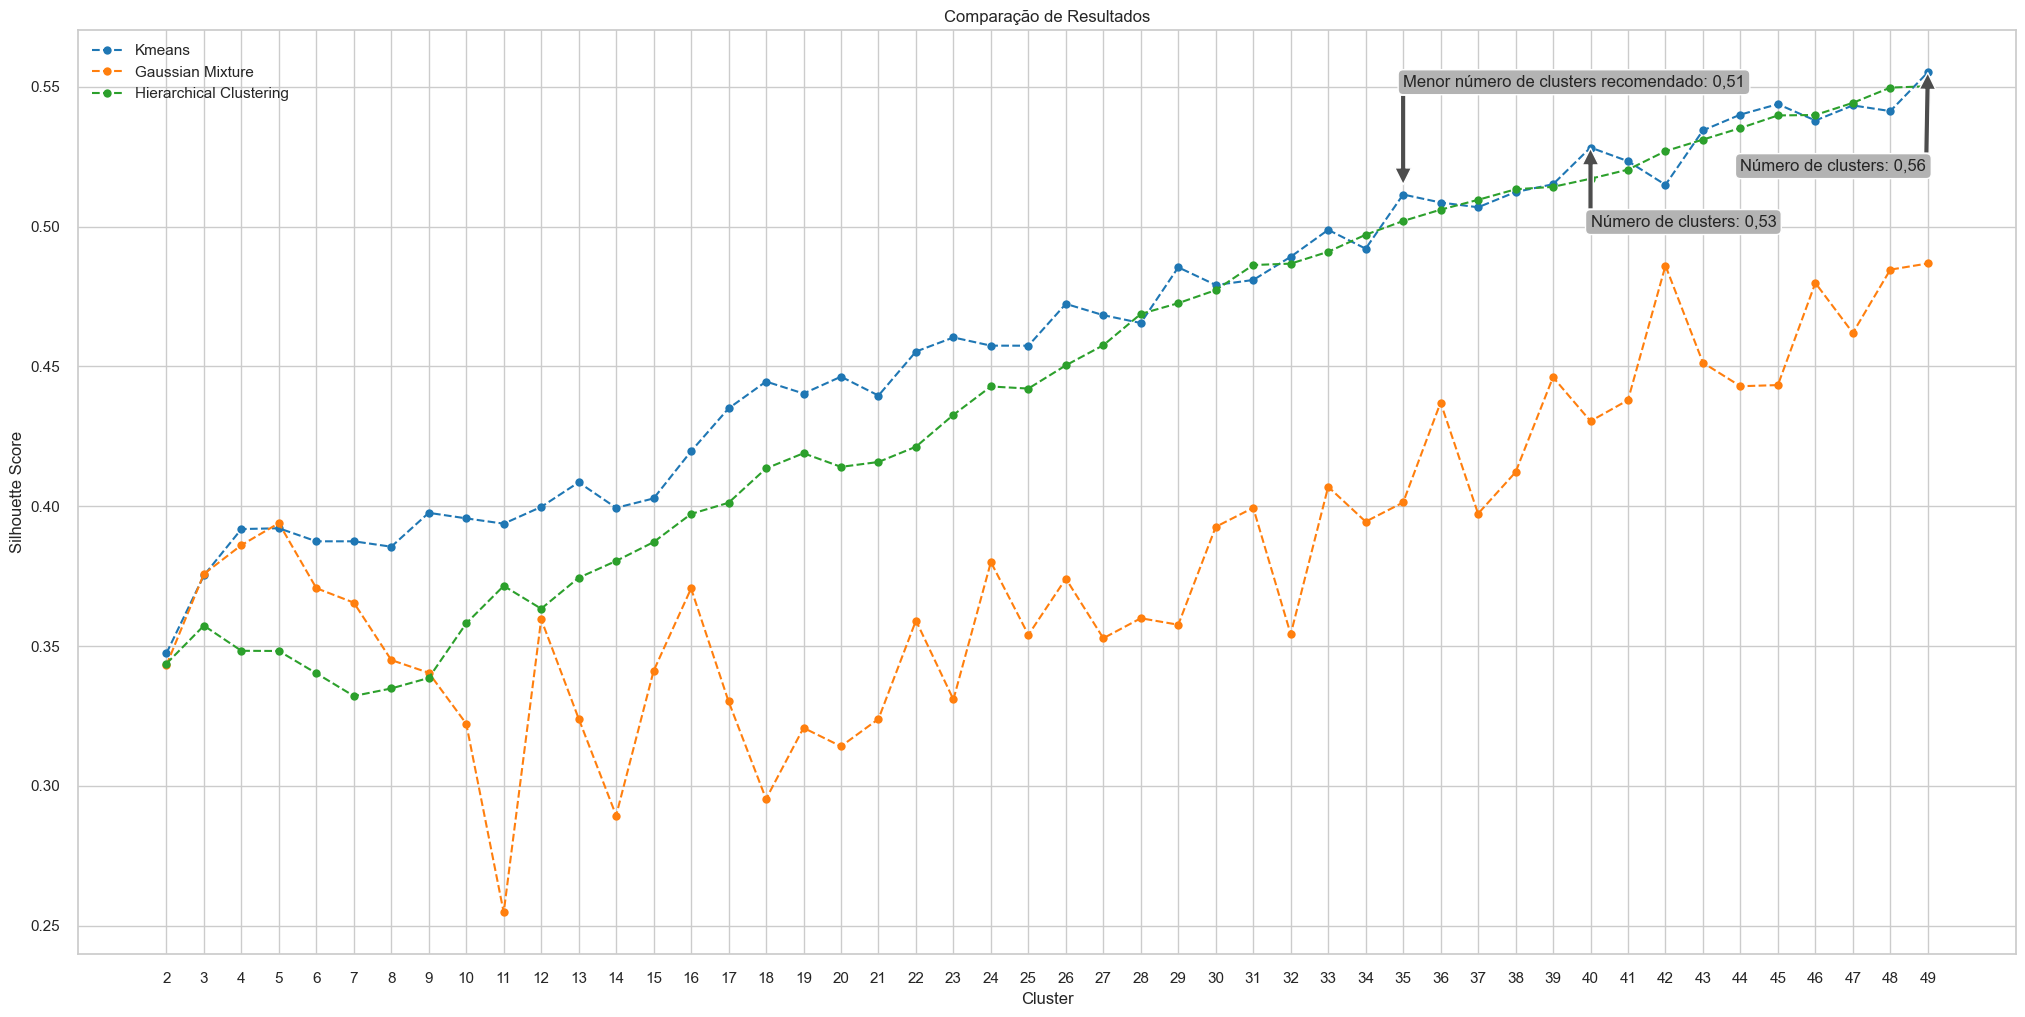

In [314]:
km_ss = silhouette_score_result(clusters, kmeans_list, cor1)

gm_ss = silhouette_score_result(clusters, gm_list, cor2)

hc_ss = silhouette_score_result(clusters, hc_list, cor3)

bbox = dict(boxstyle ='round', fc ='0.7')
arrowprops = dict(facecolor ='#4D4D4D')

plt.legend(['Kmeans', 'Gaussian Mixture', 'Hierarchical Clustering'])
plt.annotate('Menor número de clusters recomendado: 0,51', xy = (35, 0.515),
                xytext =(35, 0.55), 
                arrowprops = arrowprops, bbox = bbox)

plt.annotate('Número de clusters: 0,53', xy = (40, 0.528),
                xytext =(40, 0.5), 
                arrowprops = arrowprops, bbox = bbox)

plt.annotate('Número de clusters: 0,56', xy = (49, 0.555),
                xytext =(44, 0.52), 
                arrowprops = arrowprops, bbox = bbox)
                

# saving figure
plt.savefig(homepath + 'reports/figures/silhoette_score.png')

In [309]:
model_results = pd.DataFrame({  'KMeans': kmeans_list, 
                                'GM': gm_list, 
                                'HC': hc_list}).T

model_results.columns = clusters

model_results = model_results.iloc[: ,30:49]
model_results.style.highlight_max(color = '#F15854', axis = 1).highlight_min(color = '#5DA5DA', axis = 1)


,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
KMeans,0.489193,0.498821,0.492086,0.511451,0.508600,0.506891,0.512338,0.515129,0.528251,0.523373,0.514927,0.534385,0.540035,0.543770,0.537914,0.543317,0.541282,0.555122
GM,0.354239,0.406950,0.394485,0.401351,0.437080,0.397334,0.412170,0.446138,0.430414,0.437940,0.486011,0.451325,0.442905,0.443314,0.479836,0.461972,0.484591,0.486800
HC,0.486736,0.490985,0.497067,0.501985,0.506040,0.509554,0.513327,0.514199,0.517104,0.520357,0.526962,0.531104,0.535220,0.539732,0.539892,0.544228,0.549681,0.550164


Os dados estão muito dispersos, apesar disso, utilizando o kmeans com 35 clusters, é possível atingir o valor de score superior a 0.5, um valor razoável para dados tão dispersos. Nessa situação serão utilizados 39 clusters com um silhoette score de 0,53.

In [316]:
k = 39

clustering_model = KMeans(n_clusters = k, n_init = 10)
clustering_model.fit(X)

pickle.dump(clustering_model, open(homepath + '/models/clustering_model.pkl', 'wb'))

In [317]:
labels = clustering_model.predict(X)
df_tree['clusters'] = labels
df_tree.head()


,embedding_x,embedding_y,clusters
0,-28.839691,-67.822838,38
1,51.050167,-40.109535,19
2,-35.784889,-14.725585,1
3,57.144390,3.519742,21
4,61.124622,-32.370296,19


In [323]:
data['cluster'] = labels
data.head()

,id,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total,cluster
0,0,1,240,3,3,4,0,1,1,0,8000,1000,121,9121,38
1,1,0,64,2,1,1,10,1,0,540,820,122,11,1493,19
2,2,1,443,5,5,4,3,1,1,4172,7000,1417,89,12680,1
3,3,1,73,2,2,1,12,1,0,700,1250,150,16,2116,21
4,4,1,19,1,1,0,0,0,0,0,1200,41,16,1257,19


#### Resultado

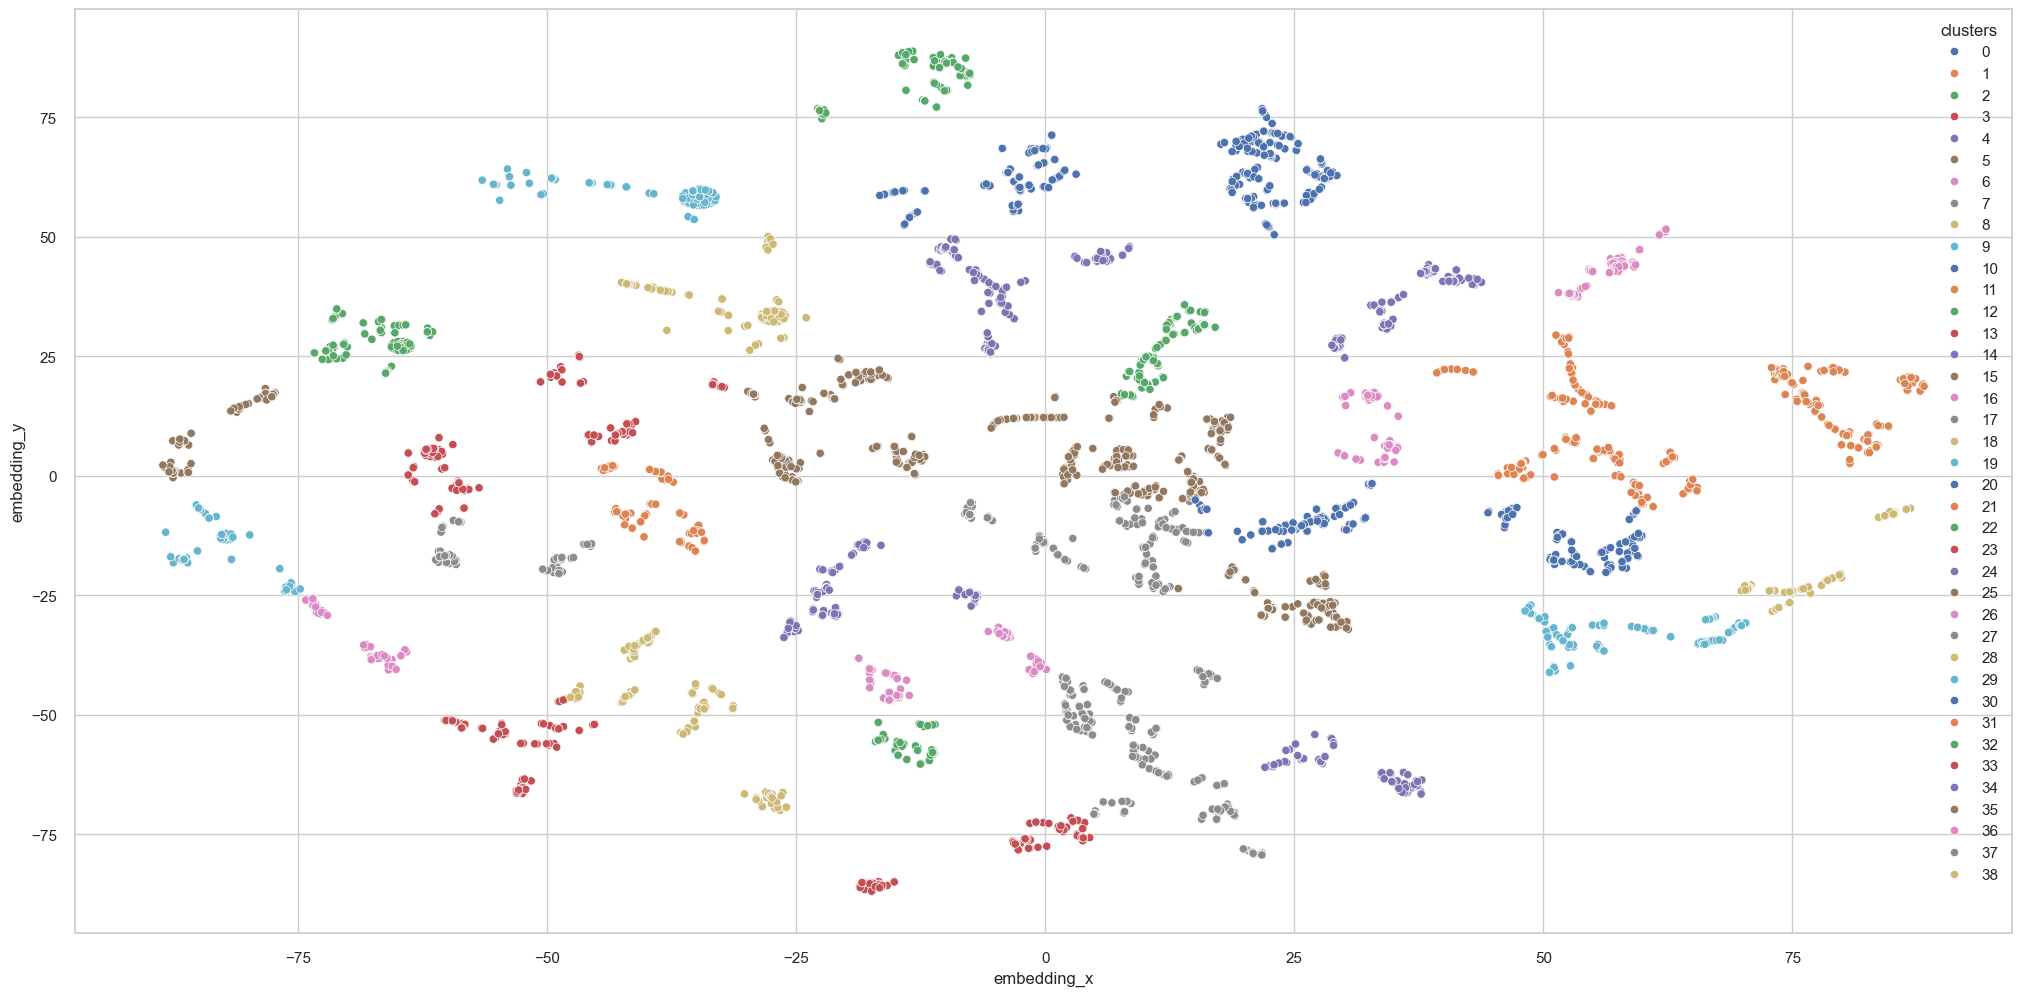

In [322]:
sns.scatterplot( x = 'embedding_x', y = 'embedding_y', hue = 'clusters', data = df_tree, palette = 'deep')

# saving figure
plt.savefig(homepath + 'reports/figures/clusters.png')

É possível identificar grupos de clusters nos imóveis, entretanto, a quantidade de grupos fica enorme (39), tornando difícil verificar as características individuais de cada cluster.